In [1]:
from matplotlib  import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict
from glob        import glob
from os.path     import exists

import numpy   as np
import librosa as lbr

# Current Pre-Processing Parameters:
### Number of time-frames is taken from:
https://arxiv.org/pdf/1508.01774.pdf Page 9, Table IV, ConvNet ws=7

However, maybe 5 time-frames would also be sufficient.
### Number cqt frequency bins:
Power of 2 for notes to be divisible by 2, so that we will be able to reshape the input in the way to capture higher harmonics more precisely.<br>We can always capture first three hamonics, but 4th and 5th are located 1.5 and 0.75 notes apart respectively.<br>Not sure if it is really necessary to capture high harmonics so precisely.  Maybe, 3 cqt bins would also be sufficient.
### Non-linear logarithmic scaling:
librosa.amplitude_to_db (not sure if it has any influence on final accuracy though)
### Harmonic-percussive separation margin and kernel size:
Don't know which would be optimal, and currently use librosa default.<br>
__*Note:*__ cqts are passed to librosa.hpss, but it supposes to receive stft, so maybe, kernel height for percussive filter should be reduced proportionally (not done at the moment).
# Currently not used:
### Normalization:
Yes, normalization is important, without it the final program outputs would significantly depend on the volume of input.  But we would have to save normalization factors for using them on testing dataset.  So, instead of normalizing at pre-processing stage, the input is passed through the __*"BatchNormalization"*__ layer in CNN, it is more convenient and less error-prone.

In [2]:
dataFolder, nBins, nFrames = 'Datasets', 4, 7

def SaveNumPy(waves, name, txtHeader=None, CheckShape=lambda f, n, c: None):
    cqtsData, notesData, warnWaves, excludedWaves = [], [], [], []
    for i, song in enumerate(waves):
#        if exists(song[:-4] + ' Cqts.npy') and exists(song[:-4] + ' Notes.npy'):
#            cqtsData  += [np.load(song[:-4] + ' Cqts.npy')]
#            notesData += [np.load(song[:-4] + ' Notes.npy')]
#        else:
        if True:
            y, notes = lbr.load(song)[0], OrderedDict()
            cqts = lbr.decompose.hpss(lbr.amplitude_to_db(lbr.magphase(lbr.cqt(
                y, fmin=lbr.note_to_hz('A0'), n_bins=88*nBins, bins_per_octave=12*nBins))[0]
                    , ref=np.min) # TODO: change to ref=1 (default), because it will be "Bath Normalized" in CNN anyway
#                        , kernel_size=(nFrames, int(31 * 88 * nBins / len(lbr.fft_frequencies()) // 2 * 2 + 1))
                                     )[0].astype(np.float16).T
            folders = song.split('\\')[:-1]
            with open(song[:-3] + 'txt') as trueData:
                if txtHeader: assert trueData.readline() == txtHeader
                for line in trueData:
                    if line.isspace(): continue
                    onset, _, n = map(float, line.split())
                    if folders[1] == 'LabRosa Columbia' and onset > lbr.get_duration(y): break
                    assert 0 <= onset < lbr.get_duration(y) and int(n) == n
                    notes[lbr.time_to_frames(onset)] = notes.get(lbr.time_to_frames(onset), []) + [int(n) - 21]
            assert (min(min(n) for n in notes.values()) >= 0 and max(max(n) for n in notes.values()) < 88
                    and sorted(notes.keys()) == list(notes.keys()))

            timeFrames = set(notes.keys())
            for t in notes.keys():
                for f in range(1, nFrames // 2 + 1):
                    timeFrames |= { max(0, t - f), min(len(cqts) - 1, t + f) }
            maxFrames = cqts[list(timeFrames)].sum(1)
            assert len(maxFrames.shape) == 1 and len(notes.keys()) <= len(maxFrames) <= len(notes.keys()) * nFrames
            if maxFrames.min() == 0:
                excludedWaves += [song]
                print('EXCLUDED ', end='')
            else:
                cqts = np.vstack([np.zeros((nFrames // 2, cqts.shape[1]), cqts.dtype), cqts,
                                  np.zeros((nFrames // 2, cqts.shape[1]), cqts.dtype)])
                cqtsData += [np.array([cqts[range(frame, frame + nFrames)] for frame in notes.keys()])]
                notesData += [np.zeros((len(notes), 88), np.int8)]
                for j, n in enumerate(notes.values()): notesData[-1][j][n] = 1
                assert len(cqtsData[-1]) == len(notesData[-1])

                if folders[1] == 'MAPS' and folders[3] in ['RAND', 'UCHO'] and len(notesData[-1]) > 1:
                    warnWaves += [song]
                    print('WARNING ', end='')
                    assert len(notesData[-1]) == 2 and np.diff(np.array(list(notes.keys()))) == 1
                    cqtsData[-1] = cqtsData[-1][-1].reshape((1,) + cqtsData[-1][-1].shape)
                    notesData[-1] = np.sum(notesData[-1], 0, notesData[-1].dtype, keepdims=True)
                    assert len(cqtsData[-1]) == len(notesData[-1])
                assert cqtsData[-1].shape[1] == nFrames and notesData[-1].shape[1] == 88 and notesData[-1].dtype == np.int8
                CheckShape(folders, notesData[-1], cqtsData[-1])
                
                np.save(song[:-4] +  ' Cqts',  cqtsData[-1])
                np.save(song[:-4] + ' Notes', notesData[-1])

        print('{} out of {}: {}'.format(i + 1, len(waves), song))

    if warnWaves:     print('\nWARNING:\n\t',  '\n\t'.join(warnWaves),     sep='')
    if excludedWaves: print('\nEXCLUDED:\n\t', '\n\t'.join(excludedWaves), sep='')

    notesData = np.array(notesData)
    assert (np.array([set(n.ravel()) for n in notesData]) == {0, 1}).all()
    np.save('{}/{}{} Cqts{} Float16 {}'. format(dataFolder, ('WARN ' if warnWaves or excludedWaves else ''),
                                                name, nBins, len(cqtsData)), cqtsData)
    np.save('{}/{}{} Notes Cqt{} {}'.format(dataFolder, ('WARN ' if warnWaves or excludedWaves else ''),
                                            name, nBins, len(notesData)), notesData)
    print('\n{} saved.\n'.format(name))

In [3]:
erlangenFolder, labRosaFolder, viennaFolder = 'AudioLabs-Erlangen', 'LabRosa Columbia', 'Vienna 4x22 corpus (Aligned)'

def SimpleCheck(folders, notes, cqts): assert len(notes) > 1 and (notes.sum(1) > 0).all()

def CombineNumPys(cqtFiles, noteFiles, name):
    cqts, notes = [], []
    for c, n in zip(cqtFiles, noteFiles):
        prefix, nSamples = c.split()[0], c.split()[-1].split('.')[0]
        assert prefix == n.split()[0] and nSamples == n.split()[-1].split('.')[0]
        cqts, notes = np.hstack([cqts, np.load(c)]), np.hstack([notes, np.load(n)])
        print(prefix, nSamples, 'loaded.')
    
    assert (len(cqts) == len(notes) and np.array([len(c) == len(n) for c, n in zip(cqts, notes)]).all()
        and np.array([n.shape[1] == 88               for n in notes]).all()
        and np.array([c.shape[1] == nFrames          for c in cqts[1:]]).all()
        and np.array([c.shape[2] % 88 == 0           for c in cqts[1:]]).all()
        and np.array([c.shape[2] == cqts[0].shape[2] for c in cqts[1:]]).all()
        and (np.array([set(n.ravel())                for n in notes]) == {0, 1}).all())
    
    print('\n', len(notes), 'samples,', end='\t')
    cqts, notes = map(np.vstack, [cqts, notes])
    print(      len(notes), 'chords')
    print('Cqt decibels in range  [{:.2e} - {:.0f} - {:.0f}]'.format(cqts.min(), cqts.mean(), cqts.max()))

    np.save('{}/{} Cqts{} Float16 {}'.format(dataFolder, name, nBins, len(cqts)), cqts)
    np.save('{}/{} Notes {}'.format(dataFolder, name, len(notes)), notes)
    print("Combined NumPy's saved.")

# Downloaded from Fichiers - Aix-Marseille Université:
https://amubox.univ-amu.fr/index.php/s/iNG0xc5Td1Nv4rR

NumPy's with the problematic samples described below are saved with 'WARN' preffix.

## Warning 1: Total silence at some time frames (currently not relevant).

Sometimes, depending on parameters, some cqt-columns are zeros (mainly for __*"ISOL"*__ samples, where loudness = __*"P"*__ (piano) & sustain pedal = __*"S0"*__ (not pressed)).  Don't know what the reason is, the corresponding WAV-samples sound perfectly fine.  When such columns fall into the time-frames we are interested in (regions of the note onsets), those samples are excluded, just to be safe (fortunately, there are usually just a few of such samples), and the message 'EXCLUDED' is printed.

Currently, the parameters of CQT-transform are such, that all cqts-columns are non-zero, and no samples are excluded.

## Warning 2: Two chords instead of one.

There is an issue with datasets __*"ENSTDkAm"*__ & __*"ENSTDkCl"*__, subtypes __*"RAND"*__ & __*"UCHO"*__.  They are assumed to have only one chord per one WAV-file.  But sometimes the chord is split into two onset times in corresponding MIDI and TXT-files, and those two onset times fall into two consecutive time-frames of cqt-transform.  BTW, __*"ENSTDkAm"*__ & __*"ENSTDkCl"*__ are "real piano" types, so, maybe it is the reason.

Not sure which is the correct way to handle this kind of samples.  Almost half of them are like this, so I did not want just to exclude them.  I ended up joining notes from two time-frames into one chord, and taking the cqt-data for the second onset time. 'WARNING' message is printed for such samples.

In [10]:
def CheckMAPS(folders, notes, cqts):
        if folders[3] == 'ISOL': assert (notes.sum(1) == 1).all() and len(notes) == {
            'NO': 1, 'ST': 1, 'RE': 15, 'TR1': 30, 'TR2': 30, 'CH': 176}[folders[4]]
        elif folders[3] == 'RAND': assert (folders[6][0] == 'P' and int(folders[6][1]) in np.arange(2, 8)
                                           and len(notes) == 1 and notes.sum(1) == int(folders[6][1]))
        elif folders[3] == 'UCHO':
            chordFolder, chordParsed = folders[5].split('-'), notes.nonzero()[1]
            assert (chordFolder[0] == 'C0' and len(notes) == 1 and  notes.sum(1) == len(chordFolder)
                    and ((chordParsed - chordParsed[0])[1:] == np.array(chordFolder[1:], np.int8)).all())
        else: assert   folders[3] == 'MUS' and len(notes)  > 1 and (notes.sum(1) > 0).all()

for mapFolder in glob(dataFolder + '\MAPS\*\\'):
    SaveNumPy(glob(mapFolder + '**\*.wav', recursive=True), mapFolder.split('\\')[-2],
              'OnsetTime\tOffsetTime\tMidiPitch\n', CheckMAPS)

1 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.05_F_AkPnBcht.wav
2 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.05_M_AkPnBcht.wav
3 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.05_P_AkPnBcht.wav
4 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_F_AkPnBcht.wav
5 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_M_AkPnBcht.wav
6 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_P_AkPnBcht.wav
7 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.3_F_AkPnBcht.wav
8 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.3_M_AkPnBcht.wav
9 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.3_P_AkPnBcht.wav
10 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_F_S0_M100_AkPnBcht.wav
11 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_F_S0_M104_AkPnBcht.wav
12 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_F_S0_M105_AkPnBcht.wav
13 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISO

102 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M22_AkPnBcht.wav
103 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M24_AkPnBcht.wav
104 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M27_AkPnBcht.wav
105 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M28_AkPnBcht.wav
106 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M30_AkPnBcht.wav
107 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M32_AkPnBcht.wav
108 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M33_AkPnBcht.wav
109 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M36_AkPnBcht.wav
110 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M38_AkPnBcht.wav
111 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M43_AkPnBcht.wav
112 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M44_AkPnBcht.wav
113 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_M_S0_M46_AkPnBcht.wav
114 

201 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M44_AkPnBcht.wav
202 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M49_AkPnBcht.wav
203 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M50_AkPnBcht.wav
204 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M51_AkPnBcht.wav
205 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M53_AkPnBcht.wav
206 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M54_AkPnBcht.wav
207 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M55_AkPnBcht.wav
208 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M56_AkPnBcht.wav
209 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M61_AkPnBcht.wav
210 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M62_AkPnBcht.wav
211 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M63_AkPnBcht.wav
212 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\NO\MAPS_ISOL_NO_P_S0_M64_AkPnBcht.wav
213 

300 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S0_M31_AkPnBcht.wav
301 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S0_M56_AkPnBcht.wav
302 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S0_M57_AkPnBcht.wav
303 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S0_M66_AkPnBcht.wav
304 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S0_M70_AkPnBcht.wav
305 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S0_M80_AkPnBcht.wav
306 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S1_M104_AkPnBcht.wav
307 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S1_M33_AkPnBcht.wav
308 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S1_M41_AkPnBcht.wav
309 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S1_M49_AkPnBcht.wav
310 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S1_M63_AkPnBcht.wav
311 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\RE\MAPS_ISOL_RE_M_S1_M69_AkPnBcht.wav
312

399 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M33_AkPnBcht.wav
400 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M35_AkPnBcht.wav
401 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M37_AkPnBcht.wav
402 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M38_AkPnBcht.wav
403 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M40_AkPnBcht.wav
404 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M43_AkPnBcht.wav
405 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M46_AkPnBcht.wav
406 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M48_AkPnBcht.wav
407 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M56_AkPnBcht.wav
408 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M58_AkPnBcht.wav
409 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M59_AkPnBcht.wav
410 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_F_S1_M62_AkPnBcht.wav
411 

498 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M77_AkPnBcht.wav
499 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M78_AkPnBcht.wav
500 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M81_AkPnBcht.wav
501 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M82_AkPnBcht.wav
502 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M84_AkPnBcht.wav
503 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M85_AkPnBcht.wav
504 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M86_AkPnBcht.wav
505 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M87_AkPnBcht.wav
506 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M88_AkPnBcht.wav
507 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M89_AkPnBcht.wav
508 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M90_AkPnBcht.wav
509 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_M_S1_M91_AkPnBcht.wav
510 

597 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M90_AkPnBcht.wav
598 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M91_AkPnBcht.wav
599 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M93_AkPnBcht.wav
600 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M94_AkPnBcht.wav
601 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M95_AkPnBcht.wav
602 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M96_AkPnBcht.wav
603 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\ST\MAPS_ISOL_ST_P_S1_M97_AkPnBcht.wav
604 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M35_AkPnBcht.wav
605 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M37_AkPnBcht.wav
606 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M47_AkPnBcht.wav
607 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M53_AkPnBcht.wav
608 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M59_AkPnBch

694 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M34_AkPnBcht.wav
695 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M44_AkPnBcht.wav
696 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M53_AkPnBcht.wav
697 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M63_AkPnBcht.wav
698 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M64_AkPnBcht.wav
699 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M78_AkPnBcht.wav
700 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M88_AkPnBcht.wav
701 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M90_AkPnBcht.wav
702 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M100_AkPnBcht.wav
703 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M103_AkPnBcht.wav
704 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M35_AkPnBcht.wav
705 out of 3735: Datasets\MAPS\AkPnBcht\ISOL\TR2\MAPS_ISOL_TR2_

788 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n44_AkPnBcht.wav
789 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n45_AkPnBcht.wav
790 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n49_AkPnBcht.wav
791 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n5_AkPnBcht.wav
792 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n6_AkPnBcht.wav
793 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n7_AkPnBcht.wav
794 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n8_AkPnBcht.wav
795 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n12_AkPnBcht.wav
796 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n13_AkPnBcht.wav
797 o

862 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n50_AkPnBcht.wav
863 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n5_AkPnBcht.wav
864 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n6_AkPnBcht.wav
865 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n8_AkPnBcht.wav
866 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n13_AkPnBcht.wav
867 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n14_AkPnBcht.wav
868 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n15_AkPnBcht.wav
869 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n17_AkPnBcht.wav
870 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n19_AkPnBcht.wav
871 

936 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n35_AkPnBcht.wav
937 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n37_AkPnBcht.wav
938 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n39_AkPnBcht.wav
939 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n3_AkPnBcht.wav
940 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n41_AkPnBcht.wav
941 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n42_AkPnBcht.wav
942 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n43_AkPnBcht.wav
943 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n44_AkPnBcht.wav
944 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n46_AkPnBcht.wav
94

1010 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n44_AkPnBcht.wav
1011 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n45_AkPnBcht.wav
1012 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n46_AkPnBcht.wav
1013 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n48_AkPnBcht.wav
1014 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n5_AkPnBcht.wav
1015 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n9_AkPnBcht.wav
1016 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n10_AkPnBcht.wav
1017 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n12_AkPnBcht.wav
1018 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n15_AkPnBch

1084 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n48_AkPnBcht.wav
1085 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n49_AkPnBcht.wav
1086 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n50_AkPnBcht.wav
1087 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n5_AkPnBcht.wav
1088 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n6_AkPnBcht.wav
1089 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n8_AkPnBcht.wav
1090 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n9_AkPnBcht.wav
1091 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n14_AkPnBcht.wav
1092 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n15_AkPnBcht.

1158 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n3_AkPnBcht.wav
1159 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n41_AkPnBcht.wav
1160 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n43_AkPnBcht.wav
1161 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n45_AkPnBcht.wav
1162 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n46_AkPnBcht.wav
1163 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n4_AkPnBcht.wav
1164 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n8_AkPnBcht.wav
1165 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n9_AkPnBcht.wav
1166 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n10_AkPnBcht.

1232 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n43_AkPnBcht.wav
1233 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n44_AkPnBcht.wav
1234 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n45_AkPnBcht.wav
1235 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n46_AkPnBcht.wav
1236 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n47_AkPnBcht.wav
1237 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n49_AkPnBcht.wav
1238 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n50_AkPnBcht.wav
1239 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n7_AkPnBcht.wav
1240 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n10_AkPnBc

1306 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n39_AkPnBcht.wav
1307 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n40_AkPnBcht.wav
1308 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n42_AkPnBcht.wav
1309 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n43_AkPnBcht.wav
1310 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n46_AkPnBcht.wav
1311 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n47_AkPnBcht.wav
1312 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n4_AkPnBcht.wav
1313 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n5_AkPnBcht.wav
1314 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n6_AkPnBcht

1380 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n34_AkPnBcht.wav
1381 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n35_AkPnBcht.wav
1382 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n37_AkPnBcht.wav
1383 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n3_AkPnBcht.wav
1384 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n40_AkPnBcht.wav
1385 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n42_AkPnBcht.wav
1386 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n44_AkPnBcht.wav
1387 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n45_AkPnBcht.wav
1388 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n46_AkPnBcht.wav
1389 out of

1455 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n35_AkPnBcht.wav
1456 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n36_AkPnBcht.wav
1457 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n37_AkPnBcht.wav
1458 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n39_AkPnBcht.wav
1459 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n40_AkPnBcht.wav
1460 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n45_AkPnBcht.wav
1461 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n47_AkPnBcht.wav
1462 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n50_AkPnBcht.wav
1463 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n6_AkPnBcht.wav
1464 out of

1530 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n37_AkPnBcht.wav
1531 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n41_AkPnBcht.wav
1532 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n43_AkPnBcht.wav
1533 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n47_AkPnBcht.wav
1534 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n49_AkPnBcht.wav
1535 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n7_AkPnBcht.wav
1536 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n8_AkPnBcht.wav
1537 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n9_AkPnBcht.wav
1538 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n10_AkPnBcht.wav
1539 out of 3

1605 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n30_AkPnBcht.wav
1606 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n32_AkPnBcht.wav
1607 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n33_AkPnBcht.wav
1608 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n34_AkPnBcht.wav
1609 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n35_AkPnBcht.wav
1610 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n38_AkPnBcht.wav
1611 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n39_AkPnBcht.wav
1612 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n41_AkPnBcht.wav
1613 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n45_AkPnBcht.wav
1614 out o

1680 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n31_AkPnBcht.wav
1681 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n38_AkPnBcht.wav
1682 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n39_AkPnBcht.wav
1683 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n3_AkPnBcht.wav
1684 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n40_AkPnBcht.wav
1685 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n41_AkPnBcht.wav
1686 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n42_AkPnBcht.wav
1687 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n43_AkPnBcht.wav
1688 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n44_AkPnBcht.wav
1689 out of

1755 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n31_AkPnBcht.wav
1756 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n33_AkPnBcht.wav
1757 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n35_AkPnBcht.wav
1758 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n39_AkPnBcht.wav
1759 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n3_AkPnBcht.wav
1760 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n40_AkPnBcht.wav
1761 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n43_AkPnBcht.wav
1762 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n44_AkPnBcht.wav
1763 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n45_AkPnBcht.wav
1764 out of

1830 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n33_AkPnBcht.wav
1831 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n38_AkPnBcht.wav
1832 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n39_AkPnBcht.wav
1833 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n3_AkPnBcht.wav
1834 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n40_AkPnBcht.wav
1835 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n41_AkPnBcht.wav
1836 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n42_AkPnBcht.wav
1837 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n44_AkPnBcht.wav
1838 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n45_AkPnBcht.wav
1839 out of

1905 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n37_AkPnBcht.wav
1906 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n40_AkPnBcht.wav
1907 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n41_AkPnBcht.wav
1908 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n46_AkPnBcht.wav
1909 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n47_AkPnBcht.wav
1910 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n48_AkPnBcht.wav
1911 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n49_AkPnBcht.wav
1912 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n4_AkPnBcht.wav
1913 out of 3735: Datasets\MAPS\AkPnBcht\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n50_AkPnBcht.wav
1914 out of

1982 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n2_AkPnBcht.wav
1983 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n3_AkPnBcht.wav
1984 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n4_AkPnBcht.wav
1985 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n5_AkPnBcht.wav
1986 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n6_AkPnBcht.wav
1987 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n7_AkPnBcht.wav
1988 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I32-96_S0_n1_AkPnBcht.wav
1989 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I32-96_S0_n2_AkPnBcht.wav
1990 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I32-96_S0_n3_AkPnBcht.wav
1

2057 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n11_AkPnBcht.wav
2058 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n13_AkPnBcht.wav
2059 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n14_AkPnBcht.wav
2060 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n15_AkPnBcht.wav
2061 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n1_AkPnBcht.wav
2062 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n2_AkPnBcht.wav
2063 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n4_AkPnBcht.wav
2064 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n6_AkPnBcht.wav
2065 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n9_AkPnBcht.wav
2066 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S0_n1

2138 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n6_AkPnBcht.wav
2139 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n7_AkPnBcht.wav
2140 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n1_AkPnBcht.wav
2141 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n3_AkPnBcht.wav
2142 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n5_AkPnBcht.wav
2143 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n6_AkPnBcht.wav
2144 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n7_AkPnBcht.wav
2145 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S1_n2_AkPnBcht.wav
2146 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S1_n4_AkPnBcht.wav
2

2213 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n5_AkPnBcht.wav
2214 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n6_AkPnBcht.wav
2215 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n3_AkPnBcht.wav
2216 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n7_AkPnBcht.wav
2217 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S0_n6_AkPnBcht.wav
2218 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S0_n7_AkPnBcht.wav
2219 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S1_n1_AkPnBcht.wav
2220 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S1_n2_AkPnBcht.wav
2221 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S1

2290 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n5_AkPnBcht.wav
2291 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n6_AkPnBcht.wav
2292 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n2_AkPnBcht.wav
2293 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n3_AkPnBcht.wav
2294 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n4_AkPnBcht.wav
2295 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n7_AkPnBcht.wav
2296 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I32-96_S0_n1_AkPnBcht.wav
2297 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I32-96_S0_n3_AkPnBcht.wav
2298 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I32-96_S0_n7_AkPnBcht.wav
2

2366 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S1_n7_AkPnBcht.wav
2367 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n2_AkPnBcht.wav
2368 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n7_AkPnBcht.wav
2369 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n1_AkPnBcht.wav
2370 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n3_AkPnBcht.wav
2371 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n4_AkPnBcht.wav
2372 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n5_AkPnBcht.wav
2373 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n6_AkPnBcht.wav
2374 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I32-96_S0_n3_AkPnBcht.wav
237

2441 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n2_AkPnBcht.wav
2442 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n5_AkPnBcht.wav
2443 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n6_AkPnBcht.wav
2444 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n7_AkPnBcht.wav
2445 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n1_AkPnBcht.wav
2446 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n3_AkPnBcht.wav
2447 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n4_AkPnBcht.wav
2448 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S1_n2_AkPnBcht.wav
2449 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S1_n5_Ak

2517 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n10_AkPnBcht.wav
2518 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n12_AkPnBcht.wav
2519 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n13_AkPnBcht.wav
2520 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n14_AkPnBcht.wav
2521 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n3_AkPnBcht.wav
2522 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n5_AkPnBcht.wav
2523 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n6_AkPnBcht.wav
2524 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n7_AkPnBcht.wav
2525 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n9_AkPnBcht.wav
2526 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S1_n11_AkPnBcht.wav
2527 

2595 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n8_AkPnBcht.wav
2596 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n3_AkPnBcht.wav
2597 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n4_AkPnBcht.wav
2598 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n5_AkPnBcht.wav
2599 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n6_AkPnBcht.wav
2600 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n7_AkPnBcht.wav
2601 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n1_AkPnBcht.wav
2602 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n2_AkPnBcht.wav
2603 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I32-96_S0_n3_AkPnBcht.wav
2604 out of 3735: D

2669 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n5_AkPnBcht.wav
2670 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n2_AkPnBcht.wav
2671 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n6_AkPnBcht.wav
2672 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n7_AkPnBcht.wav
2673 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n10_AkPnBcht.wav
2674 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n11_AkPnBcht.wav
2675 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n12_AkPnBcht.wav
2676 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n13_AkPnBcht.wav
2677 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n1_AkPnBcht.wav
2678 out of 3735: Datasets\MA

2747 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n2_AkPnBcht.wav
2748 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n5_AkPnBcht.wav
2749 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n6_AkPnBcht.wav
2750 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n8_AkPnBcht.wav
2751 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n10_AkPnBcht.wav
2752 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n11_AkPnBcht.wav
2753 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n12_AkPnBcht.wav
2754 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n14_AkPnBcht.wav
2755 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n15_AkPnBcht.wav
2756 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-5-8\MAPS_UCH

2828 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n9_AkPnBcht.wav
2829 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n10_AkPnBcht.wav
2830 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n13_AkPnBcht.wav
2831 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n1_AkPnBcht.wav
2832 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n3_AkPnBcht.wav
2833 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n5_AkPnBcht.wav
2834 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n6_AkPnBcht.wav
2835 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n7_AkPnBcht.wav
2836 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S0_n12_AkPnBcht.wav
2837 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S0_n1_AkPnBcht.wav
2838 ou

2907 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n5_AkPnBcht.wav
2908 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n5_AkPnBcht.wav
2909 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n7_AkPnBcht.wav
2910 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n1_AkPnBcht.wav
2911 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n2_AkPnBcht.wav
2912 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n3_AkPnBcht.wav
2913 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n4_AkPnBcht.wav
2914 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n6_AkPnBcht.wav
2915 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I60-68_S0_n2_AkPnBcht.wav
2916 out of 3735: Datasets\

2986 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n3_AkPnBcht.wav
2987 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n4_AkPnBcht.wav
2988 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n5_AkPnBcht.wav
2989 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n6_AkPnBcht.wav
2990 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n7_AkPnBcht.wav
2991 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n10_AkPnBcht.wav
2992 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n14_AkPnBcht.wav
2993 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n1_AkPnBcht.wav
2994 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n8_AkPnBcht.wav
2995 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n9_A

3063 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n3_AkPnBcht.wav
3064 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n4_AkPnBcht.wav
3065 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n5_AkPnBcht.wav
3066 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n6_AkPnBcht.wav
3067 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S0_n2_AkPnBcht.wav
3068 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S0_n5_AkPnBcht.wav
3069 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S0_n7_AkPnBcht.wav
3070 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S1_n1_AkPnBcht.wav
3071 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S1_n3_AkPnBcht.wav
3072 out of 3

3140 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n4_AkPnBcht.wav
3141 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n5_AkPnBcht.wav
3142 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n7_AkPnBcht.wav
3143 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n1_AkPnBcht.wav
3144 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n3_AkPnBcht.wav
3145 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n6_AkPnBcht.wav
3146 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n1_AkPnBcht.wav
3147 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n2_AkPnBcht.wav
3148 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n7_AkPnBcht.wav
3

3216 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n9_AkPnBcht.wav
3217 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S0_n1_AkPnBcht.wav
3218 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S0_n4_AkPnBcht.wav
3219 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S0_n5_AkPnBcht.wav
3220 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n2_AkPnBcht.wav
3221 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n3_AkPnBcht.wav
3222 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n6_AkPnBcht.wav
3223 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n7_AkPnBcht.wav
3224 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I60-68_S0_n1_AkPnBcht.wav
3225 out of 3735: D

3290 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n3_AkPnBcht.wav
3291 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n4_AkPnBcht.wav
3292 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n9_AkPnBcht.wav
3293 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n11_AkPnBcht.wav
3294 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n13_AkPnBcht.wav
3295 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n14_AkPnBcht.wav
3296 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n15_AkPnBcht.wav
3297 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n1_AkPnBcht.wav
3298 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n5_AkPnBcht.wav
3299 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7\MAPS_UCHO

3365 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n1_AkPnBcht.wav
3366 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n3_AkPnBcht.wav
3367 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n5_AkPnBcht.wav
3368 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n6_AkPnBcht.wav
3369 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S1_n2_AkPnBcht.wav
3370 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S1_n4_AkPnBcht.wav
3371 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S1_n7_AkPnBcht.wav
3372 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S0_n12_AkPnBcht.wav
3373 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S0_n14_AkPnBcht.wav
3

3443 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S0_n7_AkPnBcht.wav
3444 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S1_n2_AkPnBcht.wav
3445 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n1_AkPnBcht.wav
3446 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n3_AkPnBcht.wav
3447 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n6_AkPnBcht.wav
3448 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n7_AkPnBcht.wav
3449 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n2_AkPnBcht.wav
3450 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n4_AkPnBcht.wav
3451 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n5_AkPnBcht.wav
3452 out of 3735: Datasets\MA

3518 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n4_AkPnBcht.wav
3519 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n1_AkPnBcht.wav
3520 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n5_AkPnBcht.wav
3521 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n6_AkPnBcht.wav
3522 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n7_AkPnBcht.wav
3523 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n2_AkPnBcht.wav
3524 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n5_AkPnBcht.wav
3525 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n6_AkPnBcht.wav
3526 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S1_n1_AkPnBcht.w

3593 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S1_n6_AkPnBcht.wav
3594 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n5_AkPnBcht.wav
3595 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n6_AkPnBcht.wav
3596 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n7_AkPnBcht.wav
3597 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n1_AkPnBcht.wav
3598 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n2_AkPnBcht.wav
3599 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n3_AkPnBcht.wav
3600 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n4_AkPnBcht.wav
3601 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S0_n10_AkPnBcht.wa

3673 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n7_AkPnBcht.wav
3674 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n8_AkPnBcht.wav
3675 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n9_AkPnBcht.wav
3676 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n13_AkPnBcht.wav
3677 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n14_AkPnBcht.wav
3678 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n2_AkPnBcht.wav
3679 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n3_AkPnBcht.wav
3680 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n4_AkPnBcht.wav
3681 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n5_AkPnBcht.wav
3682 out of 3735: Datasets\MAPS\AkPnBcht\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68

25 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M48_AkPnBsdf.wav
26 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M49_AkPnBsdf.wav
27 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M50_AkPnBsdf.wav
28 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M52_AkPnBsdf.wav
29 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M53_AkPnBsdf.wav
30 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M60_AkPnBsdf.wav
31 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M62_AkPnBsdf.wav
32 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M69_AkPnBsdf.wav
33 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M70_AkPnBsdf.wav
34 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M71_AkPnBsdf.wav
35 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M72_AkPnBsdf.wav
36 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_F_S0_M73_AkPnBsdf.wav
37 out of 3735: 

125 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M62_AkPnBsdf.wav
126 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M63_AkPnBsdf.wav
127 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M65_AkPnBsdf.wav
128 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M66_AkPnBsdf.wav
129 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M68_AkPnBsdf.wav
130 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M69_AkPnBsdf.wav
131 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M73_AkPnBsdf.wav
132 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M74_AkPnBsdf.wav
133 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M79_AkPnBsdf.wav
134 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M80_AkPnBsdf.wav
135 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M81_AkPnBsdf.wav
136 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_M_S0_M82_AkPnBsdf.wav
137 

224 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S0_M96_AkPnBsdf.wav
225 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S0_M97_AkPnBsdf.wav
226 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S0_M98_AkPnBsdf.wav
227 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S0_M99_AkPnBsdf.wav
228 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M100_AkPnBsdf.wav
229 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M102_AkPnBsdf.wav
230 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M103_AkPnBsdf.wav
231 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M104_AkPnBsdf.wav
232 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M107_AkPnBsdf.wav
233 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M108_AkPnBsdf.wav
234 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M22_AkPnBsdf.wav
235 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\NO\MAPS_ISOL_NO_P_S1_M23_AkPnBsdf.wa

323 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M41_AkPnBsdf.wav
324 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M45_AkPnBsdf.wav
325 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M50_AkPnBsdf.wav
326 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M53_AkPnBsdf.wav
327 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M54_AkPnBsdf.wav
328 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M83_AkPnBsdf.wav
329 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M97_AkPnBsdf.wav
330 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S0_M98_AkPnBsdf.wav
331 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S1_M37_AkPnBsdf.wav
332 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S1_M42_AkPnBsdf.wav
333 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S1_M43_AkPnBsdf.wav
334 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\RE\MAPS_ISOL_RE_P_S1_M52_AkPnBsdf.wav
335 

422 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_F_S1_M84_AkPnBsdf.wav
423 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_F_S1_M93_AkPnBsdf.wav
424 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_F_S1_M96_AkPnBsdf.wav
425 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_F_S1_M97_AkPnBsdf.wav
426 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_F_S1_M98_AkPnBsdf.wav
427 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_F_S1_M99_AkPnBsdf.wav
428 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_M_S0_M102_AkPnBsdf.wav
429 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_M_S0_M106_AkPnBsdf.wav
430 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_M_S0_M107_AkPnBsdf.wav
431 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_M_S0_M24_AkPnBsdf.wav
432 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_M_S0_M26_AkPnBsdf.wav
433 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_M_S0_M27_AkPnBsdf.wav
4

521 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M27_AkPnBsdf.wav
522 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M28_AkPnBsdf.wav
523 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M30_AkPnBsdf.wav
524 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M32_AkPnBsdf.wav
525 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M35_AkPnBsdf.wav
526 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M36_AkPnBsdf.wav
527 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M37_AkPnBsdf.wav
528 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M44_AkPnBsdf.wav
529 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M45_AkPnBsdf.wav
530 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M46_AkPnBsdf.wav
531 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M47_AkPnBsdf.wav
532 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\ST\MAPS_ISOL_ST_P_S0_M50_AkPnBsdf.wav
533 

620 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_F_S1_M63_AkPnBsdf.wav
621 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_F_S1_M70_AkPnBsdf.wav
622 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_F_S1_M77_AkPnBsdf.wav
623 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_F_S1_M79_AkPnBsdf.wav
624 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_F_S1_M85_AkPnBsdf.wav
625 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_F_S1_M92_AkPnBsdf.wav
626 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_M_S0_M103_AkPnBsdf.wav
627 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_M_S0_M21_AkPnBsdf.wav
628 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_M_S0_M28_AkPnBsdf.wav
629 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_M_S0_M32_AkPnBsdf.wav
630 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_M_S0_M34_AkPnBsdf.wav
631 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR1\MAPS_ISOL_TR1_M

717 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M49_AkPnBsdf.wav
718 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M56_AkPnBsdf.wav
719 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M63_AkPnBsdf.wav
720 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M66_AkPnBsdf.wav
721 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M79_AkPnBsdf.wav
722 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M81_AkPnBsdf.wav
723 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M86_AkPnBsdf.wav
724 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M93_AkPnBsdf.wav
725 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M94_AkPnBsdf.wav
726 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M96_AkPnBsdf.wav
727 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_S0_M97_AkPnBsdf.wav
728 out of 3735: Datasets\MAPS\AkPnBsdf\ISOL\TR2\MAPS_ISOL_TR2_P_

805 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n36_AkPnBsdf.wav
806 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n39_AkPnBsdf.wav
807 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n3_AkPnBsdf.wav
808 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n40_AkPnBsdf.wav
809 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n42_AkPnBsdf.wav
810 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n43_AkPnBsdf.wav
811 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n45_AkPnBsdf.wav
812 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n49_AkPnBsdf.wav
813 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n4_AkPnBsdf.wav
814

879 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n39_AkPnBsdf.wav
880 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n43_AkPnBsdf.wav
881 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n44_AkPnBsdf.wav
882 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n45_AkPnBsdf.wav
883 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n47_AkPnBsdf.wav
884 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n48_AkPnBsdf.wav
885 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n49_AkPnBsdf.wav
886 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n7_AkPnBsdf.wav
887 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n8_AkPnBsdf.wav
888

953 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n30_AkPnBsdf.wav
954 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n34_AkPnBsdf.wav
955 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n39_AkPnBsdf.wav
956 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n3_AkPnBsdf.wav
957 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n41_AkPnBsdf.wav
958 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n43_AkPnBsdf.wav
959 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n45_AkPnBsdf.wav
960 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n47_AkPnBsdf.wav
961 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n48_AkPnBsdf.wav
96

1027 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n30_AkPnBsdf.wav
1028 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n31_AkPnBsdf.wav
1029 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n32_AkPnBsdf.wav
1030 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n35_AkPnBsdf.wav
1031 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n36_AkPnBsdf.wav
1032 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n3_AkPnBsdf.wav
1033 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n40_AkPnBsdf.wav
1034 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n42_AkPnBsdf.wav
1035 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n44_AkPnBs

1101 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n33_AkPnBsdf.wav
1102 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n34_AkPnBsdf.wav
1103 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n38_AkPnBsdf.wav
1104 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n41_AkPnBsdf.wav
1105 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n43_AkPnBsdf.wav
1106 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n44_AkPnBsdf.wav
1107 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n46_AkPnBsdf.wav
1108 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n47_AkPnBsdf.wav
1109 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n48_AkPnB

1175 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n25_AkPnBsdf.wav
1176 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n27_AkPnBsdf.wav
1177 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n29_AkPnBsdf.wav
1178 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n30_AkPnBsdf.wav
1179 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n31_AkPnBsdf.wav
1180 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n33_AkPnBsdf.wav
1181 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n34_AkPnBsdf.wav
1182 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n36_AkPnBsdf.wav
1183 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n38_AkPnB

1249 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n28_AkPnBsdf.wav
1250 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n29_AkPnBsdf.wav
1251 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n30_AkPnBsdf.wav
1252 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n32_AkPnBsdf.wav
1253 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n33_AkPnBsdf.wav
1254 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n37_AkPnBsdf.wav
1255 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n3_AkPnBsdf.wav
1256 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n40_AkPnBsdf.wav
1257 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n41_AkPnBs

1323 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n21_AkPnBsdf.wav
1324 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n24_AkPnBsdf.wav
1325 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n25_AkPnBsdf.wav
1326 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n26_AkPnBsdf.wav
1327 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n28_AkPnBsdf.wav
1328 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n29_AkPnBsdf.wav
1329 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n2_AkPnBsdf.wav
1330 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n32_AkPnBsdf.wav
1331 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n34_AkPnBs

1397 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n26_AkPnBsdf.wav
1398 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n27_AkPnBsdf.wav
1399 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n29_AkPnBsdf.wav
1400 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n2_AkPnBsdf.wav
1401 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n30_AkPnBsdf.wav
1402 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n32_AkPnBsdf.wav
1403 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n34_AkPnBsdf.wav
1404 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n35_AkPnBsdf.wav
1405 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n36_AkPnBsdf.wav
1406 out of

1472 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n1_AkPnBsdf.wav
1473 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n20_AkPnBsdf.wav
1474 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n21_AkPnBsdf.wav
1475 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n22_AkPnBsdf.wav
1476 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n24_AkPnBsdf.wav
1477 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n25_AkPnBsdf.wav
1478 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n27_AkPnBsdf.wav
1479 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n28_AkPnBsdf.wav
1480 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n32_AkPnBsdf.wav
1481 out of

1547 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n12_AkPnBsdf.wav
1548 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n16_AkPnBsdf.wav
1549 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n19_AkPnBsdf.wav
1550 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n1_AkPnBsdf.wav
1551 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n24_AkPnBsdf.wav
1552 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n25_AkPnBsdf.wav
1553 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n26_AkPnBsdf.wav
1554 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n28_AkPnBsdf.wav
1555 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n2_AkPnBsdf.wav
1556 out of 

1622 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n19_AkPnBsdf.wav
1623 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n23_AkPnBsdf.wav
1624 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n24_AkPnBsdf.wav
1625 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n29_AkPnBsdf.wav
1626 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n2_AkPnBsdf.wav
1627 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n30_AkPnBsdf.wav
1628 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n33_AkPnBsdf.wav
1629 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n34_AkPnBsdf.wav
1630 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S0_n35_AkPnBsdf.wav
1631 out of

1697 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n12_AkPnBsdf.wav
1698 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n18_AkPnBsdf.wav
1699 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n1_AkPnBsdf.wav
1700 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n20_AkPnBsdf.wav
1701 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n21_AkPnBsdf.wav
1702 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n23_AkPnBsdf.wav
1703 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n24_AkPnBsdf.wav
1704 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n27_AkPnBsdf.wav
1705 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n28_AkPnBsdf.wav
1706 out of

1772 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n29_AkPnBsdf.wav
1773 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n2_AkPnBsdf.wav
1774 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n30_AkPnBsdf.wav
1775 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n31_AkPnBsdf.wav
1776 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n33_AkPnBsdf.wav
1777 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n34_AkPnBsdf.wav
1778 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n35_AkPnBsdf.wav
1779 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n36_AkPnBsdf.wav
1780 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S0_n37_AkPnBsdf.wav
1781 out of

1847 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n25_AkPnBsdf.wav
1848 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n2_AkPnBsdf.wav
1849 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n30_AkPnBsdf.wav
1850 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n32_AkPnBsdf.wav
1851 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n33_AkPnBsdf.wav
1852 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n34_AkPnBsdf.wav
1853 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n35_AkPnBsdf.wav
1854 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n37_AkPnBsdf.wav
1855 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n40_AkPnBsdf.wav
1856 out of

1922 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n20_AkPnBsdf.wav
1923 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n21_AkPnBsdf.wav
1924 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n22_AkPnBsdf.wav
1925 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n25_AkPnBsdf.wav
1926 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n27_AkPnBsdf.wav
1927 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n2_AkPnBsdf.wav
1928 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n30_AkPnBsdf.wav
1929 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n31_AkPnBsdf.wav
1930 out of 3735: Datasets\MAPS\AkPnBsdf\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n33_AkPnBsdf.wav
1931 out of

1998 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I32-96_S0_n7_AkPnBsdf.wav
1999 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I32-96_S1_n1_AkPnBsdf.wav
2000 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I32-96_S1_n2_AkPnBsdf.wav
2001 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I32-96_S1_n6_AkPnBsdf.wav
2002 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-4-5-8\MAPS_UCHO_C0-1-4-5-8_I32-96_S0_n2_AkPnBsdf.wav
2003 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-4-5-8\MAPS_UCHO_C0-1-4-5-8_I32-96_S0_n5_AkPnBsdf.wav
2004 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-4-5-8\MAPS_UCHO_C0-1-4-5-8_I32-96_S0_n6_AkPnBsdf.wav
2005 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-4-5-8\MAPS_UCHO_C0-1-4-5-8_I32-96_S0_n7_AkPnBsdf.wav
2006 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-1-4-5-8\MAPS_UCHO_C0-1-4-5-8_I32-96_S1_n1_AkPnBsdf.wav
2

2075 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n1_AkPnBsdf.wav
2076 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n2_AkPnBsdf.wav
2077 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n4_AkPnBsdf.wav
2078 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n6_AkPnBsdf.wav
2079 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n7_AkPnBsdf.wav
2080 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n9_AkPnBsdf.wav
2081 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n14_AkPnBsdf.wav
2082 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n15_AkPnBsdf.wav
2083 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n5_AkPnBsdf.wav
2084 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n6_A

2154 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n1_AkPnBsdf.wav
2155 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n2_AkPnBsdf.wav
2156 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n3_AkPnBsdf.wav
2157 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n4_AkPnBsdf.wav
2158 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n5_AkPnBsdf.wav
2159 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n6_AkPnBsdf.wav
2160 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I32-96_S0_n7_AkPnBsdf.wav
2161 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-5-8\MAPS_UCHO_C0-2-5-8_I32-96_S0_n1_AkPnBsdf.wav
2162 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-2-5-8\MAPS_UCHO_C0-2-5-8_I32-96_S0_n2_AkPnBsdf.wav
2163 out 

2229 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n12_AkPnBsdf.wav
2230 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n14_AkPnBsdf.wav
2231 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n15_AkPnBsdf.wav
2232 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n1_AkPnBsdf.wav
2233 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n2_AkPnBsdf.wav
2234 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n4_AkPnBsdf.wav
2235 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n5_AkPnBsdf.wav
2236 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n6_AkPnBsdf.wav
2237 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n7_AkPnBsdf.wav
2238 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-24\MAPS_UCHO_C0-24_I32-96_S1_n8_

2306 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I32-96_S0_n6_AkPnBsdf.wav
2307 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I32-96_S0_n7_AkPnBsdf.wav
2308 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I32-96_S1_n2_AkPnBsdf.wav
2309 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I32-96_S1_n3_AkPnBsdf.wav
2310 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n2_AkPnBsdf.wav
2311 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n3_AkPnBsdf.wav
2312 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n4_AkPnBsdf.wav
2313 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n5_AkPnBsdf.wav
2314 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n7_AkPnBsdf.wav
2315 out of 3735: Datasets\MAPS\AkPnB

2382 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I32-96_S1_n1_AkPnBsdf.wav
2383 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I32-96_S1_n2_AkPnBsdf.wav
2384 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I32-96_S1_n4_AkPnBsdf.wav
2385 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I32-96_S1_n5_AkPnBsdf.wav
2386 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I32-96_S1_n6_AkPnBsdf.wav
2387 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I32-96_S1_n7_AkPnBsdf.wav
2388 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-11\MAPS_UCHO_C0-3-6-9-11_I32-96_S0_n2_AkPnBsdf.wav
2389 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-11\MAPS_UCHO_C0-3-6-9-11_I32-96_S0_n3_AkPnBsdf.wav
2390 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-6-9-11\MAPS_UCHO_C0-3-6-9-11_I32-96_S0

2457 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I32-96_S1_n5_AkPnBsdf.wav
2458 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I32-96_S1_n7_AkPnBsdf.wav
2459 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S0_n1_AkPnBsdf.wav
2460 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S0_n4_AkPnBsdf.wav
2461 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S0_n5_AkPnBsdf.wav
2462 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S0_n7_AkPnBsdf.wav
2463 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S1_n2_AkPnBsdf.wav
2464 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S1_n3_AkPnBsdf.wav
2465 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-3-7-8-10\MAPS_UCHO_C0-3-7-8-10_I32-96_S1_n6_AkPnBsdf

2535 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S1_n2_AkPnBsdf.wav
2536 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S1_n4_AkPnBsdf.wav
2537 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S1_n6_AkPnBsdf.wav
2538 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S1_n7_AkPnBsdf.wav
2539 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n2_AkPnBsdf.wav
2540 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n3_AkPnBsdf.wav
2541 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n4_AkPnBsdf.wav
2542 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n5_AkPnBsdf.wav
2543 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n6_AkPnBsdf.wav
2

2611 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I32-96_S0_n3_AkPnBsdf.wav
2612 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I32-96_S0_n4_AkPnBsdf.wav
2613 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I32-96_S0_n7_AkPnBsdf.wav
2614 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I32-96_S1_n1_AkPnBsdf.wav
2615 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I32-96_S1_n5_AkPnBsdf.wav
2616 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I32-96_S1_n6_AkPnBsdf.wav
2617 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-11\MAPS_UCHO_C0-4-7-11_I32-96_S0_n1_AkPnBsdf.wav
2618 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-11\MAPS_UCHO_C0-4-7-11_I32-96_S1_n2_AkPnBsdf.wav
2619 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-7-11\MAPS_UCHO_C0-4-7-11_I32-96_S1

2686 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S1_n5_AkPnBsdf.wav
2687 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S1_n8_AkPnBsdf.wav
2688 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S0_n4_AkPnBsdf.wav
2689 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S0_n6_AkPnBsdf.wav
2690 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S1_n1_AkPnBsdf.wav
2691 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S1_n2_AkPnBsdf.wav
2692 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S1_n3_AkPnBsdf.wav
2693 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S1_n5_AkPnBsdf.wav
2694 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-4-8-11\MAPS_UCHO_C0-4-8-11_I32-96_S1_n7_AkPnBsdf.wav
2695 out of 3735: Datasets\MAPS

2764 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S0_n2_AkPnBsdf.wav
2765 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S0_n3_AkPnBsdf.wav
2766 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S0_n5_AkPnBsdf.wav
2767 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S0_n8_AkPnBsdf.wav
2768 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S0_n9_AkPnBsdf.wav
2769 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S1_n12_AkPnBsdf.wav
2770 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S1_n13_AkPnBsdf.wav
2771 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S1_n14_AkPnBsdf.wav
2772 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S1_n15_AkPnBsdf.wav
2773 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-5-9\MAPS_UCHO

2846 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S1_n4_AkPnBsdf.wav
2847 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S1_n5_AkPnBsdf.wav
2848 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S1_n6_AkPnBsdf.wav
2849 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S1_n7_AkPnBsdf.wav
2850 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S1_n9_AkPnBsdf.wav
2851 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n10_AkPnBsdf.wav
2852 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n12_AkPnBsdf.wav
2853 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n13_AkPnBsdf.wav
2854 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n14_AkPnBsdf.wav
2855 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n15_AkPnBsdf.wav
2856 

2923 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I60-68_S0_n2_AkPnBsdf.wav
2924 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I60-68_S0_n3_AkPnBsdf.wav
2925 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I60-68_S0_n4_AkPnBsdf.wav
2926 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I60-68_S0_n5_AkPnBsdf.wav
2927 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I60-68_S1_n6_AkPnBsdf.wav
2928 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I60-68_S1_n7_AkPnBsdf.wav
2929 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S0_n6_AkPnBsdf.wav
2930 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n1_AkPnBsdf.wav
2931 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n2_AkPnBsdf.wav
2932 out of 3735: D

3003 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n11_AkPnBsdf.wav
3004 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n13_AkPnBsdf.wav
3005 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n2_AkPnBsdf.wav
3006 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n3_AkPnBsdf.wav
3007 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n5_AkPnBsdf.wav
3008 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n7_AkPnBsdf.wav
3009 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n8_AkPnBsdf.wav
3010 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2\MAPS_UCHO_C0-2_I60-68_S1_n9_AkPnBsdf.wav
3011 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n2_AkPnBsdf.wav
3012 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_

3078 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I60-68_S0_n5_AkPnBsdf.wav
3079 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I60-68_S0_n6_AkPnBsdf.wav
3080 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I60-68_S0_n7_AkPnBsdf.wav
3081 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S0_n6_AkPnBsdf.wav
3082 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S0_n7_AkPnBsdf.wav
3083 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n1_AkPnBsdf.wav
3084 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n2_AkPnBsdf.wav
3085 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n3_AkPnBsdf.wav
3086 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1

3155 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S0_n5_AkPnBsdf.wav
3156 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S0_n6_AkPnBsdf.wav
3157 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S0_n7_AkPnBsdf.wav
3158 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S1_n2_AkPnBsdf.wav
3159 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S1_n3_AkPnBsdf.wav
3160 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S0_n5_AkPnBsdf.wav
3161 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n1_AkPnBsdf.wav
3162 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n2_AkPnBsdf.wav
3163 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n3_AkPnBsdf.wav
3164 out of 3735: Dat

3231 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S0_n2_AkPnBsdf.wav
3232 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S0_n3_AkPnBsdf.wav
3233 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S0_n6_AkPnBsdf.wav
3234 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S0_n7_AkPnBsdf.wav
3235 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S1_n1_AkPnBsdf.wav
3236 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S1_n4_AkPnBsdf.wav
3237 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S1_n5_AkPnBsdf.wav
3238 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S0_n3_AkPnBsdf.wav
3239 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S0_n4_AkPnBsdf.wav
3240 out 

3306 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I60-68_S0_n7_AkPnBsdf.wav
3307 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I60-68_S1_n1_AkPnBsdf.wav
3308 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I60-68_S1_n2_AkPnBsdf.wav
3309 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n1_AkPnBsdf.wav
3310 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n4_AkPnBsdf.wav
3311 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n5_AkPnBsdf.wav
3312 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n6_AkPnBsdf.wav
3313 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n7_AkPnBsdf.wav
3314 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S1

3380 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n11_AkPnBsdf.wav
3381 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n12_AkPnBsdf.wav
3382 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n13_AkPnBsdf.wav
3383 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n14_AkPnBsdf.wav
3384 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n15_AkPnBsdf.wav
3385 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n4_AkPnBsdf.wav
3386 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n9_AkPnBsdf.wav
3387 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n11_AkPnBsdf.wav
3388 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n13_AkPnBsdf.wav
3389 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-3-9\MAPS_U

3458 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I60-68_S1_n6_AkPnBsdf.wav
3459 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n1_AkPnBsdf.wav
3460 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n2_AkPnBsdf.wav
3461 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n6_AkPnBsdf.wav
3462 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n7_AkPnBsdf.wav
3463 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S1_n3_AkPnBsdf.wav
3464 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S1_n4_AkPnBsdf.wav
3465 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S1_n5_AkPnBsdf.wav
3466 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S0_n10_AkPnBsdf.wav
3467 out of 3735: Datasets\MAPS\AkPn

3533 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S0_n6_AkPnBsdf.wav
3534 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n3_AkPnBsdf.wav
3535 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n4_AkPnBsdf.wav
3536 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n7_AkPnBsdf.wav
3537 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n2_AkPnBsdf.wav
3538 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n3_AkPnBsdf.wav
3539 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n4_AkPnBsdf.wav
3540 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n5_AkPnBsdf.wav
3541 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n6_AkPnBsdf.wav
3542 out of 3

3609 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n1_AkPnBsdf.wav
3610 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n3_AkPnBsdf.wav
3611 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n4_AkPnBsdf.wav
3612 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n5_AkPnBsdf.wav
3613 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n6_AkPnBsdf.wav
3614 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n8_AkPnBsdf.wav
3615 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n9_AkPnBsdf.wav
3616 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n10_AkPnBsdf.wav
3617 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n14_AkPnBsdf.wav
3618 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68

3690 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n8_AkPnBsdf.wav
3691 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n10_AkPnBsdf.wav
3692 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n12_AkPnBsdf.wav
3693 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n13_AkPnBsdf.wav
3694 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n15_AkPnBsdf.wav
3695 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n1_AkPnBsdf.wav
3696 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n7_AkPnBsdf.wav
3697 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n8_AkPnBsdf.wav
3698 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n9_AkPnBsdf.wav
3699 out of 3735: Datasets\MAPS\AkPnBsdf\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S1_n11_AkPnBsdf.wav
3

46 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M82_AkPnCGdD.wav
47 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M84_AkPnCGdD.wav
48 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M85_AkPnCGdD.wav
49 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M90_AkPnCGdD.wav
50 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M92_AkPnCGdD.wav
51 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M93_AkPnCGdD.wav
52 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M95_AkPnCGdD.wav
53 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M96_AkPnCGdD.wav
54 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S0_M99_AkPnCGdD.wav
55 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S1_M100_AkPnCGdD.wav
56 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S1_M101_AkPnCGdD.wav
57 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_F_S1_M104_AkPnCGdD.wav
58 out of 373

146 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S0_M90_AkPnCGdD.wav
147 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S0_M92_AkPnCGdD.wav
148 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S0_M95_AkPnCGdD.wav
149 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S0_M96_AkPnCGdD.wav
150 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S0_M97_AkPnCGdD.wav
151 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S0_M99_AkPnCGdD.wav
152 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S1_M101_AkPnCGdD.wav
153 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S1_M102_AkPnCGdD.wav
154 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S1_M107_AkPnCGdD.wav
155 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S1_M108_AkPnCGdD.wav
156 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S1_M23_AkPnCGdD.wav
157 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_M_S1_M29_AkPnCGdD.wav


245 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M53_AkPnCGdD.wav
246 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M54_AkPnCGdD.wav
247 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M55_AkPnCGdD.wav
248 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M61_AkPnCGdD.wav
249 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M62_AkPnCGdD.wav
250 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M65_AkPnCGdD.wav
251 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M66_AkPnCGdD.wav
252 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M67_AkPnCGdD.wav
253 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M69_AkPnCGdD.wav
254 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M70_AkPnCGdD.wav
255 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M71_AkPnCGdD.wav
256 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\NO\MAPS_ISOL_NO_P_S1_M73_AkPnCGdD.wav
257 

344 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M106_AkPnCGdD.wav
345 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M107_AkPnCGdD.wav
346 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M22_AkPnCGdD.wav
347 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M27_AkPnCGdD.wav
348 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M29_AkPnCGdD.wav
349 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M34_AkPnCGdD.wav
350 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M35_AkPnCGdD.wav
351 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M36_AkPnCGdD.wav
352 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M38_AkPnCGdD.wav
353 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M39_AkPnCGdD.wav
354 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M40_AkPnCGdD.wav
355 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_F_S0_M42_AkPnCGdD.wav
35

443 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M40_AkPnCGdD.wav
444 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M43_AkPnCGdD.wav
445 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M44_AkPnCGdD.wav
446 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M45_AkPnCGdD.wav
447 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M48_AkPnCGdD.wav
448 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M49_AkPnCGdD.wav
449 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M51_AkPnCGdD.wav
450 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M57_AkPnCGdD.wav
451 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M58_AkPnCGdD.wav
452 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M59_AkPnCGdD.wav
453 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M63_AkPnCGdD.wav
454 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_M_S0_M68_AkPnCGdD.wav
455 

542 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M71_AkPnCGdD.wav
543 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M72_AkPnCGdD.wav
544 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M74_AkPnCGdD.wav
545 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M75_AkPnCGdD.wav
546 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M79_AkPnCGdD.wav
547 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M81_AkPnCGdD.wav
548 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M84_AkPnCGdD.wav
549 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M85_AkPnCGdD.wav
550 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M88_AkPnCGdD.wav
551 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M90_AkPnCGdD.wav
552 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M94_AkPnCGdD.wav
553 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\ST\MAPS_ISOL_ST_P_S0_M96_AkPnCGdD.wav
554 

640 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M23_AkPnCGdD.wav
641 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M35_AkPnCGdD.wav
642 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M47_AkPnCGdD.wav
643 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M54_AkPnCGdD.wav
644 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M61_AkPnCGdD.wav
645 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M83_AkPnCGdD.wav
646 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M90_AkPnCGdD.wav
647 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_M_S1_M91_AkPnCGdD.wav
648 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_P_S0_M107_AkPnCGdD.wav
649 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_P_S0_M24_AkPnCGdD.wav
650 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_P_S0_M28_AkPnCGdD.wav
651 out of 3735: Datasets\MAPS\AkPnCGdD\ISOL\TR1\MAPS_ISOL_TR1_P

737 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-alb_esp3_AkPnCGdD.wav
738 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-bk_xmas5_AkPnCGdD.wav
739 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-bor_ps1_AkPnCGdD.wav
740 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-br_im2_AkPnCGdD.wav
741 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-br_im5_AkPnCGdD.wav
742 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p11-format0_AkPnCGdD.wav
743 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p11_AkPnCGdD.wav
744 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p13_AkPnCGdD.wav
745 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p14_AkPnCGdD.wav
746 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p15_AkPnCGdD.wav
747 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p20_AkPnCGdD.wav
748 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn-p7_AkPnCGdD.wav
749 out of 3735: Datasets\MAPS\AkPnCGdD\MUS\MAPS_MUS-chpn_op10_e01_AkPnCGdD.wav
750 out of 3735: D

820 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n16_AkPnCGdD.wav
821 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n20_AkPnCGdD.wav
822 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n21_AkPnCGdD.wav
823 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n23_AkPnCGdD.wav
824 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n26_AkPnCGdD.wav
825 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n31_AkPnCGdD.wav
826 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n35_AkPnCGdD.wav
827 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n36_AkPnCGdD.wav
828 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n37_AkPnCGdD.wav
8

894 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n9_AkPnCGdD.wav
895 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n10_AkPnCGdD.wav
896 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n13_AkPnCGdD.wav
897 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n15_AkPnCGdD.wav
898 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n16_AkPnCGdD.wav
899 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n18_AkPnCGdD.wav
900 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n1_AkPnCGdD.wav
901 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n23_AkPnCGdD.wav
902 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n25_AkPnCGdD.wav
903

968 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n14_AkPnCGdD.wav
969 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n17_AkPnCGdD.wav
970 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n19_AkPnCGdD.wav
971 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n23_AkPnCGdD.wav
972 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n26_AkPnCGdD.wav
973 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n29_AkPnCGdD.wav
974 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n2_AkPnCGdD.wav
975 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n32_AkPnCGdD.wav
976 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n33_AkPnCGdD.wav
97

1042 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n21_AkPnCGdD.wav
1043 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n22_AkPnCGdD.wav
1044 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n28_AkPnCGdD.wav
1045 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n29_AkPnCGdD.wav
1046 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n2_AkPnCGdD.wav
1047 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n30_AkPnCGdD.wav
1048 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n32_AkPnCGdD.wav
1049 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n34_AkPnCGdD.wav
1050 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n35_AkPnCG

1116 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n10_AkPnCGdD.wav
1117 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n11_AkPnCGdD.wav
1118 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n13_AkPnCGdD.wav
1119 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n14_AkPnCGdD.wav
1120 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n16_AkPnCGdD.wav
1121 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n18_AkPnCGdD.wav
1122 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n21_AkPnCGdD.wav
1123 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n22_AkPnCGdD.wav
1124 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n27_AkPnC

1190 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n12_AkPnCGdD.wav
1191 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n13_AkPnCGdD.wav
1192 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n14_AkPnCGdD.wav
1193 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n16_AkPnCGdD.wav
1194 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n19_AkPnCGdD.wav
1195 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n1_AkPnCGdD.wav
1196 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n20_AkPnCGdD.wav
1197 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n21_AkPnCGdD.wav
1198 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n22_AkPnCG

1264 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n7_AkPnCGdD.wav
1265 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S1_n8_AkPnCGdD.wav
1266 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n10_AkPnCGdD.wav
1267 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n16_AkPnCGdD.wav
1268 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n17_AkPnCGdD.wav
1269 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n19_AkPnCGdD.wav
1270 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n21_AkPnCGdD.wav
1271 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n22_AkPnCGdD.wav
1272 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n23_AkPnCGd

1338 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n41_AkPnCGdD.wav
1339 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n42_AkPnCGdD.wav
1340 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n43_AkPnCGdD.wav
1341 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n46_AkPnCGdD.wav
1342 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n47_AkPnCGdD.wav
1343 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n49_AkPnCGdD.wav
1344 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n4_AkPnCGdD.wav
1345 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n5_AkPnCGdD.wav
1346 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n6_AkPnCGdD

1413 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n5_AkPnCGdD.wav
1414 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n6_AkPnCGdD.wav
1415 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n7_AkPnCGdD.wav
1416 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n11_AkPnCGdD.wav
1417 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n12_AkPnCGdD.wav
1418 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n15_AkPnCGdD.wav
1419 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n16_AkPnCGdD.wav
1420 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n17_AkPnCGdD.wav
1421 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n18_AkPnCGdD.wav
1422 out of 3

1488 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n41_AkPnCGdD.wav
1489 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n44_AkPnCGdD.wav
1490 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n46_AkPnCGdD.wav
1491 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n48_AkPnCGdD.wav
1492 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n49_AkPnCGdD.wav
1493 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n4_AkPnCGdD.wav
1494 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n50_AkPnCGdD.wav
1495 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n5_AkPnCGdD.wav
1496 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n7_AkPnCGdD.wav
1497 out of 3

1563 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n5_AkPnCGdD.wav
1564 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n7_AkPnCGdD.wav
1565 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S1_n9_AkPnCGdD.wav
1566 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n11_AkPnCGdD.wav
1567 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n12_AkPnCGdD.wav
1568 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n13_AkPnCGdD.wav
1569 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n14_AkPnCGdD.wav
1570 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n15_AkPnCGdD.wav
1571 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n16_AkPnCGdD.wav
1572 out of 3

1638 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n12_AkPnCGdD.wav
1639 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n17_AkPnCGdD.wav
1640 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n18_AkPnCGdD.wav
1641 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n19_AkPnCGdD.wav
1642 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n1_AkPnCGdD.wav
1643 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n20_AkPnCGdD.wav
1644 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n22_AkPnCGdD.wav
1645 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n23_AkPnCGdD.wav
1646 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n25_AkPnCGdD.wav
1647 out of

1713 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n6_AkPnCGdD.wav
1714 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n7_AkPnCGdD.wav
1715 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n8_AkPnCGdD.wav
1716 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n11_AkPnCGdD.wav
1717 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n12_AkPnCGdD.wav
1718 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n16_AkPnCGdD.wav
1719 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n17_AkPnCGdD.wav
1720 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n18_AkPnCGdD.wav
1721 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n1_AkPnCGdD.wav
1722 out of 37

1788 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n11_AkPnCGdD.wav
1789 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n12_AkPnCGdD.wav
1790 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n14_AkPnCGdD.wav
1791 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n16_AkPnCGdD.wav
1792 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n18_AkPnCGdD.wav
1793 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n19_AkPnCGdD.wav
1794 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n1_AkPnCGdD.wav
1795 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n21_AkPnCGdD.wav
1796 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n22_AkPnCGdD.wav
1797 out of

1863 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n49_AkPnCGdD.wav
1864 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n5_AkPnCGdD.wav
1865 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n6_AkPnCGdD.wav
1866 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n10_AkPnCGdD.wav
1867 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n11_AkPnCGdD.wav
1868 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n17_AkPnCGdD.wav
1869 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n19_AkPnCGdD.wav
1870 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n21_AkPnCGdD.wav
1871 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n22_AkPnCGdD.wav
1872 out of 

1938 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n47_AkPnCGdD.wav
1939 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n48_AkPnCGdD.wav
1940 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n49_AkPnCGdD.wav
1941 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n4_AkPnCGdD.wav
1942 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n50_AkPnCGdD.wav
1943 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n5_AkPnCGdD.wav
1944 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n7_AkPnCGdD.wav
1945 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n10_AkPnCGdD.wav
1946 out of 3735: Datasets\MAPS\AkPnCGdD\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n12_AkPnCGdD.wav
1947 out of 3

2014 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8\MAPS_UCHO_C0-1-4-8_I32-96_S1_n5_AkPnCGdD.wav
2015 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8\MAPS_UCHO_C0-1-4-8_I32-96_S1_n7_AkPnCGdD.wav
2016 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S0_n1_AkPnCGdD.wav
2017 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S0_n2_AkPnCGdD.wav
2018 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S0_n3_AkPnCGdD.wav
2019 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n4_AkPnCGdD.wav
2020 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n5_AkPnCGdD.wav
2021 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n6_AkPnCGdD.wav
2022 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n7_AkPnCGdD.wav
2023 out 

2092 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S1_n2_AkPnCGdD.wav
2093 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S1_n3_AkPnCGdD.wav
2094 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S1_n5_AkPnCGdD.wav
2095 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S1_n7_AkPnCGdD.wav
2096 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n10_AkPnCGdD.wav
2097 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n12_AkPnCGdD.wav
2098 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n13_AkPnCGdD.wav
2099 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n14_AkPnCGdD.wav
2100 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n15_AkPnCGdD.wav
2101 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n

2170 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n1_AkPnCGdD.wav
2171 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n2_AkPnCGdD.wav
2172 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n3_AkPnCGdD.wav
2173 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n4_AkPnCGdD.wav
2174 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n6_AkPnCGdD.wav
2175 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0_n1_AkPnCGdD.wav
2176 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0_n2_AkPnCGdD.wav
2177 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0_n4_AkPnCGdD.wav
2178 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0

2246 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n12_AkPnCGdD.wav
2247 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n13_AkPnCGdD.wav
2248 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n14_AkPnCGdD.wav
2249 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n1_AkPnCGdD.wav
2250 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n2_AkPnCGdD.wav
2251 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n5_AkPnCGdD.wav
2252 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n6_AkPnCGdD.wav
2253 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n9_AkPnCGdD.wav
2254 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I32-96_S0_n1_AkPnCGdD.wav
2255 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I32-96_S0

2322 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n1_AkPnCGdD.wav
2323 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n2_AkPnCGdD.wav
2324 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n3_AkPnCGdD.wav
2325 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n5_AkPnCGdD.wav
2326 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n7_AkPnCGdD.wav
2327 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n8_AkPnCGdD.wav
2328 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n9_AkPnCGdD.wav
2329 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n12_AkPnCGdD.wav
2330 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n4_AkPnCGdD.wav
2331 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0

2397 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S0_n5_AkPnCGdD.wav
2398 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S0_n6_AkPnCGdD.wav
2399 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S1_n1_AkPnCGdD.wav
2400 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S1_n2_AkPnCGdD.wav
2401 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S1_n7_AkPnCGdD.wav
2402 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n12_AkPnCGdD.wav
2403 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n15_AkPnCGdD.wav
2404 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n2_AkPnCGdD.wav
2405 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n3_AkPnCGdD.wav
2406 out of 3735: Dat

2472 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-8-11\MAPS_UCHO_C0-3-7-8-11_I32-96_S1_n7_AkPnCGdD.wav
2473 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S0_n7_AkPnCGdD.wav
2474 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n1_AkPnCGdD.wav
2475 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n2_AkPnCGdD.wav
2476 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n3_AkPnCGdD.wav
2477 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n4_AkPnCGdD.wav
2478 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n5_AkPnCGdD.wav
2479 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n6_AkPnCGdD.wav
2480 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I32-96_S0_n1_AkPnCGdD.wav
2481 out of 3735: Dataset

2550 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n4_AkPnCGdD.wav
2551 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n6_AkPnCGdD.wav
2552 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n7_AkPnCGdD.wav
2553 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n1_AkPnCGdD.wav
2554 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n2_AkPnCGdD.wav
2555 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n3_AkPnCGdD.wav
2556 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n4_AkPnCGdD.wav
2557 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n6_AkPnCGdD.wav
2558 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n7_AkPnCGdD.wav
2559 out of 3

2626 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S0_n6_AkPnCGdD.wav
2627 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n1_AkPnCGdD.wav
2628 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n2_AkPnCGdD.wav
2629 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n5_AkPnCGdD.wav
2630 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n7_AkPnCGdD.wav
2631 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I32-96_S0_n3_AkPnCGdD.wav
2632 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I32-96_S0_n5_AkPnCGdD.wav
2633 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I32-96_S0_n7_AkPnCGdD.wav
2634 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-7-11-15\MAPS_UCHO_C0-4

2701 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-11-14\MAPS_UCHO_C0-4-8-11-14_I32-96_S1_n4_AkPnCGdD.wav
2702 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n1_AkPnCGdD.wav
2703 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n2_AkPnCGdD.wav
2704 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n4_AkPnCGdD.wav
2705 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n5_AkPnCGdD.wav
2706 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n6_AkPnCGdD.wav
2707 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n7_AkPnCGdD.wav
2708 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S1_n3_AkPnCGdD.wav
2709 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I32-96_S0_n3_AkPnCGdD.wav
2710 out of 3735: Datas

2780 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n4_AkPnCGdD.wav
2781 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n5_AkPnCGdD.wav
2782 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n6_AkPnCGdD.wav
2783 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n7_AkPnCGdD.wav
2784 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n11_AkPnCGdD.wav
2785 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n12_AkPnCGdD.wav
2786 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n14_AkPnCGdD.wav
2787 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n1_AkPnCGdD.wav
2788 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n2_AkPnCGdD.wav
2789 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n8_AkPnCGdD.wav
2790 ou

2862 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n1_AkPnCGdD.wav
2863 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n2_AkPnCGdD.wav
2864 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n8_AkPnCGdD.wav
2865 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n9_AkPnCGdD.wav
2866 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S0_n5_AkPnCGdD.wav
2867 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S0_n6_AkPnCGdD.wav
2868 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S0_n7_AkPnCGdD.wav
2869 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S1_n1_AkPnCGdD.wav
2870 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S1_n2_AkPnCGdD.wav
2871 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60

2937 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n15_AkPnCGdD.wav
2938 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n2_AkPnCGdD.wav
2939 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n4_AkPnCGdD.wav
2940 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n5_AkPnCGdD.wav
2941 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n6_AkPnCGdD.wav
2942 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n8_AkPnCGdD.wav
2943 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n9_AkPnCGdD.wav
2944 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n11_AkPnCGdD.wav
2945 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n12_AkPnCGdD.wav
2946 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n13

3018 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S0_n5_AkPnCGdD.wav
3019 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n1_AkPnCGdD.wav
3020 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n2_AkPnCGdD.wav
3021 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n3_AkPnCGdD.wav
3022 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n4_AkPnCGdD.wav
3023 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n6_AkPnCGdD.wav
3024 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n7_AkPnCGdD.wav
3025 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S0_n1_AkPnCGdD.wav
3026 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S0_n2_AkPnCGdD.wav
3

3092 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S1_n3_AkPnCGdD.wav
3093 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S1_n4_AkPnCGdD.wav
3094 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S1_n7_AkPnCGdD.wav
3095 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S0_n5_AkPnCGdD.wav
3096 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S0_n6_AkPnCGdD.wav
3097 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n1_AkPnCGdD.wav
3098 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n2_AkPnCGdD.wav
3099 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n3_AkPnCGdD.wav
3100 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n4_AkPnCGdD.wav
3

3169 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60-68_S0_n7_AkPnCGdD.wav
3170 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60-68_S1_n1_AkPnCGdD.wav
3171 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60-68_S1_n2_AkPnCGdD.wav
3172 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60-68_S1_n3_AkPnCGdD.wav
3173 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60-68_S1_n5_AkPnCGdD.wav
3174 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S0_n4_AkPnCGdD.wav
3175 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S0_n6_AkPnCGdD.wav
3176 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S1_n1_AkPnCGdD.wav
3177 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S1_n2_AkPnCGdD.wav
3

3245 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S0_n2_AkPnCGdD.wav
3246 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S0_n4_AkPnCGdD.wav
3247 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S0_n6_AkPnCGdD.wav
3248 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n1_AkPnCGdD.wav
3249 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n3_AkPnCGdD.wav
3250 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n5_AkPnCGdD.wav
3251 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n7_AkPnCGdD.wav
3252 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S0_n4_AkPnCGdD.wav
3253 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S0_n6_

3320 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I60-68_S1_n4_AkPnCGdD.wav
3321 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I60-68_S1_n6_AkPnCGdD.wav
3322 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I60-68_S1_n7_AkPnCGdD.wav
3323 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n2_AkPnCGdD.wav
3324 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n3_AkPnCGdD.wav
3325 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n5_AkPnCGdD.wav
3326 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n7_AkPnCGdD.wav
3327 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S1_n1_AkPnCGdD.wav
3328 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S1_n4_AkPnCGdD.wav
3

3396 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n11_AkPnCGdD.wav
3397 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n12_AkPnCGdD.wav
3398 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n15_AkPnCGdD.wav
3399 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n5_AkPnCGdD.wav
3400 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n8_AkPnCGdD.wav
3401 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n9_AkPnCGdD.wav
3402 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n11_AkPnCGdD.wav
3403 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n14_AkPnCGdD.wav
3404 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n15_AkPnCGdD.wav
3405 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68

3474 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n12_AkPnCGdD.wav
3475 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n13_AkPnCGdD.wav
3476 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n14_AkPnCGdD.wav
3477 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n2_AkPnCGdD.wav
3478 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n3_AkPnCGdD.wav
3479 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n4_AkPnCGdD.wav
3480 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n8_AkPnCGdD.wav
3481 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S0_n1_AkPnCGdD.wav
3482 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S0_n2_AkPnCGdD.wav
3483 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-

3548 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n4_AkPnCGdD.wav
3549 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n6_AkPnCGdD.wav
3550 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n7_AkPnCGdD.wav
3551 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n2_AkPnCGdD.wav
3552 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n4_AkPnCGdD.wav
3553 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n6_AkPnCGdD.wav
3554 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n7_AkPnCGdD.wav
3555 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S1_n1_AkPnCGdD.wav
3556 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S1

3625 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n12_AkPnCGdD.wav
3626 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n14_AkPnCGdD.wav
3627 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n15_AkPnCGdD.wav
3628 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n6_AkPnCGdD.wav
3629 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n7_AkPnCGdD.wav
3630 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n9_AkPnCGdD.wav
3631 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S0_n12_AkPnCGdD.wav
3632 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S0_n13_AkPnCGdD.wav
3633 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S0_n14_AkPnCGdD.wav
3634 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S0_n15_

3706 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n10_AkPnCGdD.wav
3707 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n11_AkPnCGdD.wav
3708 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n15_AkPnCGdD.wav
3709 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n1_AkPnCGdD.wav
3710 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n3_AkPnCGdD.wav
3711 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n4_AkPnCGdD.wav
3712 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n8_AkPnCGdD.wav
3713 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n9_AkPnCGdD.wav
3714 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S1_n12_AkPnCGdD.wav
3715 out of 3735: Datasets\MAPS\AkPnCGdD\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S1_n13_AkPnCGdD.wav
3716 

65 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M32_AkPnStgb.wav
66 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M34_AkPnStgb.wav
67 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M35_AkPnStgb.wav
68 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M36_AkPnStgb.wav
69 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M40_AkPnStgb.wav
70 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M42_AkPnStgb.wav
71 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M50_AkPnStgb.wav
72 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M51_AkPnStgb.wav
73 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M52_AkPnStgb.wav
74 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M53_AkPnStgb.wav
75 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M57_AkPnStgb.wav
76 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_F_S1_M58_AkPnStgb.wav
77 out of 3735: 

165 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M56_AkPnStgb.wav
166 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M58_AkPnStgb.wav
167 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M59_AkPnStgb.wav
168 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M62_AkPnStgb.wav
169 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M64_AkPnStgb.wav
170 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M68_AkPnStgb.wav
171 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M70_AkPnStgb.wav
172 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M71_AkPnStgb.wav
173 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M74_AkPnStgb.wav
174 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M77_AkPnStgb.wav
175 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M78_AkPnStgb.wav
176 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_M_S1_M82_AkPnStgb.wav
177 

264 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M85_AkPnStgb.wav
265 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M87_AkPnStgb.wav
266 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M89_AkPnStgb.wav
267 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M91_AkPnStgb.wav
268 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M92_AkPnStgb.wav
269 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M93_AkPnStgb.wav
270 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M94_AkPnStgb.wav
271 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M96_AkPnStgb.wav
272 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M97_AkPnStgb.wav
273 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\NO\MAPS_ISOL_NO_P_S1_M99_AkPnStgb.wav
274 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\RE\MAPS_ISOL_RE_F_S0_M100_AkPnStgb.wav
275 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\RE\MAPS_ISOL_RE_F_S0_M35_AkPnStgb.wav
276

363 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M53_AkPnStgb.wav
364 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M55_AkPnStgb.wav
365 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M56_AkPnStgb.wav
366 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M57_AkPnStgb.wav
367 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M58_AkPnStgb.wav
368 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M60_AkPnStgb.wav
369 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M62_AkPnStgb.wav
370 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M63_AkPnStgb.wav
371 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M65_AkPnStgb.wav
372 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M66_AkPnStgb.wav
373 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M69_AkPnStgb.wav
374 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_F_S0_M70_AkPnStgb.wav
375 

462 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S0_M87_AkPnStgb.wav
463 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S0_M88_AkPnStgb.wav
464 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S0_M89_AkPnStgb.wav
465 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S0_M92_AkPnStgb.wav
466 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S0_M96_AkPnStgb.wav
467 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S0_M98_AkPnStgb.wav
468 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S1_M100_AkPnStgb.wav
469 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S1_M102_AkPnStgb.wav
470 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S1_M104_AkPnStgb.wav
471 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S1_M105_AkPnStgb.wav
472 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S1_M21_AkPnStgb.wav
473 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_M_S1_M22_AkPnStgb.wav


561 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M22_AkPnStgb.wav
562 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M26_AkPnStgb.wav
563 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M27_AkPnStgb.wav
564 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M28_AkPnStgb.wav
565 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M31_AkPnStgb.wav
566 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M32_AkPnStgb.wav
567 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M33_AkPnStgb.wav
568 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M35_AkPnStgb.wav
569 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M39_AkPnStgb.wav
570 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M40_AkPnStgb.wav
571 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M44_AkPnStgb.wav
572 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\ST\MAPS_ISOL_ST_P_S1_M47_AkPnStgb.wav
573 

659 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S0_M97_AkPnStgb.wav
660 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M32_AkPnStgb.wav
661 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M38_AkPnStgb.wav
662 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M39_AkPnStgb.wav
663 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M50_AkPnStgb.wav
664 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M59_AkPnStgb.wav
665 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M79_AkPnStgb.wav
666 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M80_AkPnStgb.wav
667 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M83_AkPnStgb.wav
668 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M95_AkPnStgb.wav
669 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR1\MAPS_ISOL_TR1_P_S1_M99_AkPnStgb.wav
670 out of 3735: Datasets\MAPS\AkPnStgb\ISOL\TR2\MAPS_ISOL_TR2_F_

758 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-schuim-1_AkPnStgb.wav
759 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-schuim-3_AkPnStgb.wav
760 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-schumm-1_AkPnStgb.wav
761 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-schumm-3_AkPnStgb.wav
762 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-scn15_13_AkPnStgb.wav
763 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-ty_januar_AkPnStgb.wav
764 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-ty_september_AkPnStgb.wav
765 out of 3735: Datasets\MAPS\AkPnStgb\MUS\MAPS_MUS-waldstein_1_AkPnStgb.wav
766 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n11_AkPnStgb.wav
767 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n13_AkPnStgb.wav
768 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n14_AkPnStgb.wav
769 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96

835 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n3_AkPnStgb.wav
836 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n40_AkPnStgb.wav
837 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n41_AkPnStgb.wav
838 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n45_AkPnStgb.wav
839 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n46_AkPnStgb.wav
840 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n47_AkPnStgb.wav
841 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n48_AkPnStgb.wav
842 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n49_AkPnStgb.wav
843 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S0_n4_AkPnStgb.wav
844

909 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n48_AkPnStgb.wav
910 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n49_AkPnStgb.wav
911 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n4_AkPnStgb.wav
912 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n50_AkPnStgb.wav
913 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n7_AkPnStgb.wav
914 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n8_AkPnStgb.wav
915 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n9_AkPnStgb.wav
916 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n10_AkPnStgb.wav
917 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n11_AkPnStgb.wav
918 o

983 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n34_AkPnStgb.wav
984 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n35_AkPnStgb.wav
985 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n39_AkPnStgb.wav
986 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n41_AkPnStgb.wav
987 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n43_AkPnStgb.wav
988 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n44_AkPnStgb.wav
989 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n46_AkPnStgb.wav
990 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n47_AkPnStgb.wav
991 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S0_n48_AkPnStgb.wav
9

1057 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n28_AkPnStgb.wav
1058 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n2_AkPnStgb.wav
1059 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n32_AkPnStgb.wav
1060 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n38_AkPnStgb.wav
1061 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n46_AkPnStgb.wav
1062 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n49_AkPnStgb.wav
1063 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n50_AkPnStgb.wav
1064 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n6_AkPnStgb.wav
1065 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n9_AkPnStgb

1131 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n34_AkPnStgb.wav
1132 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n37_AkPnStgb.wav
1133 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n40_AkPnStgb.wav
1134 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n44_AkPnStgb.wav
1135 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n46_AkPnStgb.wav
1136 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n48_AkPnStgb.wav
1137 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n50_AkPnStgb.wav
1138 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n5_AkPnStgb.wav
1139 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n6_AkPnStg

1205 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n30_AkPnStgb.wav
1206 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n32_AkPnStgb.wav
1207 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n37_AkPnStgb.wav
1208 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n38_AkPnStgb.wav
1209 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n3_AkPnStgb.wav
1210 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n41_AkPnStgb.wav
1211 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n42_AkPnStgb.wav
1212 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n47_AkPnStgb.wav
1213 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n6_AkPnStg

1279 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n37_AkPnStgb.wav
1280 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n39_AkPnStgb.wav
1281 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n3_AkPnStgb.wav
1282 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n41_AkPnStgb.wav
1283 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n42_AkPnStgb.wav
1284 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n46_AkPnStgb.wav
1285 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n49_AkPnStgb.wav
1286 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n4_AkPnStgb.wav
1287 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n6_AkPnStgb

1353 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n38_AkPnStgb.wav
1354 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n40_AkPnStgb.wav
1355 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n41_AkPnStgb.wav
1356 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n42_AkPnStgb.wav
1357 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n45_AkPnStgb.wav
1358 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n46_AkPnStgb.wav
1359 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n47_AkPnStgb.wav
1360 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n49_AkPnStgb.wav
1361 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n4_AkPnSt

1428 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n31_AkPnStgb.wav
1429 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n32_AkPnStgb.wav
1430 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n33_AkPnStgb.wav
1431 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n34_AkPnStgb.wav
1432 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n35_AkPnStgb.wav
1433 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n37_AkPnStgb.wav
1434 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n38_AkPnStgb.wav
1435 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n3_AkPnStgb.wav
1436 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S0_n40_AkPnStgb.wav
1437 out of

1503 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n34_AkPnStgb.wav
1504 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n35_AkPnStgb.wav
1505 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n36_AkPnStgb.wav
1506 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n37_AkPnStgb.wav
1507 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n38_AkPnStgb.wav
1508 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n39_AkPnStgb.wav
1509 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n40_AkPnStgb.wav
1510 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n44_AkPnStgb.wav
1511 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n45_AkPnStgb.wav
1512 out o

1578 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n30_AkPnStgb.wav
1579 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n31_AkPnStgb.wav
1580 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n33_AkPnStgb.wav
1581 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n34_AkPnStgb.wav
1582 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n36_AkPnStgb.wav
1583 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n39_AkPnStgb.wav
1584 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n3_AkPnStgb.wav
1585 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n40_AkPnStgb.wav
1586 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n41_AkPnStgb.wav
1587 out of

1653 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n30_AkPnStgb.wav
1654 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n31_AkPnStgb.wav
1655 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n32_AkPnStgb.wav
1656 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n33_AkPnStgb.wav
1657 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n34_AkPnStgb.wav
1658 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n37_AkPnStgb.wav
1659 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n3_AkPnStgb.wav
1660 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n40_AkPnStgb.wav
1661 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n42_AkPnStgb.wav
1662 out of

1728 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n30_AkPnStgb.wav
1729 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n32_AkPnStgb.wav
1730 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n33_AkPnStgb.wav
1731 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n36_AkPnStgb.wav
1732 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n37_AkPnStgb.wav
1733 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n3_AkPnStgb.wav
1734 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n40_AkPnStgb.wav
1735 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n41_AkPnStgb.wav
1736 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n43_AkPnStgb.wav
1737 out of

1803 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n34_AkPnStgb.wav
1804 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n36_AkPnStgb.wav
1805 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n37_AkPnStgb.wav
1806 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n38_AkPnStgb.wav
1807 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n40_AkPnStgb.wav
1808 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n41_AkPnStgb.wav
1809 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n42_AkPnStgb.wav
1810 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n43_AkPnStgb.wav
1811 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n46_AkPnStgb.wav
1812 out o

1878 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n31_AkPnStgb.wav
1879 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n32_AkPnStgb.wav
1880 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n34_AkPnStgb.wav
1881 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n35_AkPnStgb.wav
1882 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n36_AkPnStgb.wav
1883 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n37_AkPnStgb.wav
1884 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n38_AkPnStgb.wav
1885 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n41_AkPnStgb.wav
1886 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n42_AkPnStgb.wav
1887 out o

1953 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n33_AkPnStgb.wav
1954 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n34_AkPnStgb.wav
1955 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n36_AkPnStgb.wav
1956 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n38_AkPnStgb.wav
1957 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n39_AkPnStgb.wav
1958 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n40_AkPnStgb.wav
1959 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n41_AkPnStgb.wav
1960 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n43_AkPnStgb.wav
1961 out of 3735: Datasets\MAPS\AkPnStgb\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n44_AkPnStgb.wav
1962 out o

2029 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S1_n7_AkPnStgb.wav
2030 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S0_n1_AkPnStgb.wav
2031 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S0_n5_AkPnStgb.wav
2032 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S1_n2_AkPnStgb.wav
2033 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S1_n3_AkPnStgb.wav
2034 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S1_n4_AkPnStgb.wav
2035 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S1_n6_AkPnStgb.wav
2036 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I32-96_S1_n7_AkPnStgb.wav
2037 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S0_n2_AkPnStgb

2108 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S1_n5_AkPnStgb.wav
2109 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S1_n6_AkPnStgb.wav
2110 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S1_n8_AkPnStgb.wav
2111 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n10_AkPnStgb.wav
2112 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n11_AkPnStgb.wav
2113 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n13_AkPnStgb.wav
2114 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n14_AkPnStgb.wav
2115 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n15_AkPnStgb.wav
2116 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n2_AkPnStgb.wav
2117 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n3_AkPnStgb.wav

2184 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I32-96_S0_n5_AkPnStgb.wav
2185 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I32-96_S0_n6_AkPnStgb.wav
2186 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I32-96_S0_n7_AkPnStgb.wav
2187 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I32-96_S1_n1_AkPnStgb.wav
2188 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I32-96_S1_n2_AkPnStgb.wav
2189 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n2_AkPnStgb.wav
2190 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n4_AkPnStgb.wav
2191 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n6_AkPnStgb.wav
2192 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n7_AkPnStgb.wav
2193 out of 3

2261 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S0_n2_AkPnStgb.wav
2262 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S0_n5_AkPnStgb.wav
2263 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S0_n6_AkPnStgb.wav
2264 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S0_n7_AkPnStgb.wav
2265 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S1_n1_AkPnStgb.wav
2266 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S1_n3_AkPnStgb.wav
2267 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S1_n4_AkPnStgb.wav
2268 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S0_n2_AkPnStgb.wav
2269 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S0_n5_AkPnStgb.wav
2270 out 

2337 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I32-96_S1_n6_AkPnStgb.wav
2338 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I32-96_S1_n7_AkPnStgb.wav
2339 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n1_AkPnStgb.wav
2340 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n2_AkPnStgb.wav
2341 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n3_AkPnStgb.wav
2342 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n5_AkPnStgb.wav
2343 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S1_n4_AkPnStgb.wav
2344 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S1_n6_AkPnStgb.wav
2345 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32

2412 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n12_AkPnStgb.wav
2413 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n13_AkPnStgb.wav
2414 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n14_AkPnStgb.wav
2415 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n4_AkPnStgb.wav
2416 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n9_AkPnStgb.wav
2417 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n1_AkPnStgb.wav
2418 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n4_AkPnStgb.wav
2419 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n7_AkPnStgb.wav
2420 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n2_AkPnStgb.wav
2421 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\

2486 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I32-96_S1_n7_AkPnStgb.wav
2487 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n14_AkPnStgb.wav
2488 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n4_AkPnStgb.wav
2489 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n7_AkPnStgb.wav
2490 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n8_AkPnStgb.wav
2491 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S1_n10_AkPnStgb.wav
2492 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S1_n11_AkPnStgb.wav
2493 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S1_n12_AkPnStgb.wav
2494 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S1_n13_AkPnStgb.wav
2495 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-3-

2564 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n4_AkPnStgb.wav
2565 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n5_AkPnStgb.wav
2566 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n6_AkPnStgb.wav
2567 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n1_AkPnStgb.wav
2568 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n4_AkPnStgb.wav
2569 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n2_AkPnStgb.wav
2570 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n3_AkPnStgb.wav
2571 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n5_AkPnStgb.wav
2572 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n6_AkPnStgb.wav
2573 out of 3

2639 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n4_AkPnStgb.wav
2640 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n7_AkPnStgb.wav
2641 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S1_n2_AkPnStgb.wav
2642 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S1_n3_AkPnStgb.wav
2643 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S1_n5_AkPnStgb.wav
2644 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S1_n6_AkPnStgb.wav
2645 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I32-96_S0_n3_AkPnStgb.wav
2646 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I32-96_S0_n4_AkPnStgb.wav
2647 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I32-96_S0_n6_AkPnStgb.wav
2648 out of 3735: D

2714 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I32-96_S1_n2_AkPnStgb.wav
2715 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I32-96_S1_n6_AkPnStgb.wav
2716 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n11_AkPnStgb.wav
2717 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n12_AkPnStgb.wav
2718 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n14_AkPnStgb.wav
2719 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n1_AkPnStgb.wav
2720 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n2_AkPnStgb.wav
2721 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n4_AkPnStgb.wav
2722 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S1_n10_AkPnStgb.wav
2723 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32

2795 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n2_AkPnStgb.wav
2796 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n3_AkPnStgb.wav
2797 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n4_AkPnStgb.wav
2798 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n6_AkPnStgb.wav
2799 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n7_AkPnStgb.wav
2800 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n9_AkPnStgb.wav
2801 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S1_n11_AkPnStgb.wav
2802 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S1_n12_AkPnStgb.wav
2803 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S1_n15_AkPnStgb.wav
2804 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I32-96\C0-6-9\MAPS_UCHO_

2876 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n3_AkPnStgb.wav
2877 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n4_AkPnStgb.wav
2878 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n5_AkPnStgb.wav
2879 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n7_AkPnStgb.wav
2880 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S0_n2_AkPnStgb.wav
2881 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S0_n3_AkPnStgb.wav
2882 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S0_n4_AkPnStgb.wav
2883 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S0_n7_AkPnStgb.wav
2884 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S1_n1_AkPnStgb.wav
2

2952 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n13_AkPnStgb.wav
2953 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n14_AkPnStgb.wav
2954 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n15_AkPnStgb.wav
2955 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n1_AkPnStgb.wav
2956 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n2_AkPnStgb.wav
2957 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n4_AkPnStgb.wav
2958 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n6_AkPnStgb.wav
2959 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n7_AkPnStgb.wav
2960 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n8_AkPnStgb.wav
2961 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n9_

3032 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n1_AkPnStgb.wav
3033 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n2_AkPnStgb.wav
3034 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n3_AkPnStgb.wav
3035 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n4_AkPnStgb.wav
3036 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n6_AkPnStgb.wav
3037 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n7_AkPnStgb.wav
3038 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S1_n5_AkPnStgb.wav
3039 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I60-68_S0_n2_AkPnStgb.wav
3040 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-4-6-9\MAPS_UCHO_C0-2-4-6-9_I60-68_S0_n3_AkPnStgb.wav
3

3106 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S1_n2_AkPnStgb.wav
3107 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S1_n3_AkPnStgb.wav
3108 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S1_n7_AkPnStgb.wav
3109 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-24\MAPS_UCHO_C0-24_I60-68_S0_n10_AkPnStgb.wav
3110 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-24\MAPS_UCHO_C0-24_I60-68_S0_n15_AkPnStgb.wav
3111 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-24\MAPS_UCHO_C0-24_I60-68_S0_n2_AkPnStgb.wav
3112 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-24\MAPS_UCHO_C0-24_I60-68_S0_n3_AkPnStgb.wav
3113 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-24\MAPS_UCHO_C0-24_I60-68_S0_n6_AkPnStgb.wav
3114 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-24\MAPS_UCHO_C0-24_I60-68_S0_n9_AkPnStgb.wav
3115 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\

3183 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S0_n6_AkPnStgb.wav
3184 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S0_n7_AkPnStgb.wav
3185 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S1_n1_AkPnStgb.wav
3186 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S1_n4_AkPnStgb.wav
3187 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S1_n5_AkPnStgb.wav
3188 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I60-68_S0_n1_AkPnStgb.wav
3189 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I60-68_S0_n2_AkPnStgb.wav
3190 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I60-68_S0_n3_AkPnStgb.wav
3191 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-5-8\MAPS_UCHO_C0-3-5-8_I60-68_S1_n4_AkPnStgb.wav
3192 out of 3735:

3259 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S0_n2_AkPnStgb.wav
3260 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n1_AkPnStgb.wav
3261 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n3_AkPnStgb.wav
3262 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n4_AkPnStgb.wav
3263 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n5_AkPnStgb.wav
3264 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n6_AkPnStgb.wav
3265 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n7_AkPnStgb.wav
3266 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S0_n2_AkPnStgb.wav
3267 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S0_n3_AkPnStgb.wav
3268 out of 3735: Dataset

3334 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I60-68_S0_n5_AkPnStgb.wav
3335 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I60-68_S0_n6_AkPnStgb.wav
3336 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I60-68_S0_n7_AkPnStgb.wav
3337 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I60-68_S0_n3_AkPnStgb.wav
3338 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I60-68_S0_n4_AkPnStgb.wav
3339 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I60-68_S0_n6_AkPnStgb.wav
3340 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I60-68_S0_n7_AkPnStgb.wav
3341 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I60-68_S1_n1_AkPnStgb.wav
3342 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-3-7-8\MAPS_UCHO_C0-3-7-8_I60-68_S1_n2_AkPnStgb.wav
3343 out of 3

3411 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n11_AkPnStgb.wav
3412 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n12_AkPnStgb.wav
3413 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n14_AkPnStgb.wav
3414 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n15_AkPnStgb.wav
3415 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n5_AkPnStgb.wav
3416 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n6_AkPnStgb.wav
3417 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I60-68_S0_n6_AkPnStgb.wav
3418 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I60-68_S0_n7_AkPnStgb.wav
3419 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I60-68_S1_n1_AkPnStgb.wav
3420 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-5-7-8\MAPS_

3488 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S0_n1_AkPnStgb.wav
3489 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S0_n3_AkPnStgb.wav
3490 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S0_n4_AkPnStgb.wav
3491 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S0_n5_AkPnStgb.wav
3492 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S0_n7_AkPnStgb.wav
3493 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S1_n2_AkPnStgb.wav
3494 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S1_n6_AkPnStgb.wav
3495 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-14\MAPS_UCHO_C0-4-7-10-14_I60-68_S0_n4_AkPnStgb.wav
3496 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-7-10-14\MAPS_UCHO_C0-4

3562 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S0_n7_AkPnStgb.wav
3563 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S0_n9_AkPnStgb.wav
3564 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n11_AkPnStgb.wav
3565 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n13_AkPnStgb.wav
3566 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n15_AkPnStgb.wav
3567 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n1_AkPnStgb.wav
3568 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n2_AkPnStgb.wav
3569 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n3_AkPnStgb.wav
3570 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_C0-4-8_I60-68_S1_n4_AkPnStgb.wav
3571 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-4-8\MAPS_UCHO_

3640 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S1_n12_AkPnStgb.wav
3641 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S1_n15_AkPnStgb.wav
3642 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S1_n1_AkPnStgb.wav
3643 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S1_n2_AkPnStgb.wav
3644 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S1_n6_AkPnStgb.wav
3645 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S1_n7_AkPnStgb.wav
3646 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-9\MAPS_UCHO_C0-5-9_I60-68_S0_n10_AkPnStgb.wav
3647 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-9\MAPS_UCHO_C0-5-9_I60-68_S0_n13_AkPnStgb.wav
3648 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-9\MAPS_UCHO_C0-5-9_I60-68_S0_n1_AkPnStgb.wav
3649 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-5-9\MAPS_UCHO

3721 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n10_AkPnStgb.wav
3722 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n11_AkPnStgb.wav
3723 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n12_AkPnStgb.wav
3724 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n15_AkPnStgb.wav
3725 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n1_AkPnStgb.wav
3726 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n5_AkPnStgb.wav
3727 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S0_n7_AkPnStgb.wav
3728 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S1_n13_AkPnStgb.wav
3729 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S1_n14_AkPnStgb.wav
3730 out of 3735: Datasets\MAPS\AkPnStgb\UCHO\I60-68\C0-9\MAPS_UCHO_C0-9_I60-68_S1_n2_AkPnStgb.wav
3731

83 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M71_ENSTDkAm.wav
84 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M74_ENSTDkAm.wav
85 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M75_ENSTDkAm.wav
86 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M77_ENSTDkAm.wav
87 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M78_ENSTDkAm.wav
88 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M81_ENSTDkAm.wav
89 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M82_ENSTDkAm.wav
90 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M84_ENSTDkAm.wav
91 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M85_ENSTDkAm.wav
92 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M86_ENSTDkAm.wav
93 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M88_ENSTDkAm.wav
94 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_F_S1_M89_ENSTDkAm.wav
95 out of 3735: 

182 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_M_S1_M96_ENSTDkAm.wav
183 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_M_S1_M97_ENSTDkAm.wav
184 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_M_S1_M98_ENSTDkAm.wav
185 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_M_S1_M99_ENSTDkAm.wav
186 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M100_ENSTDkAm.wav
187 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M103_ENSTDkAm.wav
188 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M106_ENSTDkAm.wav
189 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M22_ENSTDkAm.wav
190 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M27_ENSTDkAm.wav
191 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M28_ENSTDkAm.wav
192 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M29_ENSTDkAm.wav
193 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M31_ENSTDkAm.wav
1

281 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M101_ENSTDkAm.wav
282 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M103_ENSTDkAm.wav
283 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M32_ENSTDkAm.wav
284 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M33_ENSTDkAm.wav
285 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M38_ENSTDkAm.wav
286 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M42_ENSTDkAm.wav
287 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M57_ENSTDkAm.wav
288 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M63_ENSTDkAm.wav
289 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M64_ENSTDkAm.wav
290 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M65_ENSTDkAm.wav
291 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M66_ENSTDkAm.wav
292 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\RE\MAPS_ISOL_RE_F_S1_M71_ENSTDkAm.wav
29

380 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M100_ENSTDkAm.wav
381 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M102_ENSTDkAm.wav
382 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M104_ENSTDkAm.wav
383 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M106_ENSTDkAm.wav
384 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M107_ENSTDkAm.wav
385 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M23_ENSTDkAm.wav
386 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M24_ENSTDkAm.wav
387 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M26_ENSTDkAm.wav
388 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M27_ENSTDkAm.wav
389 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M28_ENSTDkAm.wav
390 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M30_ENSTDkAm.wav
391 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M35_ENSTDkAm.wav

479 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S0_M92_ENSTDkAm.wav
480 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S0_M94_ENSTDkAm.wav
481 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S0_M96_ENSTDkAm.wav
482 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S0_M97_ENSTDkAm.wav
483 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M100_ENSTDkAm.wav
484 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M102_ENSTDkAm.wav
485 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M106_ENSTDkAm.wav
486 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M108_ENSTDkAm.wav
487 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M35_ENSTDkAm.wav
488 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M36_ENSTDkAm.wav
489 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M37_ENSTDkAm.wav
490 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M39_ENSTDkAm.wav


578 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M47_ENSTDkAm.wav
579 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M49_ENSTDkAm.wav
580 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M51_ENSTDkAm.wav
581 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M52_ENSTDkAm.wav
582 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M57_ENSTDkAm.wav
583 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M59_ENSTDkAm.wav
584 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M60_ENSTDkAm.wav
585 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M62_ENSTDkAm.wav
586 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M64_ENSTDkAm.wav
587 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M68_ENSTDkAm.wav
588 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M70_ENSTDkAm.wav
589 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M72_ENSTDkAm.wav
590 

675 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S0_M80_ENSTDkAm.wav
676 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S0_M96_ENSTDkAm.wav
677 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S0_M98_ENSTDkAm.wav
678 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M101_ENSTDkAm.wav
679 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M102_ENSTDkAm.wav
680 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M22_ENSTDkAm.wav
681 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M25_ENSTDkAm.wav
682 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M28_ENSTDkAm.wav
683 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M29_ENSTDkAm.wav
684 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M31_ENSTDkAm.wav
685 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M34_ENSTDkAm.wav
686 out of 3735: Datasets\MAPS\ENSTDkAm\ISOL\TR2\MAPS_ISOL_TR2_

773 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n22_ENSTDkAm.wav
774 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n23_ENSTDkAm.wav
775 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n25_ENSTDkAm.wav
776 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n27_ENSTDkAm.wav
777 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n28_ENSTDkAm.wav
778 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n29_ENSTDkAm.wav
779 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n2_ENSTDkAm.wav
780 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n30_ENSTDkAm.wav
781 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n31_ENSTDkAm.wav
78

847 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n23_ENSTDkAm.wav
WARNING 848 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n24_ENSTDkAm.wav
WARNING 849 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n27_ENSTDkAm.wav
850 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n28_ENSTDkAm.wav
851 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n2_ENSTDkAm.wav
852 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n30_ENSTDkAm.wav
WARNING 853 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n33_ENSTDkAm.wav
854 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n34_ENSTDkAm.wav
855 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-9

920 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n22_ENSTDkAm.wav
921 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n24_ENSTDkAm.wav
922 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n27_ENSTDkAm.wav
923 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n2_ENSTDkAm.wav
924 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n30_ENSTDkAm.wav
925 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n32_ENSTDkAm.wav
926 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n33_ENSTDkAm.wav
927 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n34_ENSTDkAm.wav
928 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n36_ENSTDkAm.wav
92

WARNING 993 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n19_ENSTDkAm.wav
WARNING 994 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n1_ENSTDkAm.wav
WARNING 995 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n20_ENSTDkAm.wav
WARNING 996 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n21_ENSTDkAm.wav
997 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n23_ENSTDkAm.wav
998 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n25_ENSTDkAm.wav
WARNING 999 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n26_ENSTDkAm.wav
WARNING 1000 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n29_ENSTDkAm.wav
WARNING 1001 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I3

1065 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S1_n7_ENSTDkAm.wav
1066 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n11_ENSTDkAm.wav
1067 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n12_ENSTDkAm.wav
1068 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n18_ENSTDkAm.wav
1069 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n1_ENSTDkAm.wav
1070 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n21_ENSTDkAm.wav
1071 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n28_ENSTDkAm.wav
1072 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n29_ENSTDkAm.wav
1073 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n2_ENSTDkAm

1138 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n10_ENSTDkAm.wav
WARNING 1139 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n11_ENSTDkAm.wav
WARNING 1140 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n13_ENSTDkAm.wav
1141 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n14_ENSTDkAm.wav
WARNING 1142 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n17_ENSTDkAm.wav
WARNING 1143 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n19_ENSTDkAm.wav
1144 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n22_ENSTDkAm.wav
1145 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n23_ENSTDkAm.wav
1146 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAN

1210 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n48_ENSTDkAm.wav
WARNING 1211 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n50_ENSTDkAm.wav
1212 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n5_ENSTDkAm.wav
WARNING 1213 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n6_ENSTDkAm.wav
WARNING 1214 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n7_ENSTDkAm.wav
1215 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n9_ENSTDkAm.wav
1216 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n10_ENSTDkAm.wav
1217 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n12_ENSTDkAm.wav
1218 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108

1283 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n39_ENSTDkAm.wav
1284 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n40_ENSTDkAm.wav
1285 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n42_ENSTDkAm.wav
1286 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n43_ENSTDkAm.wav
1287 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n44_ENSTDkAm.wav
1288 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n45_ENSTDkAm.wav
1289 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n46_ENSTDkAm.wav
1290 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n47_ENSTDkAm.wav
1291 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S0_n49_ENSTD

1355 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n32_ENSTDkAm.wav
1356 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n33_ENSTDkAm.wav
WARNING 1357 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n35_ENSTDkAm.wav
WARNING 1358 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n36_ENSTDkAm.wav
WARNING 1359 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n38_ENSTDkAm.wav
1360 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n39_ENSTDkAm.wav
WARNING 1361 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n42_ENSTDkAm.wav
WARNING 1362 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n46_ENSTDkAm.wav
WARNING 1363 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I6

1502 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n33_ENSTDkAm.wav
1503 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n34_ENSTDkAm.wav
1504 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n35_ENSTDkAm.wav
WARNING 1505 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n38_ENSTDkAm.wav
1506 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n3_ENSTDkAm.wav
WARNING 1507 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n41_ENSTDkAm.wav
1508 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n42_ENSTDkAm.wav
WARNING 1509 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n44_ENSTDkAm.wav
1510 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S1_n45_

1576 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n23_ENSTDkAm.wav
1577 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n24_ENSTDkAm.wav
1578 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n25_ENSTDkAm.wav
1579 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n26_ENSTDkAm.wav
1580 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n27_ENSTDkAm.wav
1581 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n29_ENSTDkAm.wav
1582 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n30_ENSTDkAm.wav
1583 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n31_ENSTDkAm.wav
1584 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n32_ENSTDkAm.wav
1585 out o

WARNING 1650 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n34_ENSTDkAm.wav
WARNING 1651 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n37_ENSTDkAm.wav
WARNING 1652 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n39_ENSTDkAm.wav
1653 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n3_ENSTDkAm.wav
1654 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n40_ENSTDkAm.wav
1655 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n41_ENSTDkAm.wav
WARNING 1656 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n42_ENSTDkAm.wav
1657 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-95_I32-96_S1_n43_ENSTDkAm.wav
WARNING 1658 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P7\MAPS_RAND_P7_M36-9

1724 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n29_ENSTDkAm.wav
1725 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n30_ENSTDkAm.wav
1726 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n35_ENSTDkAm.wav
1727 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n36_ENSTDkAm.wav
1728 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n38_ENSTDkAm.wav
1729 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n40_ENSTDkAm.wav
1730 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n41_ENSTDkAm.wav
1731 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n43_ENSTDkAm.wav
1732 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n45_ENSTDkAm.wav
1733 out o

1798 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n16_ENSTDkAm.wav
1799 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n17_ENSTDkAm.wav
WARNING 1800 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n22_ENSTDkAm.wav
WARNING 1801 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n23_ENSTDkAm.wav
WARNING 1802 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n27_ENSTDkAm.wav
1803 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n28_ENSTDkAm.wav
1804 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n33_ENSTDkAm.wav
WARNING 1805 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n36_ENSTDkAm.wav
WARNING 1806 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-

1871 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n18_ENSTDkAm.wav
1872 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n19_ENSTDkAm.wav
1873 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n25_ENSTDkAm.wav
1874 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n27_ENSTDkAm.wav
1875 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n29_ENSTDkAm.wav
1876 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n2_ENSTDkAm.wav
1877 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n30_ENSTDkAm.wav
1878 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n31_ENSTDkAm.wav
1879 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n32_ENSTDkAm.wav
1880 out of

1945 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n19_ENSTDkAm.wav
WARNING 1946 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n20_ENSTDkAm.wav
1947 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n21_ENSTDkAm.wav
1948 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n24_ENSTDkAm.wav
WARNING 1949 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n25_ENSTDkAm.wav
WARNING 1950 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n27_ENSTDkAm.wav
WARNING 1951 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n28_ENSTDkAm.wav
1952 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n2_ENSTDkAm.wav
WARNING 1953 out of 3735: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-9

2020 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n2_ENSTDkAm.wav
2021 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n4_ENSTDkAm.wav
2022 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I32-96_S1_n5_ENSTDkAm.wav
2023 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S0_n1_ENSTDkAm.wav
2024 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S0_n4_ENSTDkAm.wav
WARNING 2025 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S1_n2_ENSTDkAm.wav
WARNING 2026 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S1_n3_ENSTDkAm.wav
2027 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S1_n5_ENSTDkAm.wav
2028 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I32-96_S1_n6_ENSTDkAm.wav
WARNING 2

2098 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n14_ENSTDkAm.wav
2099 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n15_ENSTDkAm.wav
2100 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n2_ENSTDkAm.wav
2101 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n3_ENSTDkAm.wav
2102 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n6_ENSTDkAm.wav
2103 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S0_n9_ENSTDkAm.wav
WARNING 2104 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S1_n12_ENSTDkAm.wav
2105 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S1_n13_ENSTDkAm.wav
2106 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-96_S1_n1_ENSTDkAm.wav
2107 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-19\MAPS_UCHO_C0-19_I32-

2174 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n7_ENSTDkAm.wav
2175 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0_n1_ENSTDkAm.wav
WARNING 2176 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S1_n2_ENSTDkAm.wav
2177 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S1_n3_ENSTDkAm.wav
2178 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S1_n4_ENSTDkAm.wav
2179 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S1_n5_ENSTDkAm.wav
WARNING 2180 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S1_n6_ENSTDkAm.wav
WARNING 2181 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S1_n7_ENSTDkAm.wav
2182 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-5-9\MAPS_UCHO_

2249 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n13_ENSTDkAm.wav
WARNING 2250 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n4_ENSTDkAm.wav
WARNING 2251 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n6_ENSTDkAm.wav
WARNING 2252 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n8_ENSTDkAm.wav
2253 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3\MAPS_UCHO_C0-3_I32-96_S1_n9_ENSTDkAm.wav
2254 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I32-96_S0_n2_ENSTDkAm.wav
2255 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I32-96_S0_n4_ENSTDkAm.wav
2256 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I32-96_S0_n5_ENSTDkAm.wav
2257 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I32-96_S0_n6_ENSTDkAm.wav
2258 out of 3735: Datasets\MAPS\ENST

2324 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n8_ENSTDkAm.wav
WARNING 2325 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n10_ENSTDkAm.wav
2326 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n11_ENSTDkAm.wav
2327 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n13_ENSTDkAm.wav
2328 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n15_ENSTDkAm.wav
2329 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n1_ENSTDkAm.wav
2330 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n6_ENSTDkAm.wav
WARNING 2331 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S1_n9_ENSTDkAm.wav
2332 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I32-96_S0_n2_ENSTDkAm.wav
2333 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I

2398 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S0_n6_ENSTDkAm.wav
2399 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S0_n7_ENSTDkAm.wav
WARNING 2400 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S1_n1_ENSTDkAm.wav
2401 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I32-96_S1_n3_ENSTDkAm.wav
2402 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n10_ENSTDkAm.wav
2403 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n11_ENSTDkAm.wav
2404 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n12_ENSTDkAm.wav
2405 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n15_ENSTDkAm.wav
2406 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n1_ENSTDkAm.wav
2407 out of 3735: Dat

2472 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-8-11\MAPS_UCHO_C0-3-7-8-11_I32-96_S1_n6_ENSTDkAm.wav
2473 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S0_n1_ENSTDkAm.wav
2474 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S0_n2_ENSTDkAm.wav
2475 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S0_n3_ENSTDkAm.wav
2476 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S0_n6_ENSTDkAm.wav
WARNING 2477 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n4_ENSTDkAm.wav
2478 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n5_ENSTDkAm.wav
2479 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I32-96_S1_n7_ENSTDkAm.wav
2480 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I32-96_S0_n1_ENSTDkAm.wav
2481 out of 3735:

WARNING 2549 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n1_ENSTDkAm.wav
2550 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n3_ENSTDkAm.wav
WARNING 2551 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n4_ENSTDkAm.wav
2552 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I32-96_S1_n7_ENSTDkAm.wav
2553 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n2_ENSTDkAm.wav
2554 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S0_n4_ENSTDkAm.wav
2555 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S1_n1_ENSTDkAm.wav
2556 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S1_n3_ENSTDkAm.wav
2557 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I32-96_S1_n5_ENSTDkAm.wav
2

2624 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S0_n1_ENSTDkAm.wav
2625 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S0_n2_ENSTDkAm.wav
2626 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S0_n3_ENSTDkAm.wav
WARNING 2627 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n4_ENSTDkAm.wav
WARNING 2628 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n5_ENSTDkAm.wav
2629 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n6_ENSTDkAm.wav
2630 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I32-96_S1_n7_ENSTDkAm.wav
2631 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I32-96_S0_n2_ENSTDkAm.wav
2632 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-11-1

2697 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-11-14\MAPS_UCHO_C0-4-8-11-14_I32-96_S0_n7_ENSTDkAm.wav
WARNING 2698 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-11-14\MAPS_UCHO_C0-4-8-11-14_I32-96_S1_n1_ENSTDkAm.wav
WARNING 2699 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-11-14\MAPS_UCHO_C0-4-8-11-14_I32-96_S1_n2_ENSTDkAm.wav
WARNING 2700 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-11-14\MAPS_UCHO_C0-4-8-11-14_I32-96_S1_n4_ENSTDkAm.wav
2701 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-11-14\MAPS_UCHO_C0-4-8-11-14_I32-96_S1_n6_ENSTDkAm.wav
2702 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n2_ENSTDkAm.wav
2703 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n5_ENSTDkAm.wav
2704 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I32-96_S0_n6_ENSTDkAm.wav
2705 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-8-9\MAPS_UCHO_C0-4-8-9

2775 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-5-9\MAPS_UCHO_C0-5-9_I32-96_S1_n9_ENSTDkAm.wav
2776 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n13_ENSTDkAm.wav
2777 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n14_ENSTDkAm.wav
2778 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n15_ENSTDkAm.wav
2779 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n1_ENSTDkAm.wav
2780 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n2_ENSTDkAm.wav
2781 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n5_ENSTDkAm.wav
2782 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n6_ENSTDkAm.wav
2783 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n7_ENSTDkAm.wav
2784 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n10_ENSTDkAm.wav
WA

2857 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n8_ENSTDkAm.wav
2858 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S0_n9_ENSTDkAm.wav
2859 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n11_ENSTDkAm.wav
WARNING 2860 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n13_ENSTDkAm.wav
2861 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n2_ENSTDkAm.wav
WARNING 2862 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n3_ENSTDkAm.wav
WARNING 2863 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n4_ENSTDkAm.wav
2864 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n5_ENSTDkAm.wav
2865 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1\MAPS_UCHO_C0-1_I60-68_S1_n6_ENSTDkAm.wav
2866 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-

WARNING 2931 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n1_ENSTDkAm.wav
2932 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n2_ENSTDkAm.wav
2933 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n5_ENSTDkAm.wav
2934 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n6_ENSTDkAm.wav
2935 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I60-68_S1_n7_ENSTDkAm.wav
2936 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n10_ENSTDkAm.wav
2937 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n11_ENSTDkAm.wav
2938 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n12_ENSTDkAm.wav
2939 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S0_n13_ENSTDkAm.wav
2940 out of 3735: D

3011 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n1_ENSTDkAm.wav
3012 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n3_ENSTDkAm.wav
3013 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n4_ENSTDkAm.wav
3014 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n6_ENSTDkAm.wav
3015 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n7_ENSTDkAm.wav
WARNING 3016 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n2_ENSTDkAm.wav
3017 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n5_ENSTDkAm.wav
3018 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S0_n1_ENSTDkAm.wav
3019 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S0_n2_ENSTDk

3084 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n1_ENSTDkAm.wav
3085 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n2_ENSTDkAm.wav
WARNING 3086 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n3_ENSTDkAm.wav
3087 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I60-68_S1_n5_ENSTDkAm.wav
3088 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S0_n2_ENSTDkAm.wav
3089 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S0_n3_ENSTDkAm.wav
3090 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S0_n5_ENSTDkAm.wav
3091 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S0_n7_ENSTDkAm.wav
WARNING 3092 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I60-68_S1_n1_ENSTDkAm.w

WARNING 3160 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n1_ENSTDkAm.wav
3161 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n2_ENSTDkAm.wav
3162 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n3_ENSTDkAm.wav
WARNING 3163 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n4_ENSTDkAm.wav
3164 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n5_ENSTDkAm.wav
3165 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n6_ENSTDkAm.wav
WARNING 3166 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n7_ENSTDkAm.wav
3167 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60-68_S0_n3_ENSTDkAm.wav
3168 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I60

3234 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S0_n7_ENSTDkAm.wav
WARNING 3235 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S1_n1_ENSTDkAm.wav
3236 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S1_n4_ENSTDkAm.wav
3237 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I60-68_S1_n5_ENSTDkAm.wav
3238 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S0_n1_ENSTDkAm.wav
3239 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S0_n3_ENSTDkAm.wav
3240 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S0_n5_ENSTDkAm.wav
3241 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S0_n7_ENSTDkAm.wav
3242 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-8\MAPS_UCHO_C0-3-6-8_I60-68_S1_n2_ENSTDkAm.wav
WARNING 3243 

3308 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I60-68_S1_n7_ENSTDkAm.wav
3309 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n1_ENSTDkAm.wav
3310 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n3_ENSTDkAm.wav
3311 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n5_ENSTDkAm.wav
3312 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S0_n7_ENSTDkAm.wav
WARNING 3313 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S1_n2_ENSTDkAm.wav
3314 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S1_n4_ENSTDkAm.wav
WARNING 3315 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I60-68_S1_n6_ENSTDkAm.wav
3316 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-7-10-14\MAPS

WARNING 3381 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n11_ENSTDkAm.wav
WARNING 3382 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n12_ENSTDkAm.wav
WARNING 3383 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n15_ENSTDkAm.wav
3384 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n2_ENSTDkAm.wav
WARNING 3385 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n8_ENSTDkAm.wav
WARNING 3386 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S1_n9_ENSTDkAm.wav
3387 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n10_ENSTDkAm.wav
3388 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n12_ENSTDkAm.wav
3389 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n13_ENSTDkAm.wav
3390 out of 3735: Datasets\

WARNING 3458 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I60-68_S1_n7_ENSTDkAm.wav
3459 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n1_ENSTDkAm.wav
3460 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n2_ENSTDkAm.wav
3461 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n3_ENSTDkAm.wav
3462 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S0_n5_ENSTDkAm.wav
3463 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S1_n4_ENSTDkAm.wav
WARNING 3464 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S1_n6_ENSTDkAm.wav
3465 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-6-9\MAPS_UCHO_C0-4-6-9_I60-68_S1_n7_ENSTDkAm.wav
3466 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S0_n10_ENSTDkAm.wav
3467 out of 3735: Da

3532 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S0_n7_ENSTDkAm.wav
WARNING 3533 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n2_ENSTDkAm.wav
WARNING 3534 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n3_ENSTDkAm.wav
WARNING 3535 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n4_ENSTDkAm.wav
3536 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I60-68_S1_n6_ENSTDkAm.wav
3537 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n6_ENSTDkAm.wav
3538 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S0_n7_ENSTDkAm.wav
3539 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I60-68_S1_n1_ENSTDkAm.wav
WARNING 3540 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I

3607 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n11_ENSTDkAm.wav
3608 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n14_ENSTDkAm.wav
3609 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n1_ENSTDkAm.wav
WARNING 3610 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n3_ENSTDkAm.wav
3611 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n5_ENSTDkAm.wav
WARNING 3612 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n6_ENSTDkAm.wav
3613 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n7_ENSTDkAm.wav
WARNING 3614 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n8_ENSTDkAm.wav
3615 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n9_ENSTDkAm.wav
3616 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I

WARNING 3687 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n4_ENSTDkAm.wav
WARNING 3688 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n6_ENSTDkAm.wav
WARNING 3689 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n7_ENSTDkAm.wav
WARNING 3690 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n9_ENSTDkAm.wav
3691 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n13_ENSTDkAm.wav
3692 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n14_ENSTDkAm.wav
3693 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n1_ENSTDkAm.wav
3694 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n2_ENSTDkAm.wav
3695 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S0_n3_ENSTDkAm.wav
3696 out of 3735: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-7\M


ENSTDkAm saved.

1 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.05_F_ENSTDkCl.wav
2 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.05_M_ENSTDkCl.wav
3 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.05_P_ENSTDkCl.wav
4 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.1_F_ENSTDkCl.wav
5 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.1_M_ENSTDkCl.wav
6 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.1_P_ENSTDkCl.wav
7 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.3_F_ENSTDkCl.wav
8 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.3_M_ENSTDkCl.wav
9 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\CH\MAPS_ISOL_CH0.3_P_ENSTDkCl.wav
10 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_F_S0_M100_ENSTDkCl.wav
11 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_F_S0_M101_ENSTDkCl.wav
12 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_F_S0_M102_ENSTDkCl.wav
13 out of 3735: Datasets\MAPS\ENSTDkC

102 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M24_ENSTDkCl.wav
103 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M26_ENSTDkCl.wav
104 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M30_ENSTDkCl.wav
105 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M31_ENSTDkCl.wav
106 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M33_ENSTDkCl.wav
107 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M35_ENSTDkCl.wav
108 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M37_ENSTDkCl.wav
109 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M42_ENSTDkCl.wav
110 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M44_ENSTDkCl.wav
111 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M48_ENSTDkCl.wav
112 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M49_ENSTDkCl.wav
113 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_M_S0_M53_ENSTDkCl.wav
114 

201 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M41_ENSTDkCl.wav
202 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M42_ENSTDkCl.wav
203 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M43_ENSTDkCl.wav
204 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M44_ENSTDkCl.wav
205 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M45_ENSTDkCl.wav
206 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M47_ENSTDkCl.wav
207 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M50_ENSTDkCl.wav
208 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M51_ENSTDkCl.wav
209 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M55_ENSTDkCl.wav
210 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M58_ENSTDkCl.wav
211 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M60_ENSTDkCl.wav
212 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\NO\MAPS_ISOL_NO_P_S0_M62_ENSTDkCl.wav
213 

300 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M27_ENSTDkCl.wav
301 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M28_ENSTDkCl.wav
302 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M29_ENSTDkCl.wav
303 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M52_ENSTDkCl.wav
304 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M62_ENSTDkCl.wav
305 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M63_ENSTDkCl.wav
306 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M66_ENSTDkCl.wav
307 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M68_ENSTDkCl.wav
308 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M77_ENSTDkCl.wav
309 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S0_M89_ENSTDkCl.wav
310 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S1_M103_ENSTDkCl.wav
311 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\RE\MAPS_ISOL_RE_M_S1_M108_ENSTDkCl.wav
31

399 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M41_ENSTDkCl.wav
400 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M45_ENSTDkCl.wav
401 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M46_ENSTDkCl.wav
402 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M48_ENSTDkCl.wav
403 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M51_ENSTDkCl.wav
404 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M52_ENSTDkCl.wav
405 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M53_ENSTDkCl.wav
406 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M57_ENSTDkCl.wav
407 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M58_ENSTDkCl.wav
408 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M59_ENSTDkCl.wav
409 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M60_ENSTDkCl.wav
410 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_F_S1_M65_ENSTDkCl.wav
411 

498 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M71_ENSTDkCl.wav
499 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M72_ENSTDkCl.wav
500 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M74_ENSTDkCl.wav
501 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M77_ENSTDkCl.wav
502 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M78_ENSTDkCl.wav
503 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M80_ENSTDkCl.wav
504 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M82_ENSTDkCl.wav
505 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M84_ENSTDkCl.wav
506 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M86_ENSTDkCl.wav
507 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M87_ENSTDkCl.wav
508 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M89_ENSTDkCl.wav
509 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_M_S1_M92_ENSTDkCl.wav
510 

597 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M85_ENSTDkCl.wav
598 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M88_ENSTDkCl.wav
599 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M92_ENSTDkCl.wav
600 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M95_ENSTDkCl.wav
601 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M96_ENSTDkCl.wav
602 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M98_ENSTDkCl.wav
603 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\ST\MAPS_ISOL_ST_P_S1_M99_ENSTDkCl.wav
604 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M25_ENSTDkCl.wav
605 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M29_ENSTDkCl.wav
606 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M36_ENSTDkCl.wav
607 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M40_ENSTDkCl.wav
608 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M47_ENSTDkC

694 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M80_ENSTDkCl.wav
695 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M83_ENSTDkCl.wav
696 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M102_ENSTDkCl.wav
697 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M25_ENSTDkCl.wav
698 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M26_ENSTDkCl.wav
699 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M28_ENSTDkCl.wav
700 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M34_ENSTDkCl.wav
701 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M36_ENSTDkCl.wav
702 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M40_ENSTDkCl.wav
703 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M49_ENSTDkCl.wav
704 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M51_ENSTDkCl.wav
705 out of 3735: Datasets\MAPS\ENSTDkCl\ISOL\TR2\MAPS_ISOL_TR2_M

788 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n47_ENSTDkCl.wav
789 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n49_ENSTDkCl.wav
790 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n4_ENSTDkCl.wav
791 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n5_ENSTDkCl.wav
792 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n6_ENSTDkCl.wav
793 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n7_ENSTDkCl.wav
794 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n10_ENSTDkCl.wav
795 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n13_ENSTDkCl.wav
796 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n14_ENSTDkCl.wav
797 o

WARNING 861 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n4_ENSTDkCl.wav
862 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n50_ENSTDkCl.wav
863 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n5_ENSTDkCl.wav
WARNING 864 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n6_ENSTDkCl.wav
865 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n8_ENSTDkCl.wav
866 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n10_ENSTDkCl.wav
867 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n11_ENSTDkCl.wav
868 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n12_ENSTDkCl.wav
869 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n13_EN

935 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n42_ENSTDkCl.wav
936 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n43_ENSTDkCl.wav
937 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n45_ENSTDkCl.wav
938 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n46_ENSTDkCl.wav
939 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n48_ENSTDkCl.wav
940 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n50_ENSTDkCl.wav
941 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n6_ENSTDkCl.wav
942 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n8_ENSTDkCl.wav
WARNING 943 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n13_ENSTDkCl

1008 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n42_ENSTDkCl.wav
1009 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n45_ENSTDkCl.wav
1010 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n46_ENSTDkCl.wav
WARNING 1011 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n47_ENSTDkCl.wav
1012 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n48_ENSTDkCl.wav
WARNING 1013 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n50_ENSTDkCl.wav
1014 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n5_ENSTDkCl.wav
1015 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n6_ENSTDkCl.wav
1016 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-9

1080 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n33_ENSTDkCl.wav
1081 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n35_ENSTDkCl.wav
1082 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n36_ENSTDkCl.wav
1083 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n37_ENSTDkCl.wav
1084 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n38_ENSTDkCl.wav
1085 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n39_ENSTDkCl.wav
1086 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n3_ENSTDkCl.wav
1087 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n45_ENSTDkCl.wav
1088 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n46_ENSTDk

1153 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n30_ENSTDkCl.wav
WARNING 1154 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n32_ENSTDkCl.wav
WARNING 1155 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n33_ENSTDkCl.wav
WARNING 1156 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n34_ENSTDkCl.wav
1157 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n36_ENSTDkCl.wav
WARNING 1158 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n38_ENSTDkCl.wav
WARNING 1159 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n3_ENSTDkCl.wav
WARNING 1160 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n40_ENSTDkCl.wav
1161 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60

1225 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n22_ENSTDkCl.wav
1226 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n23_ENSTDkCl.wav
1227 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n24_ENSTDkCl.wav
1228 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n25_ENSTDkCl.wav
1229 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n29_ENSTDkCl.wav
1230 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n30_ENSTDkCl.wav
1231 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n31_ENSTDkCl.wav
1232 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n33_ENSTDkCl.wav
1233 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n35_ENSTD

1298 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n29_ENSTDkCl.wav
WARNING 1299 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n2_ENSTDkCl.wav
WARNING 1300 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n30_ENSTDkCl.wav
WARNING 1301 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n31_ENSTDkCl.wav
WARNING 1302 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n36_ENSTDkCl.wav
1303 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n37_ENSTDkCl.wav
1304 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n39_ENSTDkCl.wav
WARNING 1305 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n40_ENSTDkCl.wav
1306 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P6\M

1370 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n16_ENSTDkCl.wav
1371 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n19_ENSTDkCl.wav
1372 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n1_ENSTDkCl.wav
1373 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n23_ENSTDkCl.wav
1374 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n24_ENSTDkCl.wav
1375 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n28_ENSTDkCl.wav
1376 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n31_ENSTDkCl.wav
1377 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n32_ENSTDkCl.wav
1378 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n36_ENSTDkCl.wav
1379 out of

1444 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n25_ENSTDkCl.wav
1445 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n27_ENSTDkCl.wav
WARNING 1446 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n29_ENSTDkCl.wav
1447 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n30_ENSTDkCl.wav
1448 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n31_ENSTDkCl.wav
WARNING 1449 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n32_ENSTDkCl.wav
1450 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n33_ENSTDkCl.wav
1451 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n35_ENSTDkCl.wav
1452 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n36_ENSTDkC

1518 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n14_ENSTDkCl.wav
1519 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n15_ENSTDkCl.wav
1520 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n16_ENSTDkCl.wav
1521 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n19_ENSTDkCl.wav
1522 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n20_ENSTDkCl.wav
1523 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n21_ENSTDkCl.wav
1524 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n23_ENSTDkCl.wav
1525 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n31_ENSTDkCl.wav
1526 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n32_ENSTDkCl.wav
1527 out o

1592 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n49_ENSTDkCl.wav
1593 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n5_ENSTDkCl.wav
WARNING 1594 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n11_ENSTDkCl.wav
1595 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n17_ENSTDkCl.wav
1596 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n18_ENSTDkCl.wav
1597 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n1_ENSTDkCl.wav
WARNING 1598 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n22_ENSTDkCl.wav
1599 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n23_ENSTDkCl.wav
1600 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n26_ENSTDkCl.

1666 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n10_ENSTDkCl.wav
1667 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n11_ENSTDkCl.wav
1668 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n14_ENSTDkCl.wav
1669 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n16_ENSTDkCl.wav
1670 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n17_ENSTDkCl.wav
1671 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n1_ENSTDkCl.wav
1672 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n20_ENSTDkCl.wav
1673 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n23_ENSTDkCl.wav
1674 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n24_ENSTDkCl.wav
1675 out of

WARNING 1741 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n11_ENSTDkCl.wav
1742 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n17_ENSTDkCl.wav
WARNING 1743 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n19_ENSTDkCl.wav
1744 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n1_ENSTDkCl.wav
WARNING 1745 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n22_ENSTDkCl.wav
1746 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n26_ENSTDkCl.wav
1747 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n27_ENSTDkCl.wav
1748 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n28_ENSTDkCl.wav
1749 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n30_

WARNING 1815 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n9_ENSTDkCl.wav
1816 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n11_ENSTDkCl.wav
1817 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n14_ENSTDkCl.wav
1818 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n15_ENSTDkCl.wav
1819 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n18_ENSTDkCl.wav
1820 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n19_ENSTDkCl.wav
1821 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n21_ENSTDkCl.wav
1822 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n22_ENSTDkCl.wav
1823 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n24_ENSTDkCl.wav
182

1889 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n7_ENSTDkCl.wav
1890 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S0_n9_ENSTDkCl.wav
WARNING 1891 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n12_ENSTDkCl.wav
1892 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n13_ENSTDkCl.wav
1893 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n16_ENSTDkCl.wav
1894 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n18_ENSTDkCl.wav
WARNING 1895 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n1_ENSTDkCl.wav
1896 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n21_ENSTDkCl.wav
WARNING 1897 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n25_EN

WARNING 1962 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n49_ENSTDkCl.wav
1963 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n5_ENSTDkCl.wav
1964 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n6_ENSTDkCl.wav
WARNING 1965 out of 3735: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n7_ENSTDkCl.wav
1966 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S0_n10_ENSTDkCl.wav
1967 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S0_n11_ENSTDkCl.wav
1968 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S0_n13_ENSTDkCl.wav
1969 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S0_n14_ENSTDkCl.wav
1970 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S0_n3_ENSTDkCl.wav
1971 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I3

2037 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S0_n1_ENSTDkCl.wav
2038 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S0_n5_ENSTDkCl.wav
2039 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S0_n6_ENSTDkCl.wav
WARNING 2040 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n2_ENSTDkCl.wav
WARNING 2041 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n3_ENSTDkCl.wav
2042 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n4_ENSTDkCl.wav
WARNING 2043 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n7_ENSTDkCl.wav
2044 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I32-96_S0_n2_ENSTDkCl.wav
2045 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I32-96_S0_n4_ENSTDkCl.wav
2

2116 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n4_ENSTDkCl.wav
2117 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n5_ENSTDkCl.wav
2118 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n6_ENSTDkCl.wav
2119 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n7_ENSTDkCl.wav
2120 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S0_n8_ENSTDkCl.wav
2121 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S1_n13_ENSTDkCl.wav
2122 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S1_n14_ENSTDkCl.wav
2123 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S1_n15_ENSTDkCl.wav
2124 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S1_n3_ENSTDkCl.wav
2125 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2\MAPS_UCHO_C0-2_I32-96_S1_n9_ENSTDkCl.wav
2126 ou

2190 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n4_ENSTDkCl.wav
2191 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n5_ENSTDkCl.wav
2192 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S0_n7_ENSTDkCl.wav
WARNING 2193 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S1_n1_ENSTDkCl.wav
WARNING 2194 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S1_n2_ENSTDkCl.wav
WARNING 2195 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-10\MAPS_UCHO_C0-2-5-9-10_I32-96_S1_n6_ENSTDkCl.wav
2196 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I32-96_S0_n1_ENSTDkCl.wav
2197 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-11\MAPS_UCHO_C0-2-5-9-11_I32-96_S0_n3_ENSTDkCl.wav
2198 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-9-11\MAPS_UC

WARNING 2266 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S1_n4_ENSTDkCl.wav
2267 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I32-96_S1_n6_ENSTDkCl.wav
2268 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S0_n1_ENSTDkCl.wav
2269 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S0_n6_ENSTDkCl.wav
2270 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S1_n2_ENSTDkCl.wav
WARNING 2271 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S1_n3_ENSTDkCl.wav
2272 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S1_n4_ENSTDkCl.wav
2273 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S1_n5_ENSTDkCl.wav
WARNING 2274 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I32-96_S1_n7_ENSTDkCl.wav
2275 

2341 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n4_ENSTDkCl.wav
2342 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n5_ENSTDkCl.wav
2343 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S0_n6_ENSTDkCl.wav
2344 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S1_n1_ENSTDkCl.wav
WARNING 2345 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I32-96_S1_n7_ENSTDkCl.wav
2346 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I32-96_S0_n3_ENSTDkCl.wav
2347 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I32-96_S0_n5_ENSTDkCl.wav
2348 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9_I32-96_S0_n6_ENSTDkCl.wav
2349 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-6-7-9\MAPS_UCHO_C0-3-6-7-9

2414 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n7_ENSTDkCl.wav
2415 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n8_ENSTDkCl.wav
WARNING 2416 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n9_ENSTDkCl.wav
2417 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n2_ENSTDkCl.wav
2418 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n6_ENSTDkCl.wav
2419 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n1_ENSTDkCl.wav
2420 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n3_ENSTDkCl.wav
2421 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n4_ENSTDkCl.wav
WARNING 2422 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n5_ENSTDkCl.wav
WARNING 2423 out of 3

2487 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n13_ENSTDkCl.wav
2488 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n14_ENSTDkCl.wav
2489 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n1_ENSTDkCl.wav
2490 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n3_ENSTDkCl.wav
2491 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n4_ENSTDkCl.wav
2492 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n5_ENSTDkCl.wav
2493 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S0_n6_ENSTDkCl.wav
2494 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S1_n10_ENSTDkCl.wav
2495 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\MAPS_UCHO_C0-3-8_I32-96_S1_n11_ENSTDkCl.wav
WARNING 2496 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-8\M

2564 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n3_ENSTDkCl.wav
2565 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n4_ENSTDkCl.wav
WARNING 2566 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n6_ENSTDkCl.wav
2567 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n3_ENSTDkCl.wav
2568 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n4_ENSTDkCl.wav
2569 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n5_ENSTDkCl.wav
2570 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n1_ENSTDkCl.wav
WARNING 2571 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n2_ENSTDkCl.wav
WARNING 2572 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S1_n6_EN

2638 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n1_ENSTDkCl.wav
2639 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n3_ENSTDkCl.wav
2640 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n4_ENSTDkCl.wav
2641 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n5_ENSTDkCl.wav
2642 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S0_n6_ENSTDkCl.wav
WARNING 2643 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S1_n2_ENSTDkCl.wav
WARNING 2644 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I32-96_S1_n7_ENSTDkCl.wav
2645 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I32-96_S0_n2_ENSTDkCl.wav
2646 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I32-96_S0_n3_ENSTDkCl.wav
2647 out 

WARNING 2713 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I32-96_S1_n4_ENSTDkCl.wav
2714 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I32-96_S1_n5_ENSTDkCl.wav
2715 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I32-96_S1_n6_ENSTDkCl.wav
2716 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n10_ENSTDkCl.wav
2717 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n13_ENSTDkCl.wav
2718 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n14_ENSTDkCl.wav
2719 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n1_ENSTDkCl.wav
2720 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n3_ENSTDkCl.wav
2721 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-9\MAPS_UCHO_C0-4-9_I32-96_S0_n6_ENSTDkCl.wav
2722 out of 3735: Datasets\MAPS\

2792 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n12_ENSTDkCl.wav
2793 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n14_ENSTDkCl.wav
2794 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n15_ENSTDkCl.wav
2795 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n2_ENSTDkCl.wav
2796 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n3_ENSTDkCl.wav
2797 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n6_ENSTDkCl.wav
2798 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n7_ENSTDkCl.wav
2799 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n8_ENSTDkCl.wav
2800 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_C0-6-9_I32-96_S0_n9_ENSTDkCl.wav
2801 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-6-9\MAPS_UCHO_

2873 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S0_n1_ENSTDkCl.wav
2874 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S0_n2_ENSTDkCl.wav
2875 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S0_n3_ENSTDkCl.wav
WARNING 2876 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n4_ENSTDkCl.wav
2877 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n5_ENSTDkCl.wav
WARNING 2878 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n6_ENSTDkCl.wav
2879 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n7_ENSTDkCl.wav
2880 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S0_n3_ENSTDkCl.wav
2881 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-9\MAPS_UCHO_C0-1-3-5-9_I60-68_S0_n

WARNING 2947 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n6_ENSTDkCl.wav
2948 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n7_ENSTDkCl.wav
2949 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n8_ENSTDkCl.wav
2950 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-10\MAPS_UCHO_C0-10_I60-68_S1_n9_ENSTDkCl.wav
2951 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n10_ENSTDkCl.wav
2952 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n14_ENSTDkCl.wav
2953 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n1_ENSTDkCl.wav
2954 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n5_ENSTDkCl.wav
2955 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68_S0_n6_ENSTDkCl.wav
2956 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-11\MAPS_UCHO_C0-11_I60-68

3026 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S0_n2_ENSTDkCl.wav
3027 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S0_n6_ENSTDkCl.wav
3028 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n3_ENSTDkCl.wav
3029 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n4_ENSTDkCl.wav
3030 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n5_ENSTDkCl.wav
WARNING 3031 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n7_ENSTDkCl.wav
3032 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n1_ENSTDkCl.wav
3033 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n3_ENSTDkCl.wav
3034 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n4_ENSTDk

3099 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n5_ENSTDkCl.wav
3100 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n6_ENSTDkCl.wav
WARNING 3101 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I60-68_S1_n7_ENSTDkCl.wav
3102 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S0_n1_ENSTDkCl.wav
3103 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S0_n5_ENSTDkCl.wav
3104 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S0_n6_ENSTDkCl.wav
3105 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S0_n7_ENSTDkCl.wav
3106 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I60-68_S1_n2_ENSTDkCl.wav
3107 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I

3175 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S0_n4_ENSTDkCl.wav
3176 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S0_n6_ENSTDkCl.wav
WARNING 3177 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S1_n1_ENSTDkCl.wav
WARNING 3178 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S1_n2_ENSTDkCl.wav
3179 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S1_n5_ENSTDkCl.wav
WARNING 3180 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I60-68_S1_n7_ENSTDkCl.wav
3181 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S0_n1_ENSTDkCl.wav
3182 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60-68_S0_n4_ENSTDkCl.wav
3183 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I60

3249 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n1_ENSTDkCl.wav
WARNING 3250 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n3_ENSTDkCl.wav
WARNING 3251 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I60-68_S1_n7_ENSTDkCl.wav
3252 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S0_n1_ENSTDkCl.wav
3253 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S0_n5_ENSTDkCl.wav
3254 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S0_n7_ENSTDkCl.wav
WARNING 3255 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S1_n2_ENSTDkCl.wav
WARNING 3256 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I60-68_S1_n3_ENSTDkCl.wav
3257 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-6-8-9\MAPS_UCHO_

3322 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I60-68_S1_n6_ENSTDkCl.wav
3323 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n1_ENSTDkCl.wav
3324 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n5_ENSTDkCl.wav
3325 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S0_n6_ENSTDkCl.wav
WARNING 3326 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S1_n2_ENSTDkCl.wav
3327 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S1_n3_ENSTDkCl.wav
3328 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S1_n4_ENSTDkCl.wav
WARNING 3329 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I60-68_S1_n7_ENSTDkCl.wav
3330 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I60-68_S0_n1_ENST

WARNING 3397 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n15_ENSTDkCl.wav
WARNING 3398 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n3_ENSTDkCl.wav
WARNING 3399 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n7_ENSTDkCl.wav
WARNING 3400 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n8_ENSTDkCl.wav
3401 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S1_n9_ENSTDkCl.wav
3402 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n10_ENSTDkCl.wav
3403 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n13_ENSTDkCl.wav
3404 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n14_ENSTDkCl.wav
3405 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n1_ENSTDkCl.wav
3406 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\

WARNING 3473 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n11_ENSTDkCl.wav
WARNING 3474 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n12_ENSTDkCl.wav
3475 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n14_ENSTDkCl.wav
WARNING 3476 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n3_ENSTDkCl.wav
3477 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n6_ENSTDkCl.wav
3478 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n7_ENSTDkCl.wav
WARNING 3479 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n8_ENSTDkCl.wav
3480 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n9_ENSTDkCl.wav
3481 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S0_n3_ENSTDkCl.wav
3482 out of 3735: Datasets\MAPS\

3546 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S0_n6_ENSTDkCl.wav
3547 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n2_ENSTDkCl.wav
WARNING 3548 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n3_ENSTDkCl.wav
3549 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n5_ENSTDkCl.wav
WARNING 3550 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I60-68_S1_n7_ENSTDkCl.wav
3551 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n1_ENSTDkCl.wav
3552 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n4_ENSTDkCl.wav
3553 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I60-68_S0_n5_ENSTDkCl.wav
3554 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-9-11\MAPS_UCHO_C0-4-

3622 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n5_ENSTDkCl.wav
3623 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n8_ENSTDkCl.wav
3624 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n10_ENSTDkCl.wav
WARNING 3625 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n11_ENSTDkCl.wav
3626 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n1_ENSTDkCl.wav
WARNING 3627 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n3_ENSTDkCl.wav
3628 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n6_ENSTDkCl.wav
3629 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n7_ENSTDkCl.wav
3630 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n9_ENSTDkCl.wav
3631 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5-8\MAPS_UCHO_C0-5-8_I60-68_S0_n11_

3702 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S1_n3_ENSTDkCl.wav
3703 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S1_n5_ENSTDkCl.wav
3704 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S1_n8_ENSTDkCl.wav
3705 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-7\MAPS_UCHO_C0-7_I60-68_S1_n9_ENSTDkCl.wav
3706 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n10_ENSTDkCl.wav
3707 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n12_ENSTDkCl.wav
3708 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n13_ENSTDkCl.wav
3709 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n14_ENSTDkCl.wav
3710 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n15_ENSTDkCl.wav
3711 out of 3735: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n1_ENSTDkCl.wav
3712 


ENSTDkCl saved.

1 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.05_F_SptkBGAm.wav
2 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.05_M_SptkBGAm.wav
3 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.05_P_SptkBGAm.wav
4 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.1_F_SptkBGAm.wav
5 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.1_M_SptkBGAm.wav
6 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.1_P_SptkBGAm.wav
7 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.3_F_SptkBGAm.wav
8 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.3_M_SptkBGAm.wav
9 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\CH\MAPS_ISOL_CH0.3_P_SptkBGAm.wav
10 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_F_S0_M100_SptkBGAm.wav
11 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_F_S0_M101_SptkBGAm.wav
12 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_F_S0_M104_SptkBGAm.wav
13 out of 3735: Datasets\MAPS\SptkBGA

102 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M21_SptkBGAm.wav
103 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M22_SptkBGAm.wav
104 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M24_SptkBGAm.wav
105 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M25_SptkBGAm.wav
106 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M27_SptkBGAm.wav
107 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M28_SptkBGAm.wav
108 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M29_SptkBGAm.wav
109 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M32_SptkBGAm.wav
110 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M36_SptkBGAm.wav
111 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M38_SptkBGAm.wav
112 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M39_SptkBGAm.wav
113 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_M_S0_M41_SptkBGAm.wav
114 

201 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M46_SptkBGAm.wav
202 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M47_SptkBGAm.wav
203 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M52_SptkBGAm.wav
204 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M53_SptkBGAm.wav
205 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M54_SptkBGAm.wav
206 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M55_SptkBGAm.wav
207 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M56_SptkBGAm.wav
208 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M57_SptkBGAm.wav
209 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M58_SptkBGAm.wav
210 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M59_SptkBGAm.wav
211 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M63_SptkBGAm.wav
212 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\NO\MAPS_ISOL_NO_P_S0_M64_SptkBGAm.wav
213 

300 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M58_SptkBGAm.wav
301 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M68_SptkBGAm.wav
302 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M70_SptkBGAm.wav
303 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M73_SptkBGAm.wav
304 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M74_SptkBGAm.wav
305 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M75_SptkBGAm.wav
306 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M87_SptkBGAm.wav
307 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M92_SptkBGAm.wav
308 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M93_SptkBGAm.wav
309 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S0_M96_SptkBGAm.wav
310 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S1_M103_SptkBGAm.wav
311 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\RE\MAPS_ISOL_RE_M_S1_M34_SptkBGAm.wav
312

399 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M48_SptkBGAm.wav
400 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M49_SptkBGAm.wav
401 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M50_SptkBGAm.wav
402 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M51_SptkBGAm.wav
403 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M55_SptkBGAm.wav
404 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M56_SptkBGAm.wav
405 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M59_SptkBGAm.wav
406 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M60_SptkBGAm.wav
407 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M61_SptkBGAm.wav
408 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M63_SptkBGAm.wav
409 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M66_SptkBGAm.wav
410 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_F_S1_M69_SptkBGAm.wav
411 

498 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M69_SptkBGAm.wav
499 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M70_SptkBGAm.wav
500 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M72_SptkBGAm.wav
501 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M74_SptkBGAm.wav
502 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M76_SptkBGAm.wav
503 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M77_SptkBGAm.wav
504 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M78_SptkBGAm.wav
505 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M79_SptkBGAm.wav
506 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M80_SptkBGAm.wav
507 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M81_SptkBGAm.wav
508 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M82_SptkBGAm.wav
509 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_M_S1_M83_SptkBGAm.wav
510 

597 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M92_SptkBGAm.wav
598 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M93_SptkBGAm.wav
599 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M94_SptkBGAm.wav
600 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M95_SptkBGAm.wav
601 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M96_SptkBGAm.wav
602 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M97_SptkBGAm.wav
603 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\ST\MAPS_ISOL_ST_P_S1_M99_SptkBGAm.wav
604 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M103_SptkBGAm.wav
605 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M106_SptkBGAm.wav
606 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M107_SptkBGAm.wav
607 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M21_SptkBGAm.wav
608 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M30_Sptk

694 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M65_SptkBGAm.wav
695 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M68_SptkBGAm.wav
696 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M81_SptkBGAm.wav
697 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M82_SptkBGAm.wav
698 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M85_SptkBGAm.wav
699 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M101_SptkBGAm.wav
700 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M23_SptkBGAm.wav
701 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M25_SptkBGAm.wav
702 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M50_SptkBGAm.wav
703 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M52_SptkBGAm.wav
704 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M53_SptkBGAm.wav
705 out of 3735: Datasets\MAPS\SptkBGAm\ISOL\TR2\MAPS_ISOL_TR2_M

788 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n6_SptkBGAm.wav
789 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n9_SptkBGAm.wav
790 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n10_SptkBGAm.wav
791 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n11_SptkBGAm.wav
792 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n13_SptkBGAm.wav
793 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n15_SptkBGAm.wav
794 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n16_SptkBGAm.wav
795 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n17_SptkBGAm.wav
796 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S1_n1_SptkBGAm.wav
797 

862 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n42_SptkBGAm.wav
863 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n46_SptkBGAm.wav
864 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n49_SptkBGAm.wav
865 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n6_SptkBGAm.wav
866 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n10_SptkBGAm.wav
867 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n13_SptkBGAm.wav
868 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n17_SptkBGAm.wav
869 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n21_SptkBGAm.wav
870 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n23_SptkBGAm.wav
87

936 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n7_SptkBGAm.wav
937 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n9_SptkBGAm.wav
938 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n10_SptkBGAm.wav
939 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n12_SptkBGAm.wav
940 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n13_SptkBGAm.wav
941 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n17_SptkBGAm.wav
942 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n1_SptkBGAm.wav
943 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n20_SptkBGAm.wav
944 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S1_n23_SptkBGAm.wav
945 

1010 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n45_SptkBGAm.wav
1011 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n46_SptkBGAm.wav
1012 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n47_SptkBGAm.wav
1013 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n5_SptkBGAm.wav
1014 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n6_SptkBGAm.wav
1015 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n9_SptkBGAm.wav
1016 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n11_SptkBGAm.wav
1017 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n12_SptkBGAm.wav
1018 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I32-96\P7\MAPS_RAND_P7_M21-108_I32-96_S0_n13_SptkBGAm

1084 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n3_SptkBGAm.wav
1085 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n42_SptkBGAm.wav
1086 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n43_SptkBGAm.wav
1087 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n49_SptkBGAm.wav
1088 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n4_SptkBGAm.wav
1089 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n50_SptkBGAm.wav
1090 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n5_SptkBGAm.wav
1091 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n6_SptkBGAm.wav
1092 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n8_SptkBGAm.w

1158 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n41_SptkBGAm.wav
1159 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n45_SptkBGAm.wav
1160 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n47_SptkBGAm.wav
1161 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n50_SptkBGAm.wav
1162 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n6_SptkBGAm.wav
1163 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n7_SptkBGAm.wav
1164 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n8_SptkBGAm.wav
1165 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n9_SptkBGAm.wav
1166 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n12_SptkBGAm.

1232 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n3_SptkBGAm.wav
1233 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n41_SptkBGAm.wav
1234 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n42_SptkBGAm.wav
1235 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n43_SptkBGAm.wav
1236 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n44_SptkBGAm.wav
1237 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n45_SptkBGAm.wav
1238 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n50_SptkBGAm.wav
1239 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n5_SptkBGAm.wav
1240 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n7_SptkBGAm

1306 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n43_SptkBGAm.wav
1307 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n44_SptkBGAm.wav
1308 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n46_SptkBGAm.wav
1309 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n47_SptkBGAm.wav
1310 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n48_SptkBGAm.wav
1311 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n49_SptkBGAm.wav
1312 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n4_SptkBGAm.wav
1313 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n5_SptkBGAm.wav
1314 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n6_SptkBGAm

1380 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n39_SptkBGAm.wav
1381 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n42_SptkBGAm.wav
1382 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n43_SptkBGAm.wav
1383 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n45_SptkBGAm.wav
1384 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n4_SptkBGAm.wav
1385 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n50_SptkBGAm.wav
1386 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n5_SptkBGAm.wav
1387 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n6_SptkBGAm.wav
1388 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S1_n10_SptkBGAm.wav
1389 out of 3

1455 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n32_SptkBGAm.wav
1456 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n35_SptkBGAm.wav
1457 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n37_SptkBGAm.wav
1458 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n40_SptkBGAm.wav
1459 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n41_SptkBGAm.wav
1460 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n46_SptkBGAm.wav
1461 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n47_SptkBGAm.wav
1462 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n49_SptkBGAm.wav
1463 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n6_SptkBGAm.wav
1464 out of

1530 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n36_SptkBGAm.wav
1531 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n39_SptkBGAm.wav
1532 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n3_SptkBGAm.wav
1533 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n40_SptkBGAm.wav
1534 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n41_SptkBGAm.wav
1535 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n42_SptkBGAm.wav
1536 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n45_SptkBGAm.wav
1537 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n48_SptkBGAm.wav
1538 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n4_SptkBGAm.wav
1539 out of 

1605 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n36_SptkBGAm.wav
1606 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n38_SptkBGAm.wav
1607 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n40_SptkBGAm.wav
1608 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n43_SptkBGAm.wav
1609 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n46_SptkBGAm.wav
1610 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n49_SptkBGAm.wav
1611 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n50_SptkBGAm.wav
1612 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n5_SptkBGAm.wav
1613 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n7_SptkBGAm.wav
1614 out of 

1680 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n30_SptkBGAm.wav
1681 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n31_SptkBGAm.wav
1682 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n35_SptkBGAm.wav
1683 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n36_SptkBGAm.wav
1684 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n37_SptkBGAm.wav
1685 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n40_SptkBGAm.wav
1686 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n41_SptkBGAm.wav
1687 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n43_SptkBGAm.wav
1688 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n47_SptkBGAm.wav
1689 out o

1755 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n27_SptkBGAm.wav
1756 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n28_SptkBGAm.wav
1757 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n33_SptkBGAm.wav
1758 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n36_SptkBGAm.wav
1759 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n39_SptkBGAm.wav
1760 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n3_SptkBGAm.wav
1761 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n42_SptkBGAm.wav
1762 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n43_SptkBGAm.wav
1763 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n45_SptkBGAm.wav
1764 out of

1830 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n42_SptkBGAm.wav
1831 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n44_SptkBGAm.wav
1832 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n46_SptkBGAm.wav
1833 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n47_SptkBGAm.wav
1834 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n4_SptkBGAm.wav
1835 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n5_SptkBGAm.wav
1836 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n6_SptkBGAm.wav
1837 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n10_SptkBGAm.wav
1838 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n11_SptkBGAm.wav
1839 out of 3

1905 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n34_SptkBGAm.wav
1906 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n35_SptkBGAm.wav
1907 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n36_SptkBGAm.wav
1908 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n3_SptkBGAm.wav
1909 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n42_SptkBGAm.wav
1910 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n46_SptkBGAm.wav
1911 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n47_SptkBGAm.wav
1912 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n48_SptkBGAm.wav
1913 out of 3735: Datasets\MAPS\SptkBGAm\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n50_SptkBGAm.wav
1914 out of

1982 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n3_SptkBGAm.wav
1983 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n1_SptkBGAm.wav
1984 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n4_SptkBGAm.wav
1985 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n5_SptkBGAm.wav
1986 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n6_SptkBGAm.wav
1987 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n7_SptkBGAm.wav
1988 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I32-96_S0_n1_SptkBGAm.wav
1989 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I32-96_S0_n3_SptkBGAm.wav
1990 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I32-96_S0_n7_SptkBGAm.wav
1

2057 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n5_SptkBGAm.wav
2058 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n6_SptkBGAm.wav
2059 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n7_SptkBGAm.wav
2060 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n8_SptkBGAm.wav
2061 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n10_SptkBGAm.wav
2062 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n13_SptkBGAm.wav
2063 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n1_SptkBGAm.wav
2064 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n2_SptkBGAm.wav
2065 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n9_SptkBGAm.wav
2066 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S0_n10_

2138 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n6_SptkBGAm.wav
2139 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n7_SptkBGAm.wav
2140 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n1_SptkBGAm.wav
2141 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n3_SptkBGAm.wav
2142 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n4_SptkBGAm.wav
2143 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n5_SptkBGAm.wav
2144 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n6_SptkBGAm.wav
2145 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S1_n2_SptkBGAm.wav
2146 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S1_n7_SptkBGAm.wav
2

2213 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n3_SptkBGAm.wav
2214 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n4_SptkBGAm.wav
2215 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n6_SptkBGAm.wav
2216 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n7_SptkBGAm.wav
2217 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S0_n1_SptkBGAm.wav
2218 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S0_n3_SptkBGAm.wav
2219 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S0_n4_SptkBGAm.wav
2220 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S0_n5_SptkBGAm.wav
2221 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-2-6-9-11\MAPS_UCHO_C0-2-6-9-11_I32-96_S1

2290 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n6_SptkBGAm.wav
2291 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n1_SptkBGAm.wav
2292 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n2_SptkBGAm.wav
2293 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n4_SptkBGAm.wav
2294 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n5_SptkBGAm.wav
2295 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n7_SptkBGAm.wav
2296 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I32-96_S0_n2_SptkBGAm.wav
2297 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I32-96_S0_n4_SptkBGAm.wav
2298 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5-7-9_I32-96_S0_n5_SptkBGAm.wav
2

2366 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S1_n7_SptkBGAm.wav
2367 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n1_SptkBGAm.wav
2368 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n2_SptkBGAm.wav
2369 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n7_SptkBGAm.wav
2370 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n3_SptkBGAm.wav
2371 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n4_SptkBGAm.wav
2372 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n5_SptkBGAm.wav
2373 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S1_n6_SptkBGAm.wav
2374 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I32-96_S0_n2_SptkBGAm.wav
237

2441 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S0_n6_SptkBGAm.wav
2442 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S0_n7_SptkBGAm.wav
2443 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n2_SptkBGAm.wav
2444 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n3_SptkBGAm.wav
2445 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n1_SptkBGAm.wav
2446 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n3_SptkBGAm.wav
2447 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n5_SptkBGAm.wav
2448 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n6_SptkBGAm.wav
2449 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-3-7-11-14\MAPS_UCHO_C0-3-7-11-14_I32-96_S0_n7_Sp

2517 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n10_SptkBGAm.wav
2518 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n11_SptkBGAm.wav
2519 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n12_SptkBGAm.wav
2520 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n14_SptkBGAm.wav
2521 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n15_SptkBGAm.wav
2522 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n2_SptkBGAm.wav
2523 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n4_SptkBGAm.wav
2524 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n5_SptkBGAm.wav
2525 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n6_SptkBGAm.wav
2526 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n7_SptkBGAm.wav
2527 

2595 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n8_SptkBGAm.wav
2596 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n1_SptkBGAm.wav
2597 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n2_SptkBGAm.wav
2598 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n3_SptkBGAm.wav
2599 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n4_SptkBGAm.wav
2600 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n5_SptkBGAm.wav
2601 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n6_SptkBGAm.wav
2602 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S1_n7_SptkBGAm.wav
2603 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I32-96_S0_n2_SptkBGAm.wav
2604 out of 3735: D

2669 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n6_SptkBGAm.wav
2670 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n7_SptkBGAm.wav
2671 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n1_SptkBGAm.wav
2672 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n2_SptkBGAm.wav
2673 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n12_SptkBGAm.wav
2674 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n15_SptkBGAm.wav
2675 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n1_SptkBGAm.wav
2676 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n2_SptkBGAm.wav
2677 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-4-8\MAPS_UCHO_C0-4-8_I32-96_S0_n8_SptkBGAm.wav
2678 out of 3735: Datasets\MAPS

2747 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n2_SptkBGAm.wav
2748 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n4_SptkBGAm.wav
2749 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n5_SptkBGAm.wav
2750 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n7_SptkBGAm.wav
2751 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n8_SptkBGAm.wav
2752 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n9_SptkBGAm.wav
2753 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n11_SptkBGAm.wav
2754 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n12_SptkBGAm.wav
2755 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n13_SptkBGAm.wav
2756 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-5-8\MAPS_UCHO_

2828 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n11_SptkBGAm.wav
2829 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n14_SptkBGAm.wav
2830 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n2_SptkBGAm.wav
2831 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n3_SptkBGAm.wav
2832 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n4_SptkBGAm.wav
2833 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n7_SptkBGAm.wav
2834 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n8_SptkBGAm.wav
2835 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n9_SptkBGAm.wav
2836 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S0_n10_SptkBGAm.wav
2837 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I32-96\C0-9\MAPS_UCHO_C0-9_I32-96_S0_n14_SptkBGAm.wav
2838 o

2907 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n7_SptkBGAm.wav
2908 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n2_SptkBGAm.wav
2909 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n4_SptkBGAm.wav
2910 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n6_SptkBGAm.wav
2911 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n7_SptkBGAm.wav
2912 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n1_SptkBGAm.wav
2913 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n3_SptkBGAm.wav
2914 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n5_SptkBGAm.wav
2915 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I60-68_S0_n3_SptkBGAm.wav
2916 out of 3735: Datasets\

2986 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n3_SptkBGAm.wav
2987 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n5_SptkBGAm.wav
2988 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n8_SptkBGAm.wav
2989 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n9_SptkBGAm.wav
2990 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n10_SptkBGAm.wav
2991 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n12_SptkBGAm.wav
2992 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n13_SptkBGAm.wav
2993 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n4_SptkBGAm.wav
2994 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n6_SptkBGAm.wav
2995 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S1_n7_

3063 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S0_n4_SptkBGAm.wav
3064 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S0_n7_SptkBGAm.wav
3065 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n5_SptkBGAm.wav
3066 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n6_SptkBGAm.wav
3067 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S0_n3_SptkBGAm.wav
3068 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S0_n6_SptkBGAm.wav
3069 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S1_n1_SptkBGAm.wav
3070 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S1_n2_SptkBGAm.wav
3071 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-2-5-9\MAPS_UCHO_C0-2-5-9_I60-68_S1_n4_SptkBGAm.wav
3072 out of 3

3140 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n3_SptkBGAm.wav
3141 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n4_SptkBGAm.wav
3142 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n5_SptkBGAm.wav
3143 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n2_SptkBGAm.wav
3144 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n6_SptkBGAm.wav
3145 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n7_SptkBGAm.wav
3146 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n1_SptkBGAm.wav
3147 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n3_SptkBGAm.wav
3148 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n4_SptkBGAm.wav
3

3216 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n8_SptkBGAm.wav
3217 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S0_n1_SptkBGAm.wav
3218 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S0_n6_SptkBGAm.wav
3219 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S0_n7_SptkBGAm.wav
3220 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n2_SptkBGAm.wav
3221 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n3_SptkBGAm.wav
3222 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n4_SptkBGAm.wav
3223 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n5_SptkBGAm.wav
3224 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-6-10-13\MAPS_UCHO_C0-3-6-10-13_I60-68_S0_n2_SptkBGAm.wav
3225 out of 3735: D

3290 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n10_SptkBGAm.wav
3291 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n11_SptkBGAm.wav
3292 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n13_SptkBGAm.wav
3293 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n14_SptkBGAm.wav
3294 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n1_SptkBGAm.wav
3295 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n3_SptkBGAm.wav
3296 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n4_SptkBGAm.wav
3297 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n5_SptkBGAm.wav
3298 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n6_SptkBGAm.wav
3299 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7\MAPS_UCHO

3365 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n1_SptkBGAm.wav
3366 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n3_SptkBGAm.wav
3367 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n4_SptkBGAm.wav
3368 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n5_SptkBGAm.wav
3369 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n7_SptkBGAm.wav
3370 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S1_n2_SptkBGAm.wav
3371 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S1_n6_SptkBGAm.wav
3372 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S0_n11_SptkBGAm.wav
3373 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-3-8\MAPS_UCHO_C0-3-8_I60-68_S0_n12_SptkBGAm.wav
3

3443 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S0_n7_SptkBGAm.wav
3444 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S1_n1_SptkBGAm.wav
3445 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n4_SptkBGAm.wav
3446 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n6_SptkBGAm.wav
3447 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n1_SptkBGAm.wav
3448 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n2_SptkBGAm.wav
3449 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n3_SptkBGAm.wav
3450 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n5_SptkBGAm.wav
3451 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S1_n7_SptkBGAm.wav
3452 out of 3735: Datasets\MA

3518 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n7_SptkBGAm.wav
3519 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n1_SptkBGAm.wav
3520 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n3_SptkBGAm.wav
3521 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n4_SptkBGAm.wav
3522 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S1_n6_SptkBGAm.wav
3523 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n1_SptkBGAm.wav
3524 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n2_SptkBGAm.wav
3525 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n3_SptkBGAm.wav
3526 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-7-8\MAPS_UCHO_C0-4-7-8_I60-68_S0_n5_SptkBGAm.w

3593 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S1_n4_SptkBGAm.wav
3594 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n1_SptkBGAm.wav
3595 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n2_SptkBGAm.wav
3596 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n5_SptkBGAm.wav
3597 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n6_SptkBGAm.wav
3598 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n3_SptkBGAm.wav
3599 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n4_SptkBGAm.wav
3600 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S1_n7_SptkBGAm.wav
3601 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S0_n11_SptkBGAm.wa

3673 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n5_SptkBGAm.wav
3674 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n7_SptkBGAm.wav
3675 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n8_SptkBGAm.wav
3676 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n15_SptkBGAm.wav
3677 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n4_SptkBGAm.wav
3678 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n7_SptkBGAm.wav
3679 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n8_SptkBGAm.wav
3680 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n10_SptkBGAm.wav
3681 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S1_n11_SptkBGAm.wav
3682 out of 3735: Datasets\MAPS\SptkBGAm\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-6

27 out of 30: Datasets\MAPS\SptkBGCl\MUS\MAPS_MUS-scn16_4_SptkBGCl.wav
28 out of 30: Datasets\MAPS\SptkBGCl\MUS\MAPS_MUS-ty_februar_SptkBGCl.wav
29 out of 30: Datasets\MAPS\SptkBGCl\MUS\MAPS_MUS-ty_november_SptkBGCl.wav
30 out of 30: Datasets\MAPS\SptkBGCl\MUS\MAPS_MUS-waldstein_3_SptkBGCl.wav

SptkBGCl saved.

1 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.05_F_StbgTGd2.wav
2 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.05_M_StbgTGd2.wav
3 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.05_P_StbgTGd2.wav
4 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.1_F_StbgTGd2.wav
5 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.1_M_StbgTGd2.wav
6 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.1_P_StbgTGd2.wav
7 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.3_F_StbgTGd2.wav
8 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.3_M_StbgTGd2.wav
9 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\CH\MAPS_ISOL_CH0.3_P_Stbg

98 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M100_StbgTGd2.wav
99 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M108_StbgTGd2.wav
100 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M21_StbgTGd2.wav
101 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M23_StbgTGd2.wav
102 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M24_StbgTGd2.wav
103 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M26_StbgTGd2.wav
104 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M30_StbgTGd2.wav
105 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M31_StbgTGd2.wav
106 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M33_StbgTGd2.wav
107 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M35_StbgTGd2.wav
108 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M37_StbgTGd2.wav
109 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_M_S0_M42_StbgTGd2.wav
110 

197 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M37_StbgTGd2.wav
198 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M38_StbgTGd2.wav
199 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M39_StbgTGd2.wav
200 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M40_StbgTGd2.wav
201 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M41_StbgTGd2.wav
202 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M42_StbgTGd2.wav
203 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M43_StbgTGd2.wav
204 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M44_StbgTGd2.wav
205 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M45_StbgTGd2.wav
206 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M47_StbgTGd2.wav
207 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M50_StbgTGd2.wav
208 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\NO\MAPS_ISOL_NO_P_S0_M51_StbgTGd2.wav
209 

296 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M100_StbgTGd2.wav
297 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M107_StbgTGd2.wav
298 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M22_StbgTGd2.wav
299 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M24_StbgTGd2.wav
300 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M27_StbgTGd2.wav
301 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M28_StbgTGd2.wav
302 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M29_StbgTGd2.wav
303 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M52_StbgTGd2.wav
304 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M62_StbgTGd2.wav
305 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M63_StbgTGd2.wav
306 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M66_StbgTGd2.wav
307 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\RE\MAPS_ISOL_RE_M_S0_M68_StbgTGd2.wav
30

395 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M34_StbgTGd2.wav
396 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M36_StbgTGd2.wav
397 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M38_StbgTGd2.wav
398 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M39_StbgTGd2.wav
399 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M41_StbgTGd2.wav
400 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M45_StbgTGd2.wav
401 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M46_StbgTGd2.wav
402 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M48_StbgTGd2.wav
403 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M51_StbgTGd2.wav
404 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M52_StbgTGd2.wav
405 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M53_StbgTGd2.wav
406 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_F_S1_M57_StbgTGd2.wav
407 

494 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M61_StbgTGd2.wav
495 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M64_StbgTGd2.wav
496 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M65_StbgTGd2.wav
497 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M67_StbgTGd2.wav
498 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M71_StbgTGd2.wav
499 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M72_StbgTGd2.wav
500 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M74_StbgTGd2.wav
501 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M77_StbgTGd2.wav
502 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M78_StbgTGd2.wav
503 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M80_StbgTGd2.wav
504 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M82_StbgTGd2.wav
505 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_M_S1_M84_StbgTGd2.wav
506 

593 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M79_StbgTGd2.wav
594 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M80_StbgTGd2.wav
595 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M81_StbgTGd2.wav
596 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M82_StbgTGd2.wav
597 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M85_StbgTGd2.wav
598 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M88_StbgTGd2.wav
599 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M92_StbgTGd2.wav
600 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M95_StbgTGd2.wav
601 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M96_StbgTGd2.wav
602 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M98_StbgTGd2.wav
603 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\ST\MAPS_ISOL_ST_P_S1_M99_StbgTGd2.wav
604 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR1\MAPS_ISOL_TR1_F_S0_M25_StbgTGd2.wav
60

690 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M88_StbgTGd2.wav
691 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_F_S1_M97_StbgTGd2.wav
692 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M101_StbgTGd2.wav
693 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M42_StbgTGd2.wav
694 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M80_StbgTGd2.wav
695 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S0_M83_StbgTGd2.wav
696 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M102_StbgTGd2.wav
697 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M25_StbgTGd2.wav
698 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M26_StbgTGd2.wav
699 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M28_StbgTGd2.wav
700 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_M_S1_M34_StbgTGd2.wav
701 out of 3735: Datasets\MAPS\StbgTGd2\ISOL\TR2\MAPS_ISOL_TR2_

785 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n43_StbgTGd2.wav
786 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n45_StbgTGd2.wav
787 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n46_StbgTGd2.wav
788 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n47_StbgTGd2.wav
789 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n49_StbgTGd2.wav
790 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n4_StbgTGd2.wav
791 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n5_StbgTGd2.wav
792 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n6_StbgTGd2.wav
793 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n7_StbgTGd2.wav
794 o

859 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n47_StbgTGd2.wav
860 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n49_StbgTGd2.wav
861 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n4_StbgTGd2.wav
862 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n50_StbgTGd2.wav
863 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n5_StbgTGd2.wav
864 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n6_StbgTGd2.wav
865 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P3\MAPS_RAND_P3_M21-108_I32-96_S1_n8_StbgTGd2.wav
866 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n10_StbgTGd2.wav
867 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n11_StbgTGd2.wav
868 o

933 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n39_StbgTGd2.wav
934 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n3_StbgTGd2.wav
935 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n42_StbgTGd2.wav
936 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n43_StbgTGd2.wav
937 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n45_StbgTGd2.wav
938 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n46_StbgTGd2.wav
939 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n48_StbgTGd2.wav
940 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n50_StbgTGd2.wav
941 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P5\MAPS_RAND_P5_M21-108_I32-96_S0_n6_StbgTGd2.wav
942

1007 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n41_StbgTGd2.wav
1008 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n42_StbgTGd2.wav
1009 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n45_StbgTGd2.wav
1010 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n46_StbgTGd2.wav
1011 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n47_StbgTGd2.wav
1012 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n48_StbgTGd2.wav
1013 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n50_StbgTGd2.wav
1014 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n5_StbgTGd2.wav
1015 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n6_StbgTGd

1081 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n35_StbgTGd2.wav
1082 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n36_StbgTGd2.wav
1083 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n37_StbgTGd2.wav
1084 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n38_StbgTGd2.wav
1085 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n39_StbgTGd2.wav
1086 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n3_StbgTGd2.wav
1087 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n45_StbgTGd2.wav
1088 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n46_StbgTGd2.wav
1089 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S0_n47_StbgTG

1155 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n33_StbgTGd2.wav
1156 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n34_StbgTGd2.wav
1157 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n36_StbgTGd2.wav
1158 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n38_StbgTGd2.wav
1159 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n3_StbgTGd2.wav
1160 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n40_StbgTGd2.wav
1161 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n41_StbgTGd2.wav
1162 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n42_StbgTGd2.wav
1163 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S1_n43_StbgTG

1229 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n29_StbgTGd2.wav
1230 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n30_StbgTGd2.wav
1231 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n31_StbgTGd2.wav
1232 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n33_StbgTGd2.wav
1233 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n35_StbgTGd2.wav
1234 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n38_StbgTGd2.wav
1235 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n39_StbgTGd2.wav
1236 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n40_StbgTGd2.wav
1237 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n45_StbgT

1303 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n37_StbgTGd2.wav
1304 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n39_StbgTGd2.wav
1305 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n40_StbgTGd2.wav
1306 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n41_StbgTGd2.wav
1307 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n43_StbgTGd2.wav
1308 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n44_StbgTGd2.wav
1309 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n45_StbgTGd2.wav
1310 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n46_StbgTGd2.wav
1311 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M21-108\I60-68\P6\MAPS_RAND_P6_M21-108_I60-68_S1_n48_StbgT

1377 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n32_StbgTGd2.wav
1378 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n36_StbgTGd2.wav
1379 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n37_StbgTGd2.wav
1380 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n38_StbgTGd2.wav
1381 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n3_StbgTGd2.wav
1382 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n40_StbgTGd2.wav
1383 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n42_StbgTGd2.wav
1384 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n44_StbgTGd2.wav
1385 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P2\MAPS_RAND_P2_M36-95_I32-96_S0_n48_StbgTGd2.wav
1386 out of

1452 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n36_StbgTGd2.wav
1453 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n38_StbgTGd2.wav
1454 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n39_StbgTGd2.wav
1455 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n3_StbgTGd2.wav
1456 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n41_StbgTGd2.wav
1457 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n42_StbgTGd2.wav
1458 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n45_StbgTGd2.wav
1459 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n46_StbgTGd2.wav
1460 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n48_StbgTGd2.wav
1461 out of

1527 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n35_StbgTGd2.wav
1528 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n39_StbgTGd2.wav
1529 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n40_StbgTGd2.wav
1530 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n41_StbgTGd2.wav
1531 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n42_StbgTGd2.wav
1532 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n47_StbgTGd2.wav
1533 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n4_StbgTGd2.wav
1534 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n5_StbgTGd2.wav
1535 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P5\MAPS_RAND_P5_M36-95_I32-96_S0_n6_StbgTGd2.wav
1536 out of 3

1602 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n28_StbgTGd2.wav
1603 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n31_StbgTGd2.wav
1604 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n36_StbgTGd2.wav
1605 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n38_StbgTGd2.wav
1606 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n41_StbgTGd2.wav
1607 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n46_StbgTGd2.wav
1608 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n47_StbgTGd2.wav
1609 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n48_StbgTGd2.wav
1610 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S1_n4_StbgTGd2.wav
1611 out of

1677 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n2_StbgTGd2.wav
1678 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n30_StbgTGd2.wav
1679 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n31_StbgTGd2.wav
1680 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n32_StbgTGd2.wav
1681 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n33_StbgTGd2.wav
1682 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n34_StbgTGd2.wav
1683 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n35_StbgTGd2.wav
1684 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n37_StbgTGd2.wav
1685 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n3_StbgTGd2.wav
1686 out of 

1752 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n34_StbgTGd2.wav
1753 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n36_StbgTGd2.wav
1754 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n37_StbgTGd2.wav
1755 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n40_StbgTGd2.wav
1756 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n41_StbgTGd2.wav
1757 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n42_StbgTGd2.wav
1758 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n43_StbgTGd2.wav
1759 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n44_StbgTGd2.wav
1760 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S1_n48_StbgTGd2.wav
1761 out o

1827 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n32_StbgTGd2.wav
1828 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n35_StbgTGd2.wav
1829 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n36_StbgTGd2.wav
1830 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n37_StbgTGd2.wav
1831 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n38_StbgTGd2.wav
1832 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n39_StbgTGd2.wav
1833 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n3_StbgTGd2.wav
1834 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n40_StbgTGd2.wav
1835 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n42_StbgTGd2.wav
1836 out of

1902 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n35_StbgTGd2.wav
1903 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n36_StbgTGd2.wav
1904 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n37_StbgTGd2.wav
1905 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n38_StbgTGd2.wav
1906 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n40_StbgTGd2.wav
1907 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n41_StbgTGd2.wav
1908 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n44_StbgTGd2.wav
1909 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n46_StbgTGd2.wav
1910 out of 3735: Datasets\MAPS\StbgTGd2\RAND\M36-95\I60-68\P6\MAPS_RAND_P6_M36-95_I60-68_S1_n47_StbgTGd2.wav
1911 out o

1978 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S1_n6_StbgTGd2.wav
1979 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S1_n8_StbgTGd2.wav
1980 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1\MAPS_UCHO_C0-1_I32-96_S1_n9_StbgTGd2.wav
1981 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n3_StbgTGd2.wav
1982 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n4_StbgTGd2.wav
1983 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n7_StbgTGd2.wav
1984 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n1_StbgTGd2.wav
1985 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n2_StbgTGd2.wav
1986 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I32-96_S1_n5_StbgTGd2.wav
1987 out of 3735: Datasets\MAPS\StbgT

2053 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n12_StbgTGd2.wav
2054 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n1_StbgTGd2.wav
2055 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n2_StbgTGd2.wav
2056 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n4_StbgTGd2.wav
2057 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n5_StbgTGd2.wav
2058 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n8_StbgTGd2.wav
2059 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S0_n9_StbgTGd2.wav
2060 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n13_StbgTGd2.wav
2061 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n14_StbgTGd2.wav
2062 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-10\MAPS_UCHO_C0-10_I32-96_S1_n15

2134 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S0_n2_StbgTGd2.wav
2135 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S0_n7_StbgTGd2.wav
2136 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n3_StbgTGd2.wav
2137 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n4_StbgTGd2.wav
2138 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n5_StbgTGd2.wav
2139 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I32-96_S1_n6_StbgTGd2.wav
2140 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n1_StbgTGd2.wav
2141 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n3_StbgTGd2.wav
2142 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I32-96_S0_n4_StbgTGd2.wav
2

2208 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I32-96_S1_n6_StbgTGd2.wav
2209 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I32-96_S1_n7_StbgTGd2.wav
2210 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n1_StbgTGd2.wav
2211 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n2_StbgTGd2.wav
2212 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n5_StbgTGd2.wav
2213 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n3_StbgTGd2.wav
2214 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n4_StbgTGd2.wav
2215 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n6_StbgTGd2.wav
2216 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n7_StbgTGd2

2285 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I32-96_S1_n3_StbgTGd2.wav
2286 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I32-96_S1_n4_StbgTGd2.wav
2287 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I32-96_S1_n6_StbgTGd2.wav
2288 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I32-96_S1_n7_StbgTGd2.wav
2289 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n2_StbgTGd2.wav
2290 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n5_StbgTGd2.wav
2291 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n6_StbgTGd2.wav
2292 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n1_StbgTGd2.wav
2293 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n3_StbgTGd2.wav
2

2361 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S0_n2_StbgTGd2.wav
2362 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S0_n3_StbgTGd2.wav
2363 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S1_n4_StbgTGd2.wav
2364 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S1_n5_StbgTGd2.wav
2365 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S1_n6_StbgTGd2.wav
2366 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-10\MAPS_UCHO_C0-3-6-8-10_I32-96_S1_n7_StbgTGd2.wav
2367 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n4_StbgTGd2.wav
2368 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n6_StbgTGd2.wav
2369 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-6-8-9\MAPS_UCHO_C0-3-6-8-9_I32-96_S0_n7_St

2436 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I32-96_S0_n7_StbgTGd2.wav
2437 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I32-96_S1_n2_StbgTGd2.wav
2438 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S0_n1_StbgTGd2.wav
2439 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S0_n2_StbgTGd2.wav
2440 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S0_n3_StbgTGd2.wav
2441 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S0_n4_StbgTGd2.wav
2442 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n5_StbgTGd2.wav
2443 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n6_StbgTGd2.wav
2444 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-7-11\MAPS_UCHO_C0-3-7-11_I32-96_S1_n7_StbgTGd2.wav
2445 ou

2512 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-9\MAPS_UCHO_C0-3-9_I32-96_S1_n14_StbgTGd2.wav
2513 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-9\MAPS_UCHO_C0-3-9_I32-96_S1_n1_StbgTGd2.wav
2514 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-9\MAPS_UCHO_C0-3-9_I32-96_S1_n3_StbgTGd2.wav
2515 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-9\MAPS_UCHO_C0-3-9_I32-96_S1_n5_StbgTGd2.wav
2516 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-3-9\MAPS_UCHO_C0-3-9_I32-96_S1_n9_StbgTGd2.wav
2517 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n10_StbgTGd2.wav
2518 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n11_StbgTGd2.wav
2519 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n12_StbgTGd2.wav
2520 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n14_StbgTGd2.wav
2521 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4\MAPS_UCHO_C0-4_I32-96_S0_n

2590 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n14_StbgTGd2.wav
2591 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n15_StbgTGd2.wav
2592 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n1_StbgTGd2.wav
2593 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n2_StbgTGd2.wav
2594 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n5_StbgTGd2.wav
2595 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7\MAPS_UCHO_C0-4-7_I32-96_S1_n7_StbgTGd2.wav
2596 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n1_StbgTGd2.wav
2597 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n2_StbgTGd2.wav
2598 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I32-96_S0_n6_StbgTGd2.wav
2599 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\

2664 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I32-96_S0_n7_StbgTGd2.wav
2665 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I32-96_S1_n5_StbgTGd2.wav
2666 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n1_StbgTGd2.wav
2667 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n2_StbgTGd2.wav
2668 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n6_StbgTGd2.wav
2669 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n7_StbgTGd2.wav
2670 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n3_StbgTGd2.wav
2671 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n4_StbgTGd2.wav
2672 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1

2741 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5\MAPS_UCHO_C0-5_I32-96_S0_n9_StbgTGd2.wav
2742 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5\MAPS_UCHO_C0-5_I32-96_S1_n12_StbgTGd2.wav
2743 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5\MAPS_UCHO_C0-5_I32-96_S1_n5_StbgTGd2.wav
2744 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5\MAPS_UCHO_C0-5_I32-96_S1_n7_StbgTGd2.wav
2745 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5\MAPS_UCHO_C0-5_I32-96_S1_n8_StbgTGd2.wav
2746 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n12_StbgTGd2.wav
2747 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n5_StbgTGd2.wav
2748 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n6_StbgTGd2.wav
2749 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n7_StbgTGd2.wav
2750 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n10_

2822 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n11_StbgTGd2.wav
2823 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n2_StbgTGd2.wav
2824 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n3_StbgTGd2.wav
2825 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n4_StbgTGd2.wav
2826 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n5_StbgTGd2.wav
2827 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n6_StbgTGd2.wav
2828 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S0_n9_StbgTGd2.wav
2829 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n12_StbgTGd2.wav
2830 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n13_StbgTGd2.wav
2831 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I32-96\C0-8\MAPS_UCHO_C0-8_I32-96_S1_n14_StbgTGd2.wav
2832 o

2901 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S0_n3_StbgTGd2.wav
2902 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S0_n5_StbgTGd2.wav
2903 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n1_StbgTGd2.wav
2904 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n2_StbgTGd2.wav
2905 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n4_StbgTGd2.wav
2906 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n6_StbgTGd2.wav
2907 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n7_StbgTGd2.wav
2908 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n3_StbgTGd2.wav
2909 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n7_StbgTGd2.wav
2910 out 

2979 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-12\MAPS_UCHO_C0-12_I60-68_S1_n3_StbgTGd2.wav
2980 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-12\MAPS_UCHO_C0-12_I60-68_S1_n7_StbgTGd2.wav
2981 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n10_StbgTGd2.wav
2982 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n13_StbgTGd2.wav
2983 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n14_StbgTGd2.wav
2984 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n2_StbgTGd2.wav
2985 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n4_StbgTGd2.wav
2986 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n6_StbgTGd2.wav
2987 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n7_StbgTGd2.wav
2988 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-19\MAPS_UCHO_C0-19_I60-68_S0_n8_

3057 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I60-68_S1_n5_StbgTGd2.wav
3058 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I60-68_S1_n6_StbgTGd2.wav
3059 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I60-68_S1_n7_StbgTGd2.wav
3060 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S0_n2_StbgTGd2.wav
3061 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S0_n3_StbgTGd2.wav
3062 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S0_n5_StbgTGd2.wav
3063 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S0_n7_StbgTGd2.wav
3064 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1_n1_StbgTGd2.wav
3065 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I60-68_S1

3133 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3\MAPS_UCHO_C0-3_I60-68_S0_n8_StbgTGd2.wav
3134 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3\MAPS_UCHO_C0-3_I60-68_S1_n10_StbgTGd2.wav
3135 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3\MAPS_UCHO_C0-3_I60-68_S1_n15_StbgTGd2.wav
3136 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3\MAPS_UCHO_C0-3_I60-68_S1_n5_StbgTGd2.wav
3137 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3\MAPS_UCHO_C0-3_I60-68_S1_n7_StbgTGd2.wav
3138 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3\MAPS_UCHO_C0-3_I60-68_S1_n9_StbgTGd2.wav
3139 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n1_StbgTGd2.wav
3140 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n2_StbgTGd2.wav
3141 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n3_StbgTGd2.wav
3142 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-4-6-8\MAPS_UC

3209 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S0_n8_StbgTGd2.wav
3210 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S0_n9_StbgTGd2.wav
3211 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n11_StbgTGd2.wav
3212 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n12_StbgTGd2.wav
3213 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n13_StbgTGd2.wav
3214 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n15_StbgTGd2.wav
3215 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n4_StbgTGd2.wav
3216 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6\MAPS_UCHO_C0-3-6_I60-68_S1_n5_StbgTGd2.wav
3217 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6-10\MAPS_UCHO_C0-3-6-10_I60-68_S1_n1_StbgTGd2.wav
3218 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6-10\

3284 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I60-68_S0_n7_StbgTGd2.wav
3285 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I60-68_S1_n1_StbgTGd2.wav
3286 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-6-9-13\MAPS_UCHO_C0-3-6-9-13_I60-68_S1_n2_StbgTGd2.wav
3287 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n11_StbgTGd2.wav
3288 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n13_StbgTGd2.wav
3289 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n14_StbgTGd2.wav
3290 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n1_StbgTGd2.wav
3291 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n2_StbgTGd2.wav
3292 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S0_n6_StbgTGd2.wav
3293 out of 3735: Datasets\MAPS\StbgTGd2

3359 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I60-68_S0_n7_StbgTGd2.wav
3360 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I60-68_S1_n1_StbgTGd2.wav
3361 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I60-68_S1_n2_StbgTGd2.wav
3362 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I60-68_S1_n4_StbgTGd2.wav
3363 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I60-68_S1_n5_StbgTGd2.wav
3364 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9\MAPS_UCHO_C0-3-7-9_I60-68_S1_n6_StbgTGd2.wav
3365 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n1_StbgTGd2.wav
3366 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n2_StbgTGd2.wav
3367 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-3-7-9-10\MAPS_UCHO_C0-3-7-9-10_I60-68_S0_n3_StbgTGd2.wav
3368 out of 3735: D

3437 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8\MAPS_UCHO_C0-4-5-8_I60-68_S1_n7_StbgTGd2.wav
3438 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S0_n1_StbgTGd2.wav
3439 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S0_n3_StbgTGd2.wav
3440 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S0_n4_StbgTGd2.wav
3441 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S0_n5_StbgTGd2.wav
3442 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S1_n2_StbgTGd2.wav
3443 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S1_n6_StbgTGd2.wav
3444 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-8-9\MAPS_UCHO_C0-4-5-8-9_I60-68_S1_n7_StbgTGd2.wav
3445 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I60-68_S0_n2_StbgTGd2.wav
3446 out 

3513 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S0_n7_StbgTGd2.wav
3514 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n4_StbgTGd2.wav
3515 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n6_StbgTGd2.wav
3516 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n1_StbgTGd2.wav
3517 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n2_StbgTGd2.wav
3518 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n3_StbgTGd2.wav
3519 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n4_StbgTGd2.wav
3520 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4-7-11-15_I60-68_S0_n6_StbgTGd2.wav
3521 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-7-11-15\MAPS_UCHO_C0-4

3588 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S0_n3_StbgTGd2.wav
3589 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S0_n6_StbgTGd2.wav
3590 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S1_n2_StbgTGd2.wav
3591 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S1_n4_StbgTGd2.wav
3592 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S1_n5_StbgTGd2.wav
3593 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9\MAPS_UCHO_C0-4-8-9_I60-68_S1_n7_StbgTGd2.wav
3594 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n3_StbgTGd2.wav
3595 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n6_StbgTGd2.wav
3596 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-4-8-9-11\MAPS_UCHO_C0-4-8-9-11_I60-68_S0_n7_StbgTGd2.wav
3597 out of 3735: D

3668 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n11_StbgTGd2.wav
3669 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n13_StbgTGd2.wav
3670 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n14_StbgTGd2.wav
3671 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n15_StbgTGd2.wav
3672 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n1_StbgTGd2.wav
3673 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n2_StbgTGd2.wav
3674 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n6_StbgTGd2.wav
3675 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6\MAPS_UCHO_C0-6_I60-68_S1_n7_StbgTGd2.wav
3676 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n12_StbgTGd2.wav
3677 out of 3735: Datasets\MAPS\StbgTGd2\UCHO\I60-68\C0-6-9\MAPS_UCHO_C0-6-9_I60-68_S0_n14_StbgTGd2.

In [11]:
CombineNumPys(glob(dataFolder + '/MAPS/*Cqts*.npy'), glob(dataFolder + '/MAPS/*Notes*.npy'), 'MAPS')

Datasets/MAPS\AkPnBcht 3735 loaded.
Datasets/MAPS\AkPnBsdf 3735 loaded.
Datasets/MAPS\AkPnCGdD 3735 loaded.
Datasets/MAPS\AkPnStgb 3735 loaded.
Datasets/MAPS\ENSTDkAm 3735 loaded.
Datasets/MAPS\ENSTDkCl 3735 loaded.
Datasets/MAPS\SptkBGAm 3735 loaded.
Datasets/MAPS\SptkBGCl 30 loaded.
Datasets/MAPS\StbgTGd2 3735 loaded.

 29910 samples,	408870 chords
Cqt decibels in range  [0.00e+00 - 26 - 92]
Combined NumPy's saved.


In [ ]:
from mido import MidiFile

def MidiParse(midiName):
    totalTime = 0
    with open(midiName[:-3] + 'txt', 'w') as txtFile:
        txtFile.write('OnsetTime\tOffsetTime=?\tMidiPitch')
        for msg in MidiFile(midiName):
            totalTime += msg.time
            if msg.type == 'note_on': txtFile.write('\n{} {} {}'.format(totalTime, 0, msg.note))

# Downloaded from International Audio Laboratories Erlangen:
https://www.audiolabs-erlangen.de/resources/MIR/SMD/    /midi

In [4]:
#for midiName in glob('{}\{}\*.mid'.format(dataFolder, erlangenFolder)): MidiParse(midiName)
SaveNumPy(glob('{}\{}\*.mp3'.format(dataFolder, erlangenFolder)), erlangenFolder,
          'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)

1 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV849-01_001_20090916-SMD.mp3
2 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV849-02_001_20090916-SMD.mp3
3 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV871-01_002_20090916-SMD.mp3
4 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV871-02_002_20090916-SMD.mp3
5 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV875-01_002_20090916-SMD.mp3
6 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV875-02_002_20090916-SMD.mp3
7 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV888-01_008_20110315-SMD.mp3
8 out of 50: Datasets\AudioLabs-Erlangen\Bach_BWV888-02_008_20110315-SMD.mp3
9 out of 50: Datasets\AudioLabs-Erlangen\Bartok_SZ080-01_002_20110315-SMD.mp3
10 out of 50: Datasets\AudioLabs-Erlangen\Bartok_SZ080-02_002_20110315-SMD.mp3
11 out of 50: Datasets\AudioLabs-Erlangen\Bartok_SZ080-03_002_20110315-SMD.mp3
12 out of 50: Datasets\AudioLabs-Erlangen\Beethoven_Op027No1-01_003_20090916-SMD.mp3
13 out of 50: Datasets\AudioLabs-Erlangen\Beethoven_Op027No1-02

In [1]:
CombineNumPys(glob('{}/{}/{}*Cqts*.npy'.format(dataFolder, erlangenFolder, erlangenFolder)),
              glob('{}/{}/{}*Notes*.npy'.format(dataFolder, erlangenFolder, erlangenFolder)), erlangenFolder)

Datasets/AudioLabs-Erlangen\AudioLabs-Erlangen 50 loaded.

50 samples,	103928 chords
Cqt decibels in range  [0.0e+00 - 31 - 93]
Combined NumPy's saved.


# Downloaded from Laboratory for the Recognition and Organization<br>of Speech and Audio (LabROSA) Columbia:
https://labrosa.ee.columbia.edu/projects/piano/

In [6]:
#for midiName in glob('{}\{}\*.mid'.format(dataFolder, labRosaFolder)): MidiParse(midiName)
SaveNumPy(glob('{}\{}\*.wav'.format(dataFolder, labRosaFolder)), labRosaFolder,
          'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)

1 out of 29: Datasets\LabRosa Columbia\alb_esp1MINp_align.wav
2 out of 29: Datasets\LabRosa Columbia\bach_847MINp_align.wav
3 out of 29: Datasets\LabRosa Columbia\bach_850MINp_align.wav
4 out of 29: Datasets\LabRosa Columbia\bal_islameiMINp_align.wav
5 out of 29: Datasets\LabRosa Columbia\beet_eliseMINp_align.wav
6 out of 29: Datasets\LabRosa Columbia\beet_pathetique_1MINp_align.wav
7 out of 29: Datasets\LabRosa Columbia\beet_pathetique_3MINp_align.wav
8 out of 29: Datasets\LabRosa Columbia\bor_ps1MINp_align.wav
9 out of 29: Datasets\LabRosa Columbia\br_im2MINp_align.wav
10 out of 29: Datasets\LabRosa Columbia\br_im6MINp_align.wav
11 out of 29: Datasets\LabRosa Columbia\burg_perlenMINp_align.wav
12 out of 29: Datasets\LabRosa Columbia\chpn_op10_e01MINp_align.wav
13 out of 29: Datasets\LabRosa Columbia\chpn_op7_1MINp_align.wav
14 out of 29: Datasets\LabRosa Columbia\deb_passMINp_align.wav
15 out of 29: Datasets\LabRosa Columbia\gra_esp_2MINp_align.wav
16 out of 29: Datasets\LabRosa Colu

In [7]:
CombineNumPys(glob('{}/{}/{}*Cqts*.npy'.format(dataFolder, labRosaFolder, labRosaFolder)),
              glob('{}/{}/{}*Notes*.npy'.format(dataFolder, labRosaFolder, labRosaFolder)), labRosaFolder)

Datasets/LabRosa 29 loaded.

 29 samples,	11366 chords
Cqt decibels in range  [0.00e+00 - 25 - 83]
Combined NumPy's saved.


# Downloaded from<br>Music and Audio Computing Lab, Vienna 4x22 corpus (Aligned):
http://mac.kaist.ac.kr/~ilcobo2/alignWithAMT/

In [4]:
#for midiName in glob('{}\{}\*.mid'.format(dataFolder, viennaFolder)): MidiParse(midiName)
SaveNumPy(glob('{}\{}\*.mp3'.format(dataFolder, viennaFolder)), 'Vienna', 'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)

1 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p02_aligned.mp3
2 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p03_aligned.mp3
3 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p04_aligned.mp3
4 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p05_aligned.mp3
5 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p02_aligned.mp3
6 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p03_aligned.mp3
7 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p04_aligned.mp3
8 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p05_aligned.mp3
9 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p02_aligned.mp3
10 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p03_aligned.mp3
11 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p04_aligned.mp3
12 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p05_aligned.mp3
1

In [5]:
CombineNumPys(glob('{}/{}/{}*Cqts*.npy'.format(dataFolder, viennaFolder, 'Vienna')),
              glob('{}/{}/{}*Notes*.npy'.format(dataFolder, viennaFolder, 'Vienna')), 'Vienna')

Datasets/Vienna 16 loaded.

 16 samples,	5253 chords
Cqt decibels in range  [0.00e+00 - 26 - 79]
Combined NumPy's saved.


# Combine All 4 Datasets into One

In [12]:
cqts, notes = map(lambda name: np.vstack([np.load('{}/{} {} {}.npy'.format(dataFolder, pref, name, suff)) for pref, suff in zip(
    ['MAPS', erlangenFolder, labRosaFolder, 'Vienna'], [408_870, 103_928, 11_366, 5_253])]), ['Cqts4 Float16', 'Notes'])

np.save('{}/Cqts Float16 {}'.format(dataFolder, len(cqts)), cqts)
np.save('{}/Notes {}'.format(dataFolder, len(notes)), notes)
"Combined NumPy's saved."

"Combined NumPy's saved."

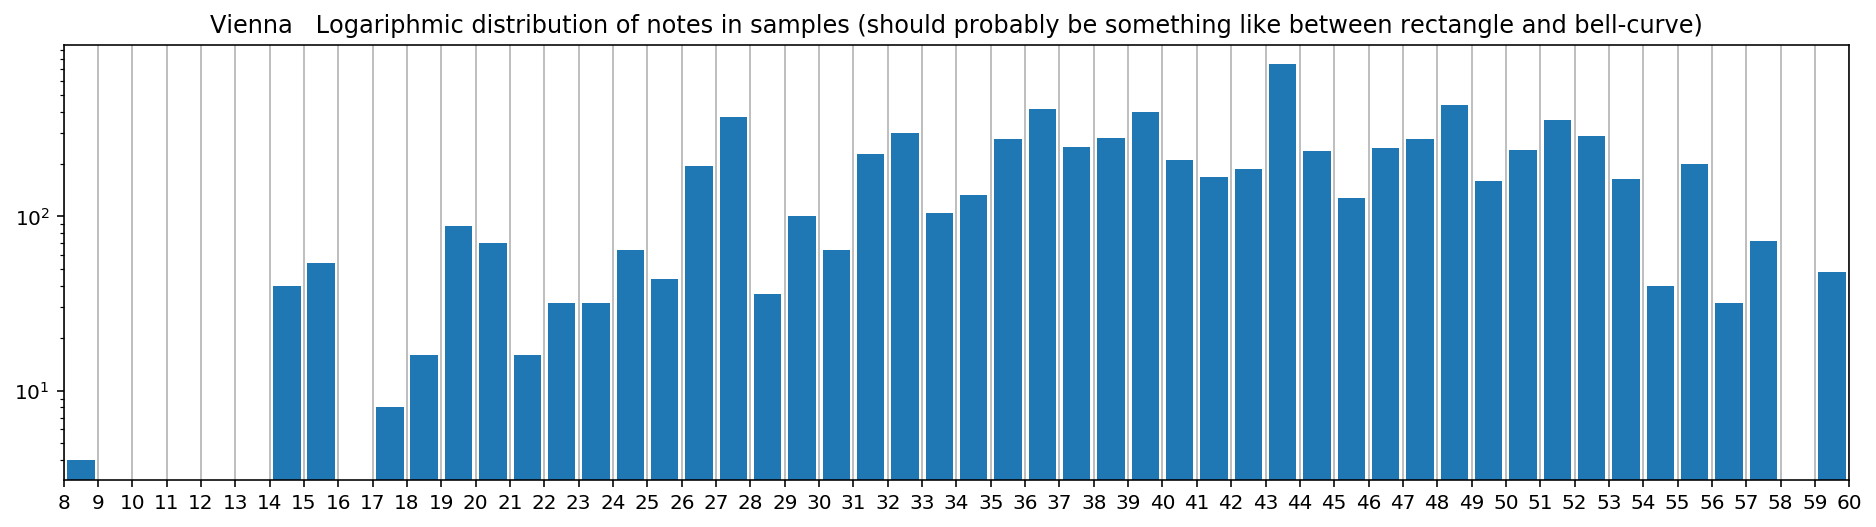

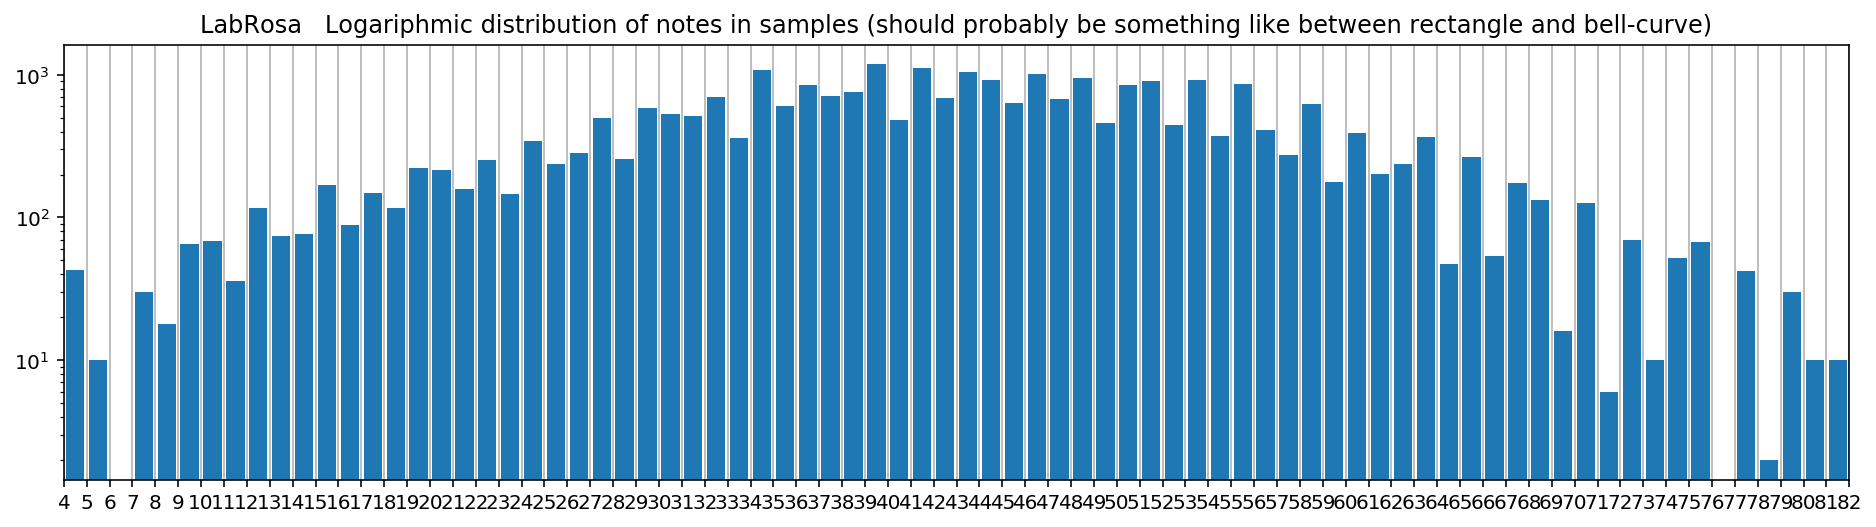

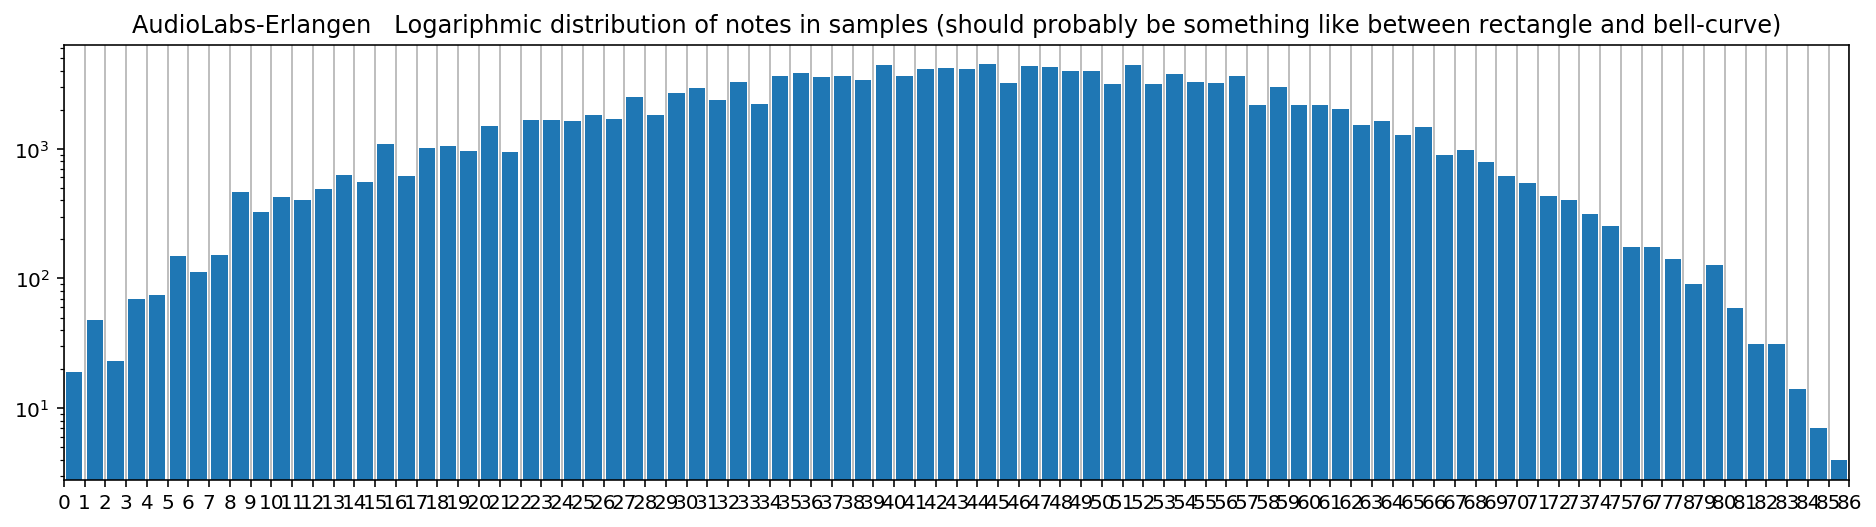

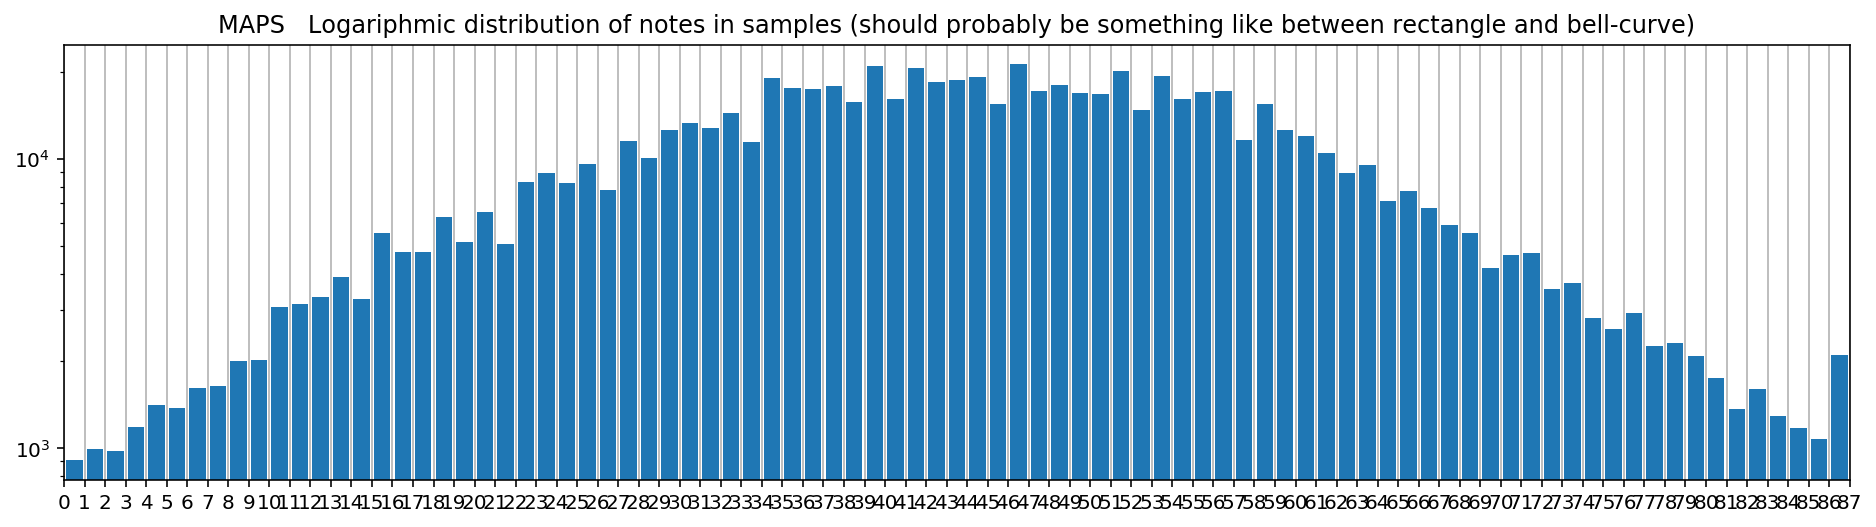

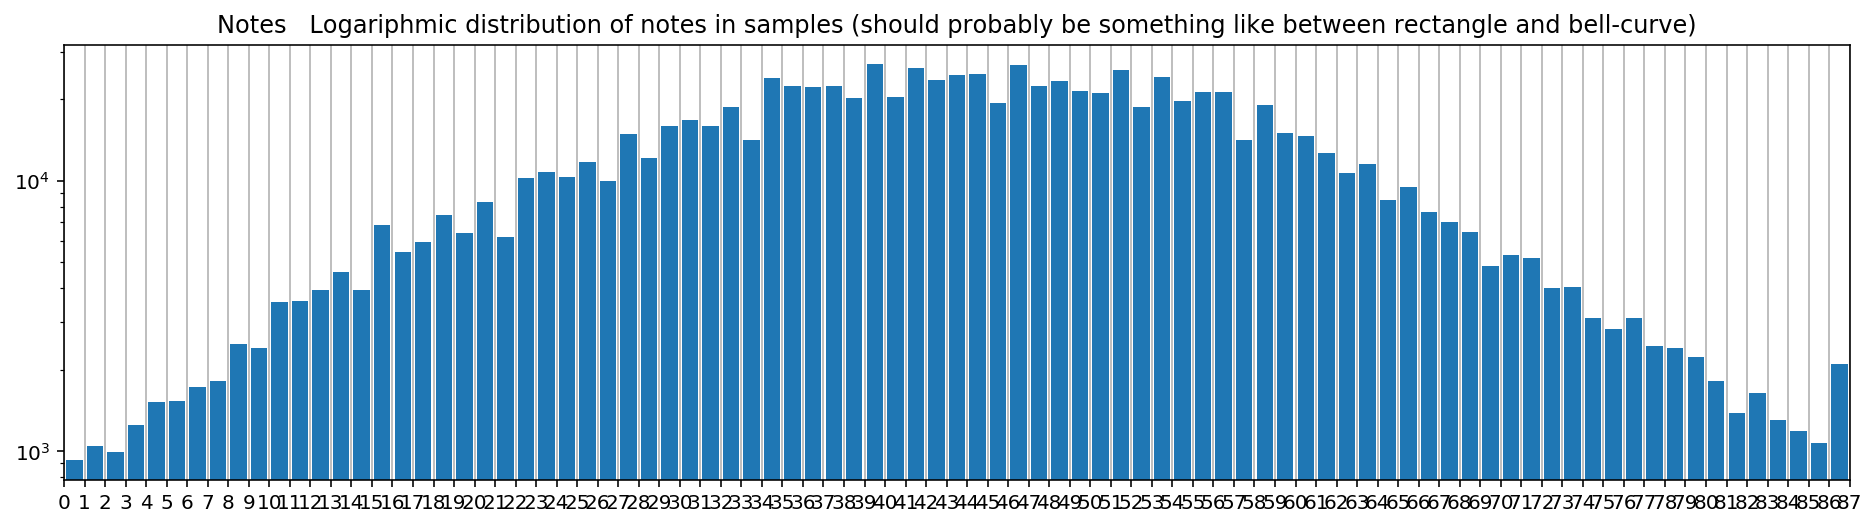

In [13]:
for notesNumPy in ['Vienna Notes 5253', 'LabRosa Columbia Notes 11366',
                   'AudioLabs-Erlangen Notes 103928', 'MAPS Notes 408870', 'Notes 529417']:
    plt.figure(figsize=(16, 4))
    
    notes = np.load('{}/{}.npy'.format(dataFolder, notesNumPy))
    if len(notes.shape) in [1, 3]: notes = np.vstack(notes)
    noteCounts = notes.nonzero()[1]
    minNote, maxNote = noteCounts.min(), noteCounts.max()
    
    plt.hist(noteCounts, maxNote - minNote, rwidth=.8, log=True)
    plt.title(notesNumPy.split()[0] + '   Logariphmic distribution of notes in samples '
              '(should probably be something like between rectangle and bell-curve)')
    plt.xlim(minNote, maxNote)
    plt.xticks(range(minNote, maxNote + 1))
    plt.grid(axis='x')